In [36]:
import glob
import json
import logging
import os
import re
from pathlib import Path
from typing import Dict, Any, Union, Tuple
from typing import List

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame

In [37]:
# Configure logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
                    level=logging.DEBUG)

In [38]:
plot_sat_name: str = '<sat_name>'
plot_desc_data_name: str = '<data_name>'

In [39]:
from tabulate import tabulate
from scipy.stats import chi2_contingency


def load_json_data(file_path: str) -> pd.DataFrame:
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    with open(file_path, 'r') as f:
        data = json.load(f)

    # Assuming that all items in the JSON file have the same structure
    keys: List[str] = list(data[0].keys())
    filtered_data: List[Dict[str, Any]] = [{key: item[key] for key in keys} for
                                           item in data]

    df: pd.DataFrame = pd.DataFrame(filtered_data)

    return df


def convert_to_universal_time_format(df: pd.DataFrame,
                                     to_period: str = 'D') -> pd.DataFrame:
    # Identify columns that match a regular expression pattern for "time"
    time_columns: List[str] = [col for col in df.columns if
                               re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                        col)]

    # Convert identified columns to datetime format and extract year and month
    for col in time_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].dt.to_period(to_period)

    # Group by year and month, and calculate the median of each group
    for col in time_columns:
        df = df.groupby(col).median().reset_index()

    return df


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]

    if len(time_cols) == 1:
        df.rename(columns={time_cols[0]: 'time'}, inplace=True)

    # Handle multiple time indices
    if len(time_cols) > 1:
        for i, col in enumerate(time_cols[1:], start=1):
            df.rename(columns={col: f'time{i}'}, inplace=True)

    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    # Process time columns in both dataframes
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)

    # Merge dataframes
    merged_df: pd.DataFrame = pd.merge(df1, df2, how='inner')

    return merged_df


def filter_by_years(df: pd.DataFrame,
                    years_to_analyze: List[int]) -> pd.DataFrame:
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]

    filtered_df: DataFrame = DataFrame()

    for col in time_cols:
        filtered_df = df[df[col].dt.year.isin(years_to_analyze)]

    return filtered_df


def calculate_correlation(df: pd.DataFrame, col1: str, col2: str) -> Tuple[
    Union[float, DataFrame], float, float]:
    correlation: Union[float, DataFrame] = df[col1].corr(df[col2])
    kendal_tau = df[col1].corr(df[col2], method='kendall')
    spearman = df[col1].corr(df[col2], method='spearman')
    return correlation, kendal_tau, spearman


def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str) -> None:
    # Check if columns exist in dataframe
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError("One or both columns do not exist in the dataframe")

    # Check if columns contain numerical data
    if not pd.api.types.is_numeric_dtype(
            df[x_col]) or not pd.api.types.is_numeric_dtype(df[y_col]):
        raise TypeError("One or both columns are not numeric")

    plt.figure(figsize=(10, 8))
    plt.scatter(df[x_col], df[y_col])
    plt.title(
        f'{plot_sat_name}: plot of {x_col} ({plot_desc_data_name}) vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


def plot_scatter_multiple(df: pd.DataFrame, x_col: str,
                          y_cols: List[str]) -> None:
    if len(y_cols) == 1:
        plot_scatter(df, x_col, y_cols[0])
        return

    # Check if x column exists in dataframe
    if x_col not in df.columns:
        raise ValueError("X column does not exist in the dataframe")

    # Check if x column contains numerical data
    if not pd.api.types.is_numeric_dtype(df[x_col]):
        raise TypeError("X column is not numeric")

    # Check if all y columns exist in dataframe and contain numerical data
    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(
                f"Y column {y_col} does not exist in the dataframe")
        if not pd.api.types.is_numeric_dtype(df[y_col]):
            raise TypeError(f"Y column {y_col} is not numeric")

    plt.figure(figsize=(10, 8))
    for y_col in y_cols:
        plt.scatter(df[x_col], df[y_col], label=y_col)
    plt.title(
        f'{plot_sat_name}: plot of {x_col} ({plot_desc_data_name}) vs multiple y-columns')
    plt.xlabel(x_col)
    plt.ylabel('Values')
    plt.legend()
    plt.show()


def calculate_correlations_and_plot(df: pd.DataFrame, col_list1: List[str],
                                    col_list2: List[str]) -> None:
    for col1 in col_list1:
        for col2 in col_list2:
            if col1 != col2:
                correlation, kendal_tau, spearman = calculate_correlation(df,
                                                                          col1,
                                                                          col2)
                # Calculate additional statistics for both columns
                stats_col1 = df[col1].describe().transpose()
                stats_col2 = df[col2].describe().transpose()

                # Combine statistics into a single DataFrame
                stats_table = pd.concat([stats_col1, stats_col2], axis=1,
                                        keys=[col1, col2])

                try:
                    # Additional statistical measures
                    chi2, p, _, _ = chi2_contingency(
                        pd.crosstab(df[col1].dropna(), df[col2].dropna()))

                    stats_table.loc['Chi2'] = [chi2, chi2]
                    stats_table.loc['P-value'] = [p, p]
                except Exception as e:
                    pass

                # Print the table with tabulate for a pretty output
                print(tabulate(stats_table, headers='keys', tablefmt='psql'))

                print(
                    f"Correlation [{col1}] vs [{col2}]: pearson=[{correlation}], spearman=[{spearman}], kendal_tau=[{kendal_tau}]")
            else:
                col_list2.remove(col1)
        plot_scatter_multiple(df, col1, col_list2)


def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    # Ignore the first column
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)

    return df.drop(cols_to_drop, axis=1)


def is_column_constant(df: pd.DataFrame, column: str,
                       required_unique_values_amount: int = 1) -> bool:
    unique_values = df[column].dropna().unique()
    return len(unique_values) <= required_unique_values_amount


def preprocess_solar_data(
        solar_data_file: Union[os.PathLike, str]) -> pd.DataFrame:
    df: DataFrame = load_json_data(solar_data_file)
    df = convert_to_universal_time_format(df)
    return df


def preprocess_satellite_data(satellite_data_file: Union[os.PathLike, str],
                              years_to_analyze: List[int]) -> pd.DataFrame:
    df: DataFrame = pd.read_csv(satellite_data_file)
    df = remove_non_numeric_data(df)
    df = convert_to_universal_time_format(df)
    filter_by_years(df, years_to_analyze)
    return df


def process(solar_data_file: Union[os.PathLike, str],
            satellite_data_file: Union[os.PathLike, str],
            years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019,
                                           2014]) -> None:
    # Preprocess solar data
    df_solar = preprocess_solar_data(solar_data_file)

    # Preprocess satellite data
    df_satellite = preprocess_satellite_data(satellite_data_file,
                                             years_to_analyze)

    # Extract column names excluding time/date columns
    solar_column_names = [col for col in df_solar.columns if
                          not re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                       col)]
    satellite_column_names = [col for col in df_satellite.columns if
                              not re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                           col)]

    # Constants for the uniqueness coefficient threshold and the solar column index
    uniqueness_coefficient_threshold: float = 0.001
    solar_column_index: int = 0

    for satellite_column in satellite_column_names:
        min_unique_count = int(uniqueness_coefficient_threshold * len(
            df_solar[solar_column_names[solar_column_index]]))

        if is_column_constant(df_satellite, satellite_column, min_unique_count):
            print(
                f"[{plot_desc_data_name}]: skipping column=[{satellite_column}]: not enough unique values.")
            return

    # Merge dataframes by time
    df_solar_satellite_merged = merge_dataframes_by_time(df_solar, df_satellite)

    # Calculate correlations and plot
    calculate_correlations_and_plot(df_solar_satellite_merged,
                                    satellite_column_names, solar_column_names)


In [40]:
def analyze_satellite(sat_name: str):
    observed_solar_cycle_data_path: Path = '../data/swpc_observed_ssn.json'
    sat_csv_data_files: List[str] = glob.glob(
        os.path.join(f"../data/{sat_name}", "*.csv"))

    if not sat_csv_data_files:
        logging.error(
            f"No CSV files found for satellite={sat_name}. Path checked={observed_solar_cycle_data_path}")
        return

    for sat_file in sat_csv_data_files:
        try:
            assert os.path.exists(sat_file), f"File does not exist: {sat_file}"
            logging.debug(f"Processing file: {sat_file}")

            global plot_desc_data_name
            plot_desc_data_name = os.path.basename(sat_file)
            plot_desc_data_name = re.sub(r'-\d.*$|\.\w+$', '',
                                         plot_desc_data_name,
                                         flags=re.IGNORECASE)
            assert plot_desc_data_name, f"Failed to extract plot description from filename: {sat_file}"

            process(solar_data_file=observed_solar_cycle_data_path,
                    satellite_data_file=os.path.abspath(sat_file))
        except AssertionError as e:
            logging.error(e)
        except Exception as ex:
            logging.exception(
                f"Unexpected error processing file=[{sat_file}] : {ex}")

2024-02-11 17:44:52,743 - DEBUG - Processing file: ../data/griffex/battery.csv


+---------+----------------+----------------+
|         |        Battery |       swpc_ssn |
|---------+----------------+----------------|
| count   | 1418           | 1418           |
| mean    |    8.25282     |   60.9464      |
| std     |    0.111554    |   51.2837      |
| min     |    7.4         |    0           |
| 25%     |    8.3         |   14           |
| 50%     |    8.3         |   49           |
| 75%     |    8.3         |   99           |
| max     |    8.4         |  227           |
| Chi2    | 3149.82        | 3149.82        |
| P-value |    4.21142e-78 |    4.21142e-78 |
+---------+----------------+----------------+
Correlation [Battery] vs [swpc_ssn]: pearson=[-0.05633533230487771], spearman=[0.009183743692619008], kendal_tau=[0.0051619469492026875]


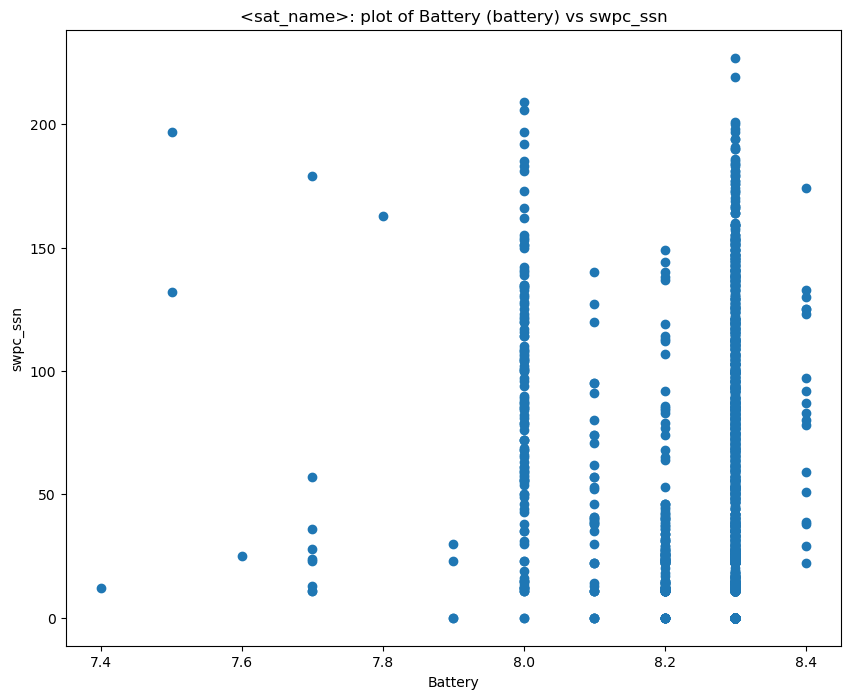

2024-02-11 17:44:52,903 - DEBUG - Processing file: ../data/griffex/battery_3v.csv
2024-02-11 17:44:52,923 - DEBUG - Processing file: ../data/griffex/battery_5v.csv
2024-02-11 17:44:52,945 - DEBUG - Processing file: ../data/griffex/bus_current.csv


[battery_3v]: skipping column=[3.3V]: not enough unique values.
[battery_5v]: skipping column=[5V]: not enough unique values.
+---------+------------------+------------------+
|         |      Battery Bus |         swpc_ssn |
|---------+------------------+------------------|
| count   |  1418            |  1418            |
| mean    |     0.201327     |    60.9464       |
| std     |     0.274658     |    51.2837       |
| min     |     0.031        |     0            |
| 25%     |     0.033        |    14            |
| 50%     |     0.0555       |    49            |
| 75%     |     0.25         |    99            |
| max     |     1.4          |   227            |
| Chi2    | 34497.4          | 34497.4          |
| P-value |     4.98556e-140 |     4.98556e-140 |
+---------+------------------+------------------+
Correlation [Battery Bus] vs [swpc_ssn]: pearson=[0.13672412903702072], spearman=[0.39612621911017304], kendal_tau=[0.27477822293117526]


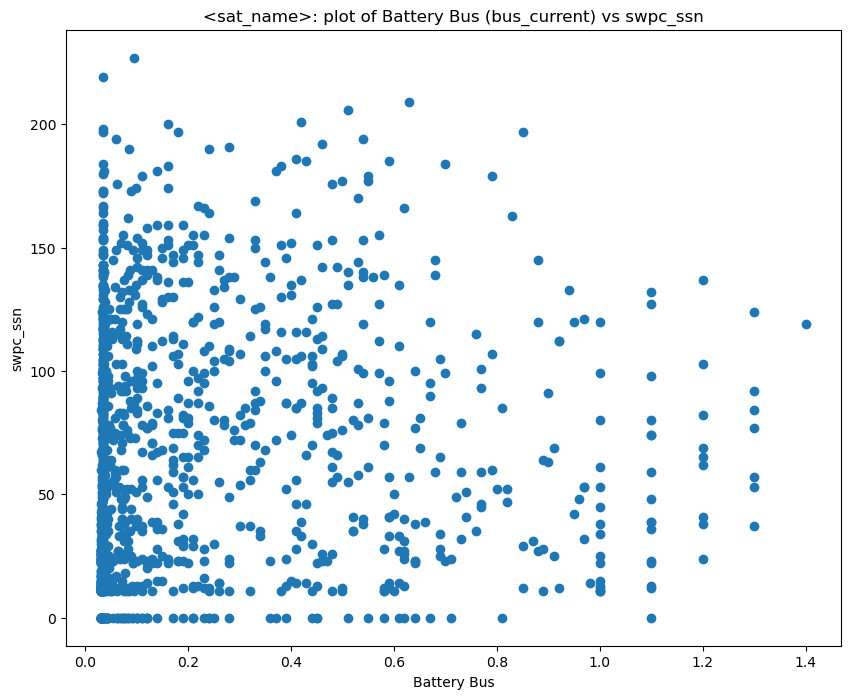

2024-02-11 17:44:53,114 - DEBUG - Processing file: ../data/griffex/bus_voltage.csv


+---------+----------------+----------------+
|         |    Battery Bus |       swpc_ssn |
|---------+----------------+----------------|
| count   | 1418           | 1418           |
| mean    |    8.28188     |   60.9464      |
| std     |    0.116477    |   51.2837      |
| min     |    7.4         |    0           |
| 25%     |    8.3         |   14           |
| 50%     |    8.3         |   49           |
| 75%     |    8.3         |   99           |
| max     |    8.4         |  227           |
| Chi2    | 1789.93        | 1789.93        |
| P-value |    2.60546e-10 |    2.60546e-10 |
+---------+----------------+----------------+
Correlation [Battery Bus] vs [swpc_ssn]: pearson=[0.003239808274962762], spearman=[0.12023594381103614], kendal_tau=[0.09204306050681259]


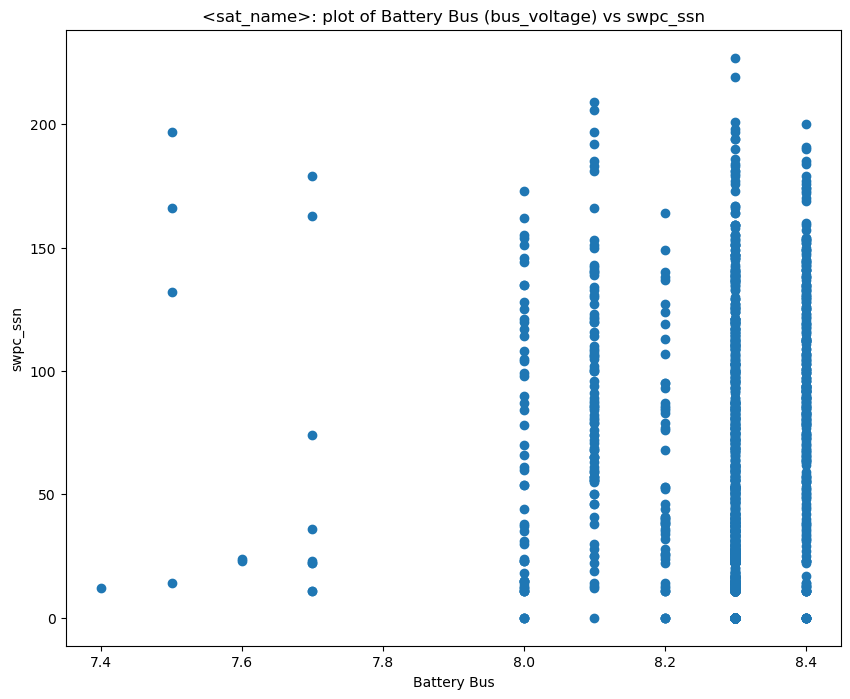

2024-02-11 17:44:53,271 - DEBUG - Processing file: ../data/griffex/data_mnt_usage.csv


+---------+------------------+------------------+
|         |     40379.median |         swpc_ssn |
|---------+------------------+------------------|
| count   |   1418           |   1418           |
| mean    | 479867           |     60.8505      |
| std     |  32335.5         |     51.2461      |
| min     | 395649           |      0           |
| 25%     | 484053           |     14           |
| 50%     | 493385           |     49           |
| 75%     | 498567           |     99           |
| max     | 499679           |    227           |
| Chi2    | 171857           | 171857           |
| P-value |      1.7832e-129 |      1.7832e-129 |
+---------+------------------+------------------+
Correlation [40379.median] vs [swpc_ssn]: pearson=[0.46315355052211304], spearman=[0.4759659161682569], kendal_tau=[0.32450245018819246]


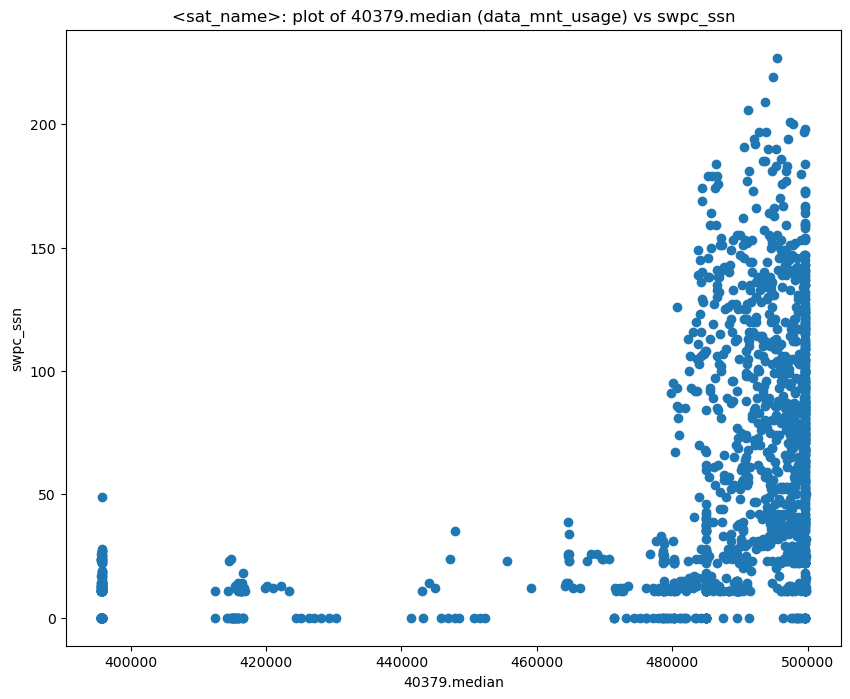

2024-02-11 17:44:53,440 - DEBUG - Processing file: ../data/griffex/memory_free_median.csv


+---------+-----------------+-------------+
|         |   40379.freemem |    swpc_ssn |
|---------+-----------------+-------------|
| count   |      1422       |  1422       |
| mean    |         3.92844 |    60.8629  |
| std     |         2.68321 |    51.2549  |
| min     |         0.18    |     0       |
| 25%     |         0.585   |    14       |
| 50%     |         4.3     |    49       |
| 75%     |         6.7     |    99       |
| max     |        12       |   227       |
| Chi2    |     28481.8     | 28481.8     |
| P-value |         0.20023 |     0.20023 |
+---------+-----------------+-------------+
Correlation [40379.freemem] vs [swpc_ssn]: pearson=[-0.2553320454993292], spearman=[-0.28660957028269796], kendal_tau=[-0.19699078323395622]


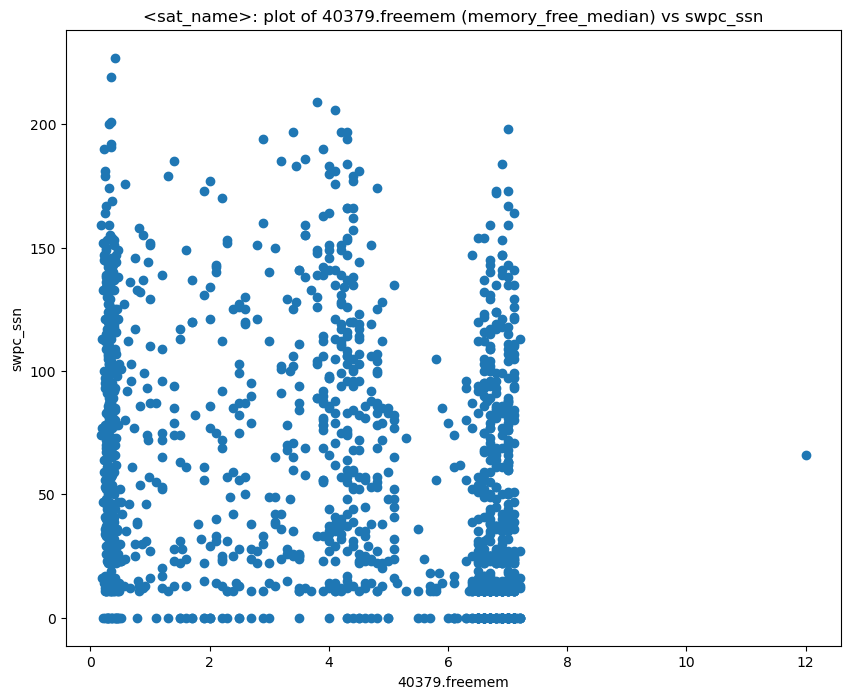

2024-02-11 17:44:54,117 - DEBUG - Processing file: ../data/griffex/memory_median.csv
2024-02-11 17:44:54,138 - DEBUG - Processing file: ../data/griffex/resets.csv


[memory_median]: skipping column=[40379.median]: not enough unique values.
+---------+------------+-------------+
|         |     resets |    swpc_ssn |
|---------+------------+-------------|
| count   |   1421     |   1421      |
| mean    |   1065.66  |     60.9064 |
| std     |    621.888 |     51.2468 |
| min     |      0     |      0      |
| 25%     |    759     |     14      |
| 50%     |   1247     |     49      |
| 75%     |   1547     |     99      |
| max     |   4945     |    227      |
| Chi2    | 109307     | 109307      |
| P-value |      1     |      1      |
+---------+------------+-------------+
Correlation [resets] vs [swpc_ssn]: pearson=[0.17805007116349097], spearman=[0.3894670351522071], kendal_tau=[0.28077806323937066]


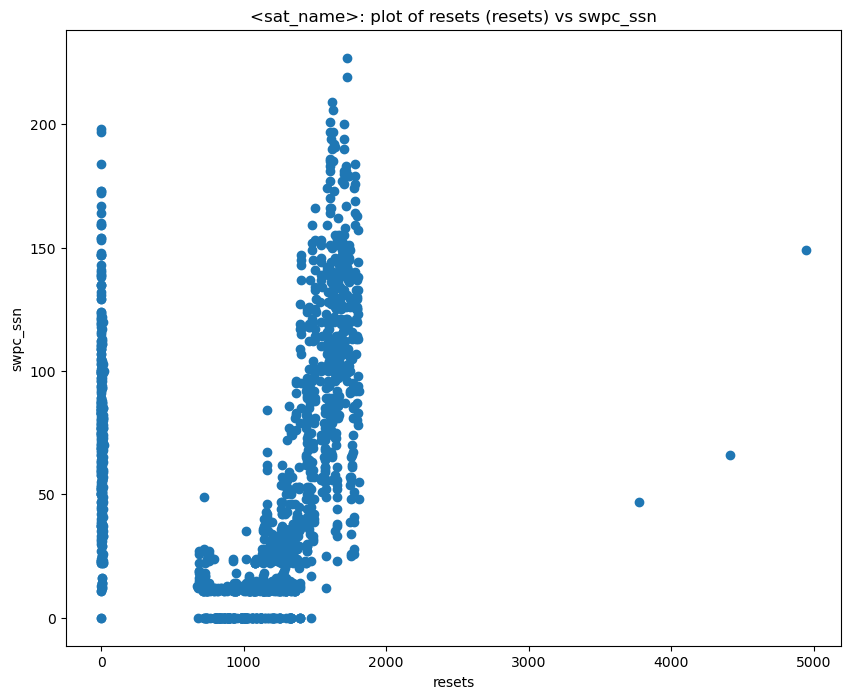

2024-02-11 17:44:54,300 - DEBUG - Processing file: ../data/griffex/rssi.csv


+---------+-------------+------------+
|         |   40379.min |   swpc_ssn |
|---------+-------------+------------|
| count   |   1421      |  1421      |
| mean    |    -61.8255 |    61.0021 |
| std     |     10.8516 |    51.2843 |
| min     |   -107      |     0      |
| 25%     |    -65      |    14      |
| 50%     |    -61      |    49      |
| 75%     |    -56      |    99      |
| max     |      0      |   227      |
| Chi2    |  10352.7    | 10352.7    |
| P-value |      1      |     1      |
+---------+-------------+------------+
Correlation [40379.min] vs [swpc_ssn]: pearson=[0.18531758277930818], spearman=[0.15340700721706893], kendal_tau=[0.10434218347405477]


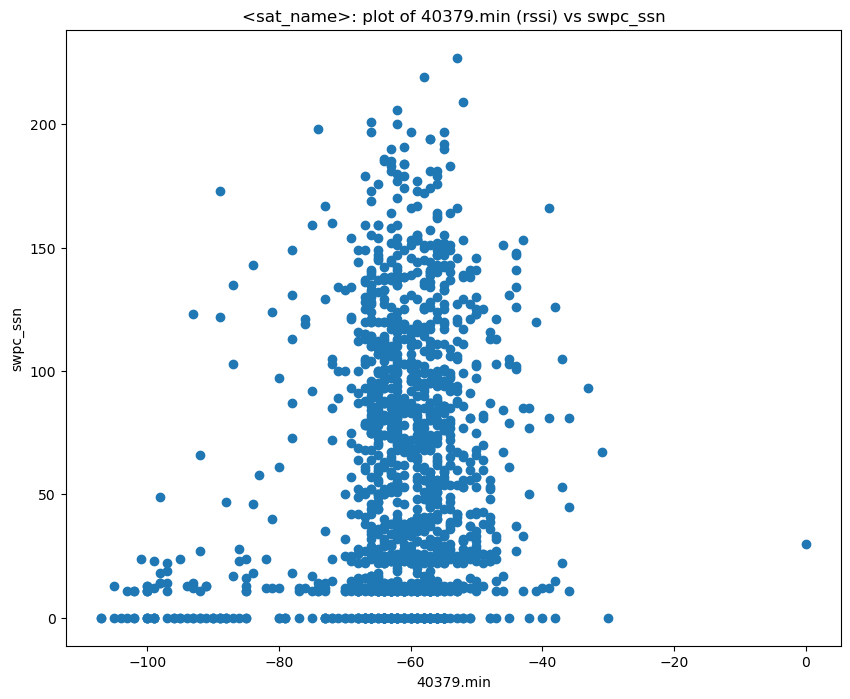

In [41]:
analyze_satellite('griffex')

2024-02-11 17:44:54,465 - DEBUG - Processing file: ../data/cas-5a/Power Supply Voltage-data-2024-02-11 02 21 52.csv


+---------+---------------------+------------+
|         |   54684.mode_mode V |   swpc_ssn |
|---------+---------------------+------------|
| count   |           18        |  18        |
| mean    |           11.4661   | 109        |
| std     |            0.150612 |  34.8037   |
| min     |           11.3      |  33        |
| 25%     |           11.35     |  99.5      |
| 50%     |           11.46     | 106        |
| 75%     |           11.51     | 133.75     |
| max     |           11.91     | 166        |
| Chi2    |          173.25     | 173.25     |
| P-value |            0.314423 |   0.314423 |
+---------+---------------------+------------+
Correlation [54684.mode_mode V] vs [swpc_ssn]: pearson=[0.12142101001190515], spearman=[0.35361993001509145], kendal_tau=[0.23057339665182852]


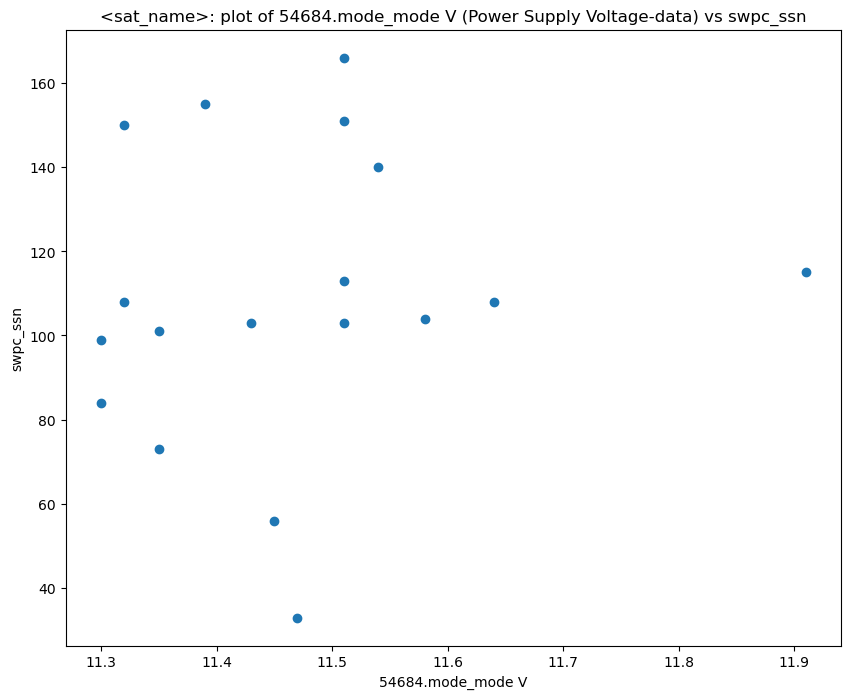

2024-02-11 17:44:54,634 - DEBUG - Processing file: ../data/cas-5a/RF Power-data-2024-02-11 02 22 25.csv


+---------+--------------+-------------+
|         |   UHF1 Power |    swpc_ssn |
|---------+--------------+-------------|
| count   |   114        |  114        |
| mean    |  1407.48     |  117.395    |
| std     |   136.545    |   42.6178   |
| min     |  1092        |   23        |
| 25%     |  1263        |   87.25     |
| 50%     |  1476        |  110.5      |
| 75%     |  1512.25     |  140.75     |
| max     |  1578        |  209        |
| Chi2    |  5030.79     | 5030.79     |
| P-value |     0.438725 |    0.438725 |
+---------+--------------+-------------+
Correlation [UHF1 Power] vs [swpc_ssn]: pearson=[-0.15676750343342466], spearman=[-0.1927394646248011], kendal_tau=[-0.13246747181362192]


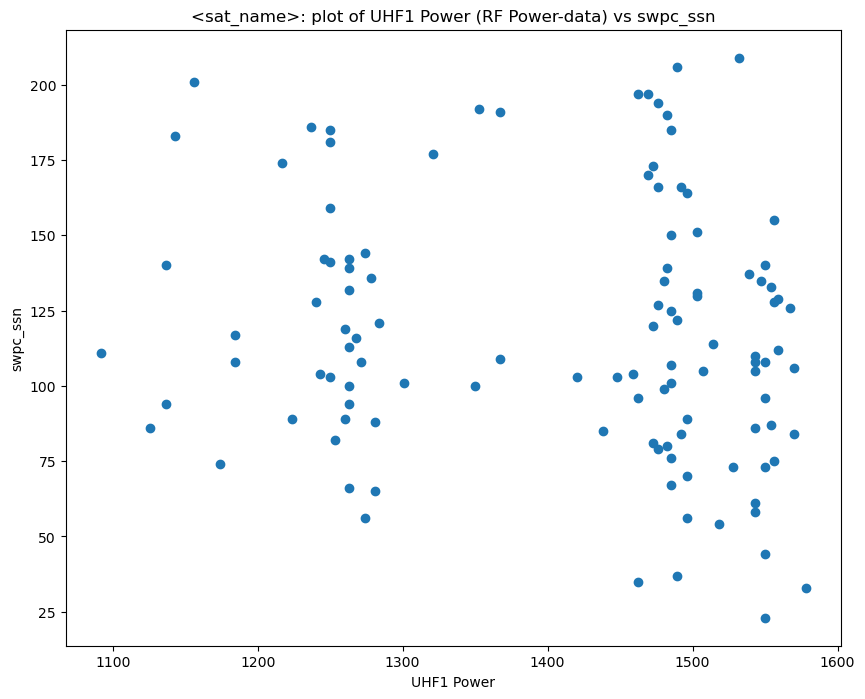

2024-02-11 17:44:54,785 - DEBUG - Processing file: ../data/cas-5a/System Currents-data-2024-02-11 02 22 13.csv
2024-02-11 17:44:54,803 - DEBUG - Processing file: ../data/cas-5a/System Temperatures (C)-data-2024-02-11 02 22 19.csv


[System Currents-data]: skipping column=[Primary Bus Current]: not enough unique values.
+---------+--------------+--------------+
|         |          IHU |     swpc_ssn |
|---------+--------------+--------------|
| count   |  114         |  114         |
| mean    |   16.5       |  117.395     |
| std     |    2.47197   |   42.6178    |
| min     |   13         |   23         |
| 25%     |   15         |   87.25      |
| 50%     |   16         |  110.5       |
| 75%     |   17         |  140.75      |
| max     |   26         |  209         |
| Chi2    | 1032.9       | 1032.9       |
| P-value |    0.0723609 |    0.0723609 |
+---------+--------------+--------------+
Correlation [IHU] vs [swpc_ssn]: pearson=[0.014742294538607096], spearman=[-0.008542958649201576], kendal_tau=[-0.009403302154266163]


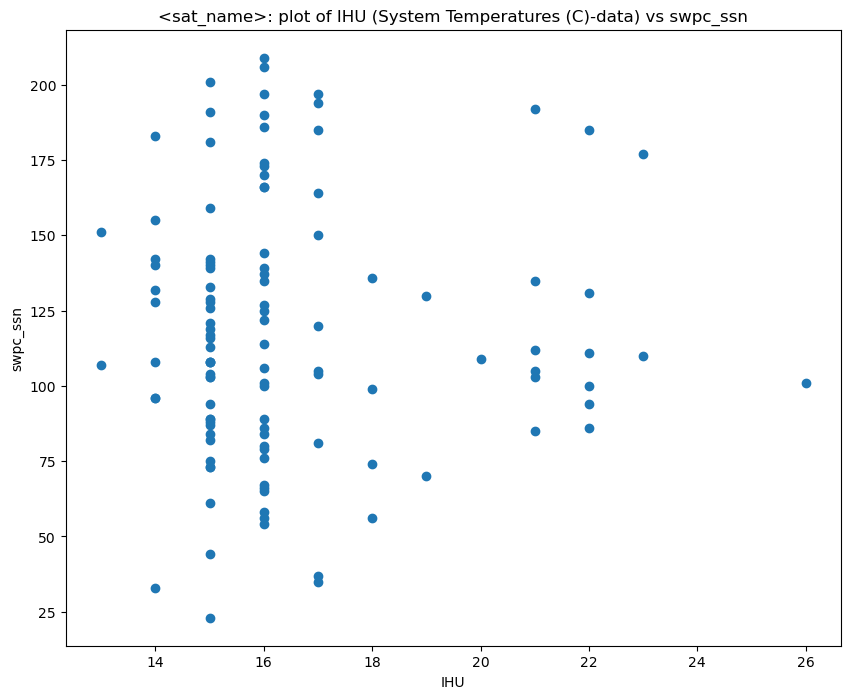

2024-02-11 17:44:54,954 - DEBUG - Processing file: ../data/cas-5a/Total Solar Array Current-data-2024-02-11 02 22 49.csv
2024-02-11 17:44:54,972 - DEBUG - Processing file: ../data/cas-5a/Watchdog (48 hrs)-data-2024-02-11 02 23 13.csv


[Total Solar Array Current-data]: skipping column=[Total Solar Array Current]: not enough unique values.


2024-02-11 17:44:55,104 - DEBUG - Processing file: ../data/cas-5a/AGC Levels-data-2024-02-11 02 22 35.csv
2024-02-11 17:44:55,122 - DEBUG - Processing file: ../data/cas-5a/Camera Photo Counters-data-2024-02-11 02 22 58.csv


[Watchdog (48 hrs)-data]: skipping column=[YY]: not enough unique values.
[AGC Levels-data]: skipping column=[VHF AGC]: not enough unique values.


2024-02-11 17:44:55,235 - DEBUG - Processing file: ../data/cas-5a/Camera Status-data-2024-02-11 02 23 01.csv
2024-02-11 17:44:55,254 - DEBUG - Processing file: ../data/cas-5a/Image Data-data-2024-02-11 02 22 41.csv


[Camera Photo Counters-data]: skipping column=[Cam #1]: not enough unique values.


2024-02-11 17:44:55,392 - DEBUG - Processing file: ../data/cas-5a/Last Frame Rcvd By-data-2024-02-11 02 22 06.csv
2024-02-11 17:44:55,411 - DEBUG - Processing file: ../data/cas-5a/Operating Mode-data-2024-02-11 02 23 19.csv


[Image Data-data]: skipping column=[Year]: not enough unique values.
[Last Frame Rcvd By-data]: skipping column=[observer where 0 is DK3WN-JN49lr]: not enough unique values.


In [42]:
analyze_satellite('cas-5a')

2024-02-11 17:44:55,564 - DEBUG - Processing file: ../data/cubebel-1/Solar Voltage-data-2024-02-11 02 19 56.csv


+---------+------------------+---------------+
|         |   43666.distinct |      swpc_ssn |
|---------+------------------+---------------|
| count   |     118          |  118          |
| mean    |       4.80042    |   43.7203     |
| std     |       0.306796   |   45.0096     |
| min     |       3.1        |    0          |
| 25%     |       4.8        |   11          |
| 50%     |       4.9        |   25          |
| 75%     |       4.95       |   76.5        |
| max     |       5.05       |  176          |
| Chi2    |    1121.16       | 1121.16       |
| P-value |       1.2168e-05 |    1.2168e-05 |
+---------+------------------+---------------+
Correlation [43666.distinct] vs [swpc_ssn]: pearson=[0.18077471127101538], spearman=[0.265121452157792], kendal_tau=[0.19735697842488076]


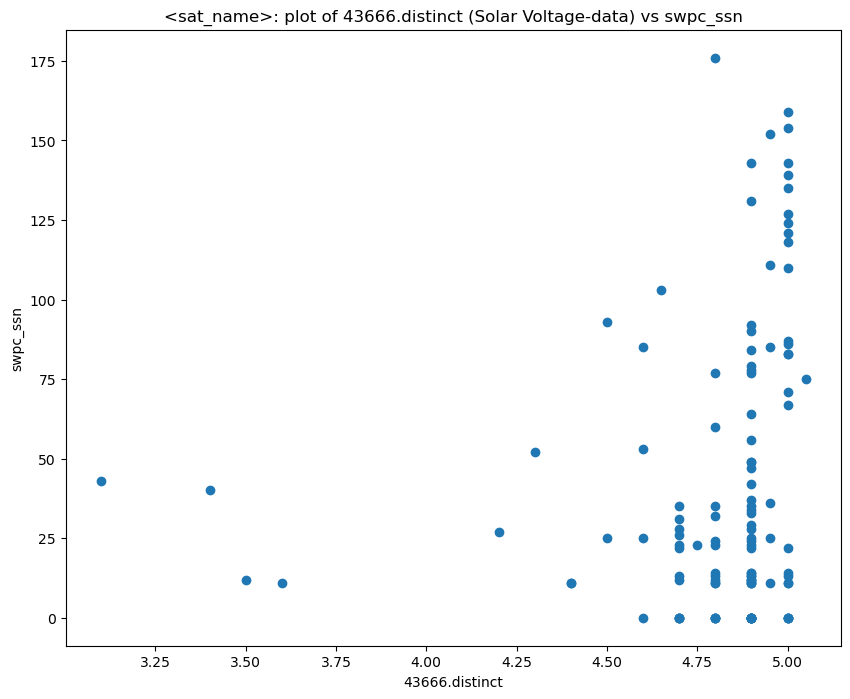

2024-02-11 17:44:55,725 - DEBUG - Processing file: ../data/cubebel-1/System 3.3V Voltage-data-2024-02-11 02 19 52.csv
2024-02-11 17:44:55,744 - DEBUG - Processing file: ../data/cubebel-1/System 5V Voltage-data-2024-02-11 02 19 58.csv
2024-02-11 17:44:55,766 - DEBUG - Processing file: ../data/cubebel-1/System Currents-data-2024-02-11 02 19 49.csv


[System 3.3V Voltage-data]: skipping column=[43666.distinct]: not enough unique values.
[System 5V Voltage-data]: skipping column=[43666.distinct]: not enough unique values.
+---------+--------------------+-----------------+
|         |   After BQ Current |        swpc_ssn |
|---------+--------------------+-----------------|
| count   |      626           |   626           |
| mean    |      147.928       |    24.5767      |
| std     |       42.4223      |    29.9056      |
| min     |        1.7         |     0           |
| 25%     |      131.625       |    11           |
| 50%     |      141           |    14           |
| 75%     |      159.5         |    28.75        |
| max     |      683           |   176           |
| Chi2    |    18839.3         | 18839.3         |
| P-value |        5.36654e-24 |     5.36654e-24 |
+---------+--------------------+-----------------+
Correlation [After BQ Current] vs [swpc_ssn]: pearson=[-0.25236920606970487], spearman=[-0.2843878766329617], ke

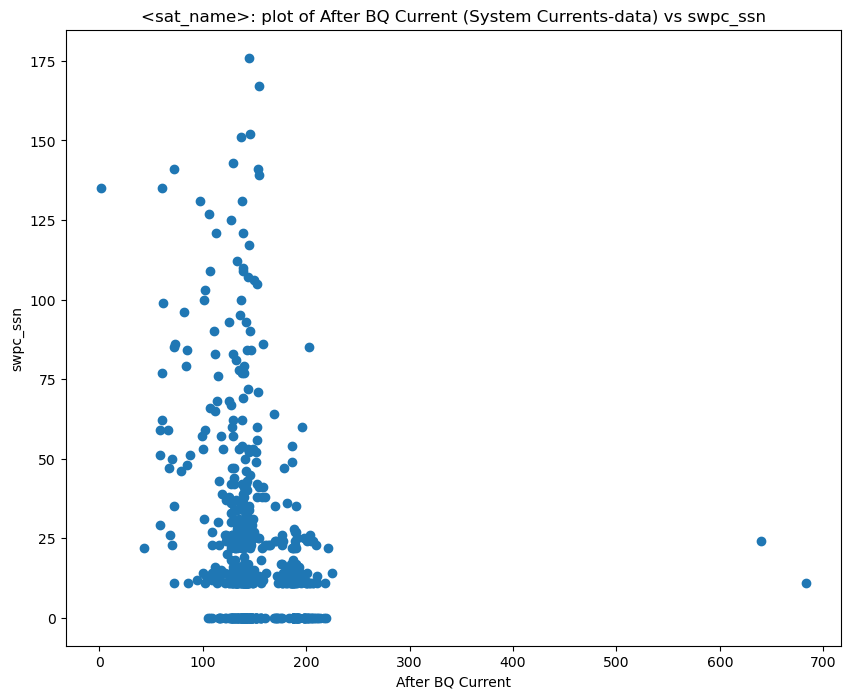

In [43]:
analyze_satellite('cubebel-1')

2024-02-11 17:44:55,994 - DEBUG - Processing file: ../data/cubebel-2/MB Reset Reason-data-2024-02-11 02 22 30.csv
2024-02-11 17:44:56,012 - DEBUG - Processing file: ../data/cubebel-2/Solar Panel Voltages-data-2024-02-11 02 21 48.csv


[MB Reset Reason-data]: skipping column=[last]: not enough unique values.
+---------+----------------------------------+-------------+
|         |   tlm_mb_solarpanel_0_volt_pos V |    swpc_ssn |
|---------+----------------------------------+-------------|
| count   |                       224        |  224        |
| mean    |                         4.93581  |  115.875    |
| std     |                         0.726483 |   39.7821   |
| min     |                         0.0021   |   25        |
| 25%     |                         5        |   88.75     |
| 50%     |                         5.075    |  119        |
| 75%     |                         5.2      |  142.25     |
| max     |                         5.5      |  227        |
| Chi2    |                      3114.31     | 3114.31     |
| P-value |                         0.998913 |    0.998913 |
+---------+----------------------------------+-------------+
Correlation [tlm_mb_solarpanel_0_volt_pos V] vs [swpc_ssn]: pearson=[-0.

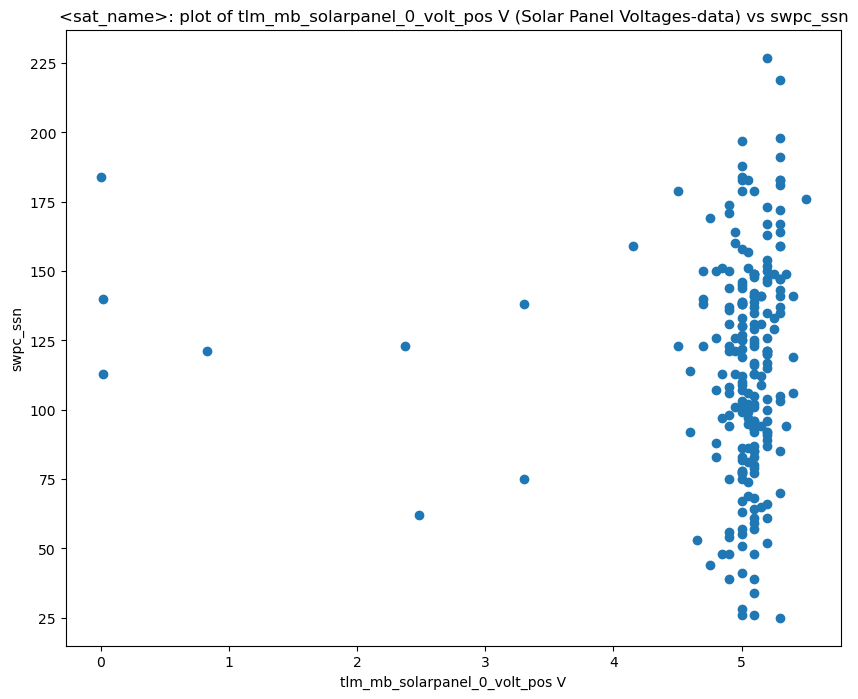

2024-02-11 17:44:56,197 - DEBUG - Processing file: ../data/cubebel-2/Solar Panels Current-data-2024-02-11 02 21 58.csv
2024-02-11 17:44:56,220 - DEBUG - Processing file: ../data/cubebel-2/TRX Primary Current-data-2024-02-11 02 21 54.csv
2024-02-11 17:44:56,239 - DEBUG - Processing file: ../data/cubebel-2/TRX Reset Reason-data-2024-02-11 02 22 32.csv
2024-02-11 17:44:56,257 - DEBUG - Processing file: ../data/cubebel-2/TRX Secondary Current-data-2024-02-11 02 21 52.csv
2024-02-11 17:44:56,275 - DEBUG - Processing file: ../data/cubebel-2/TRX Temperature-data-2024-02-11 02 22 07.csv


[Solar Panels Current-data]: skipping column=[57175.distinct A]: not enough unique values.
[TRX Primary Current-data]: skipping column=[57175.distinct A]: not enough unique values.
[TRX Reset Reason-data]: skipping column=[last]: not enough unique values.
[TRX Secondary Current-data]: skipping column=[57175.distinct A]: not enough unique values.
+---------+-----------------------+------------+
|         |   57175.distinct (°C) |   swpc_ssn |
|---------+-----------------------+------------|
| count   |             35        |  35        |
| mean    |             21.7416   | 116.771    |
| std     |             39.5923   |  36.4805   |
| min     |             10.38     |  28        |
| 25%     |             12.625    |  97        |
| 50%     |             15.19     | 121        |
| 75%     |             16.22     | 138        |
| max     |            248.13     | 179        |
| Chi2    |            790.417    | 790.417    |
| P-value |              0.342399 |   0.342399 |
+---------+----

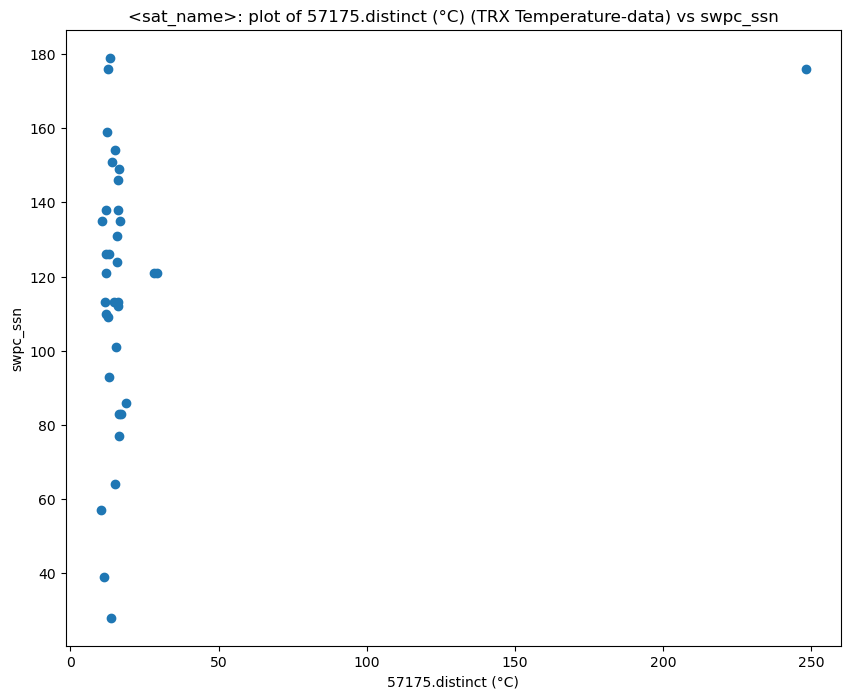

2024-02-11 17:44:56,422 - DEBUG - Processing file: ../data/cubebel-2/TRX Temperatures-data-2024-02-11 02 22 21.csv


+---------+-----------------------------+-------------+
|         |   tlm_trx_cmn_mcu_temp (°C) |    swpc_ssn |
|---------+-----------------------------+-------------|
| count   |                  225        |  225        |
| mean    |                   11.6267   |  115.973    |
| std     |                    3.88544  |   39.7206   |
| min     |                   -0.5      |   25        |
| 25%     |                    9        |   89        |
| 50%     |                   12        |  119        |
| 75%     |                   14.5      |  142        |
| max     |                   28        |  227        |
| Chi2    |                 4462.29     | 4462.29     |
| P-value |                    0.403912 |    0.403912 |
+---------+-----------------------------+-------------+
Correlation [tlm_trx_cmn_mcu_temp (°C)] vs [swpc_ssn]: pearson=[-0.1335898597307741], spearman=[-0.1267867890514931], kendal_tau=[-0.08656788064704421]


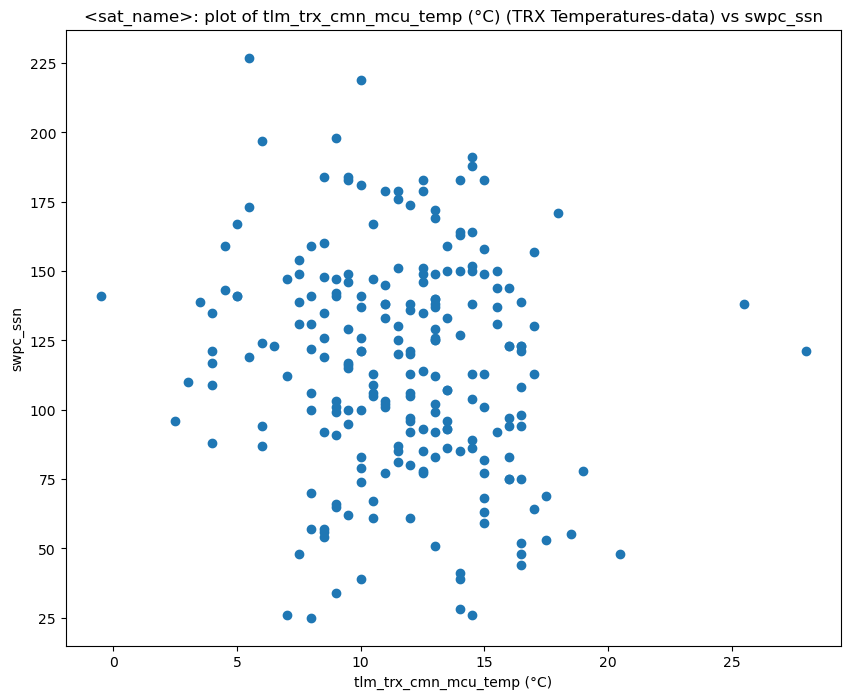

2024-02-11 17:44:56,586 - DEBUG - Processing file: ../data/cubebel-2/Voltages-data-2024-02-11 02 21 34.csv
2024-02-11 17:44:56,609 - DEBUG - Processing file: ../data/cubebel-2/ADC Temperatures-data-2024-02-11 02 21 40.csv


[Voltages-data]: skipping column=[tlm_mb_ant_1_v V]: not enough unique values.
+---------+--------------------------+--------------+
|         |   tlm_mb_adc_temp_1 (°C) |     swpc_ssn |
|---------+--------------------------+--------------|
| count   |               224        |   224        |
| mean    |                21.331    |   115.875    |
| std     |                74.8435   |    39.7821   |
| min     |                 2.6      |    25        |
| 25%     |                 6.7      |    88.75     |
| 50%     |                 8.775    |   119        |
| 75%     |                11        |   142.25     |
| max     |               505        |   227        |
| Chi2    |             13119.4      | 13119.4      |
| P-value |                 0.402167 |     0.402167 |
+---------+--------------------------+--------------+
Correlation [tlm_mb_adc_temp_1 (°C)] vs [swpc_ssn]: pearson=[0.014152016835721211], spearman=[-0.10660823483144659], kendal_tau=[-0.07170476343404308]


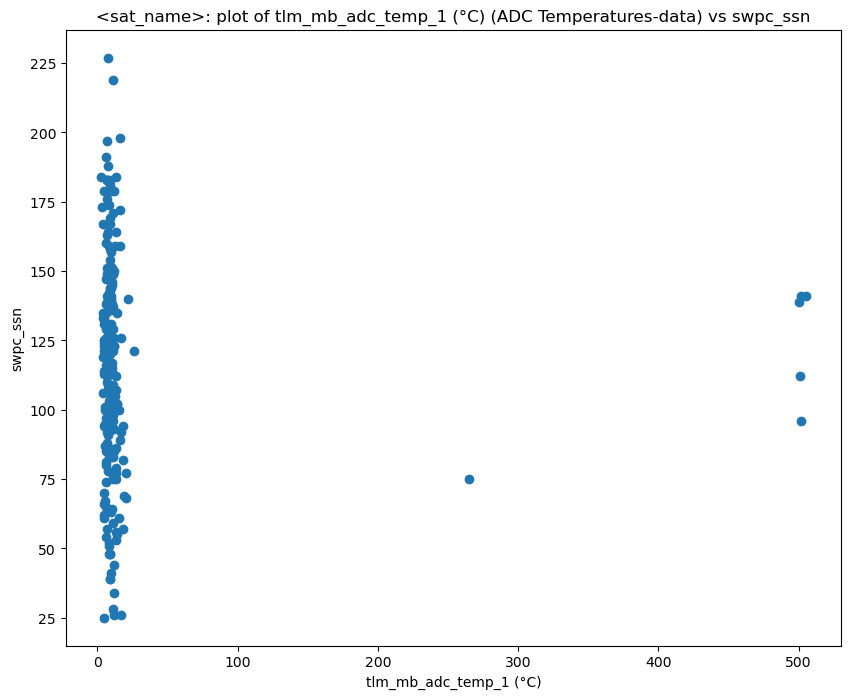

2024-02-11 17:44:56,768 - DEBUG - Processing file: ../data/cubebel-2/Battery 0 Temperature-data-2024-02-11 02 22 13.csv


+---------+-----------------------+------------+
|         |   57175.distinct (°C) |   swpc_ssn |
|---------+-----------------------+------------|
| count   |             34        |  34        |
| mean    |             49.9857   | 116.647    |
| std     |             84.3248   |  37.0216   |
| min     |             25.85     |  28        |
| 25%     |             33.9862   |  95        |
| 50%     |             36.06     | 121        |
| 75%     |             37.4025   | 138        |
| max     |            527.01     | 179        |
| Chi2    |            850        | 850        |
| P-value |              0.265749 |   0.265749 |
+---------+-----------------------+------------+
Correlation [57175.distinct (°C)] vs [swpc_ssn]: pearson=[0.28264537697330594], spearman=[0.14495417080322923], kendal_tau=[0.09703821302589397]


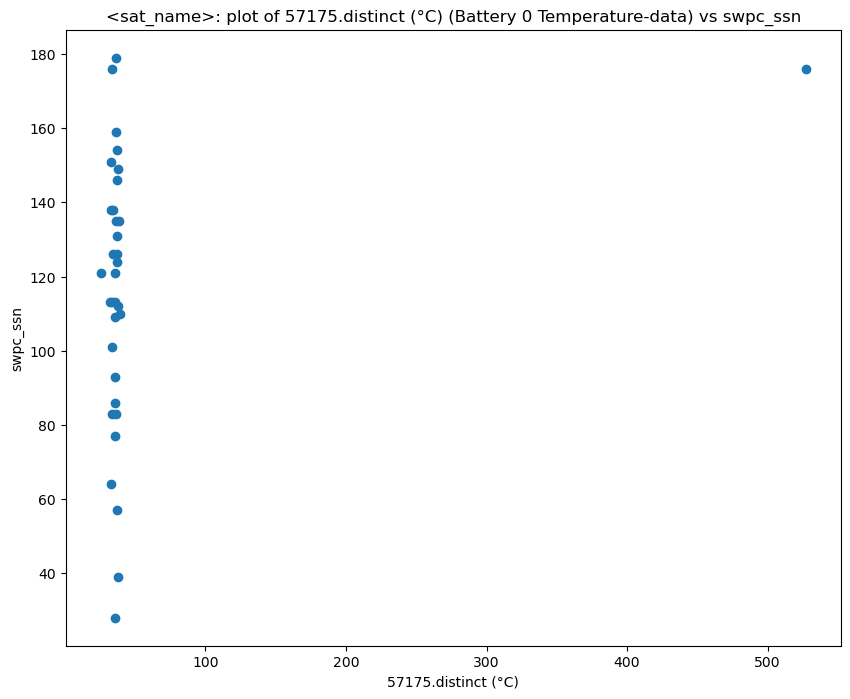

2024-02-11 17:44:56,910 - DEBUG - Processing file: ../data/cubebel-2/Battery 1 Temperature-data-2024-02-11 02 22 10.csv


+---------+-----------------------+------------+
|         |   57175.distinct (°C) |   swpc_ssn |
|---------+-----------------------+------------|
| count   |             34        |  34        |
| mean    |             49.8893   | 116.647    |
| std     |             84.317    |  37.0216   |
| min     |             26.2      |  28        |
| 25%     |             33.8175   |  95        |
| 50%     |             35.8325   | 121        |
| 75%     |             37.85     | 138        |
| max     |            526.86     | 179        |
| Chi2    |            850        | 850        |
| P-value |              0.265749 |   0.265749 |
+---------+-----------------------+------------+
Correlation [57175.distinct (°C)] vs [swpc_ssn]: pearson=[0.284701678404755], spearman=[0.161467937097268], kendal_tau=[0.09344420513604605]


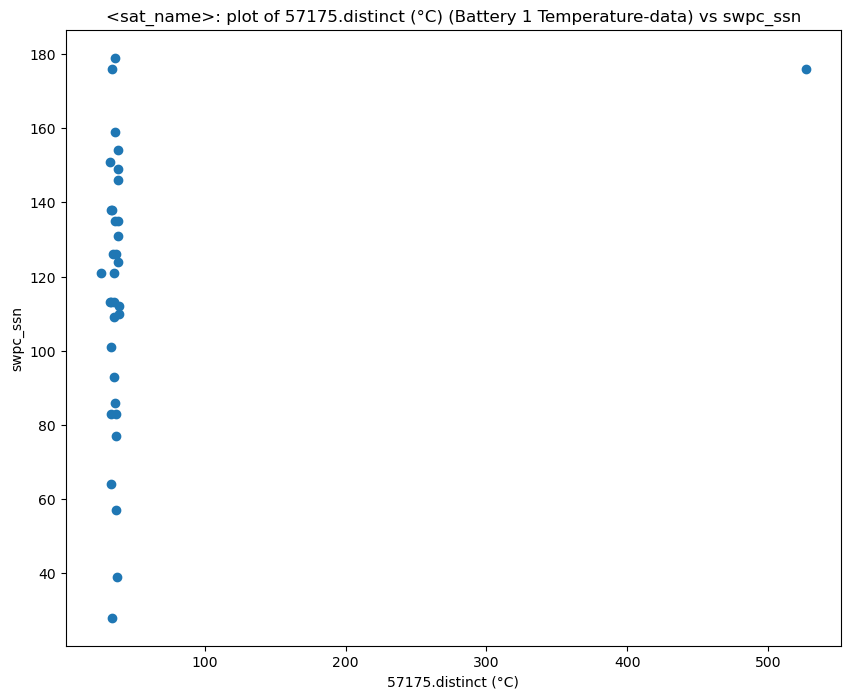

2024-02-11 17:44:57,054 - DEBUG - Processing file: ../data/cubebel-2/Battery Current-data-2024-02-11 02 21 43.csv


+---------+----------------------------------------------+-------------+
|         |   tlm_mb_battpack_0_element_0_current mA (A) |    swpc_ssn |
|---------+----------------------------------------------+-------------|
| count   |                                   224        |  224        |
| mean    |                                    57.0886   |  115.875    |
| std     |                                    15.9207   |   39.7821   |
| min     |                                    38        |   25        |
| 25%     |                                    52.4      |   88.75     |
| 50%     |                                    52.4      |  119        |
| 75%     |                                    52.4      |  142.25     |
| max     |                                   237.5      |  227        |
| Chi2    |                                  7184.46     | 7184.46     |
| P-value |                                     0.999035 |    0.999035 |
+---------+----------------------------------------

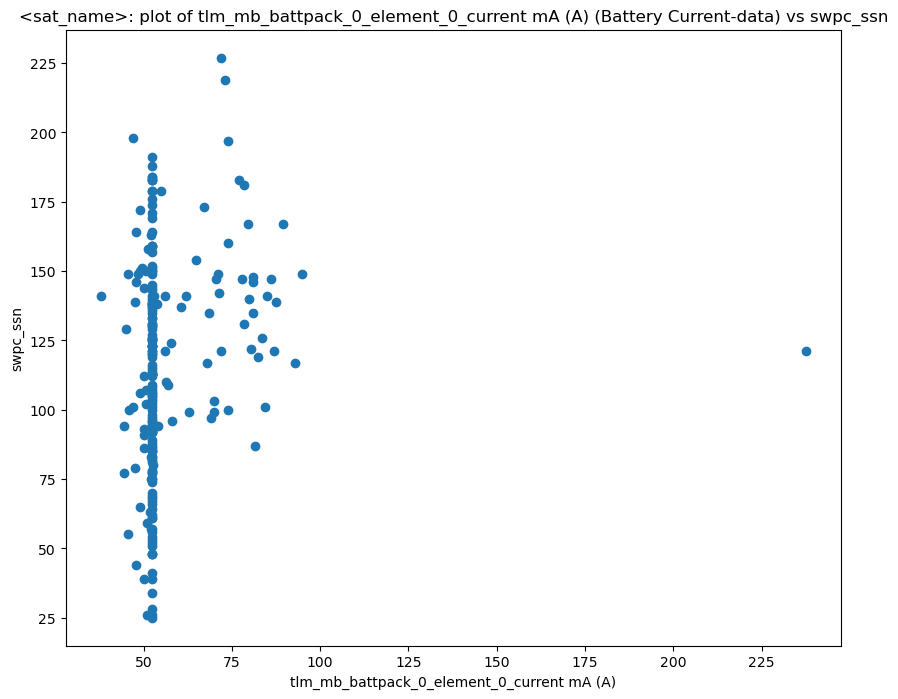

2024-02-11 17:44:57,218 - DEBUG - Processing file: ../data/cubebel-2/Battery Current-data-2024-02-11 02 22 15.csv


+---------+--------------------+------------+
|         |   57175.distinct A |   swpc_ssn |
|---------+--------------------+------------|
| count   |         34         |  34        |
| mean    |          0.0820588 | 116.647    |
| std     |          0.0362675 |  37.0216   |
| min     |          0.06      |  28        |
| 25%     |          0.06      |  95        |
| 50%     |          0.07      | 121        |
| 75%     |          0.09      | 138        |
| max     |          0.26      | 179        |
| Chi2    |        212.743     | 212.743    |
| P-value |          0.255507  |   0.255507 |
+---------+--------------------+------------+
Correlation [57175.distinct A] vs [swpc_ssn]: pearson=[0.16271631093093558], spearman=[0.2202238104883648], kendal_tau=[0.16324806816797902]


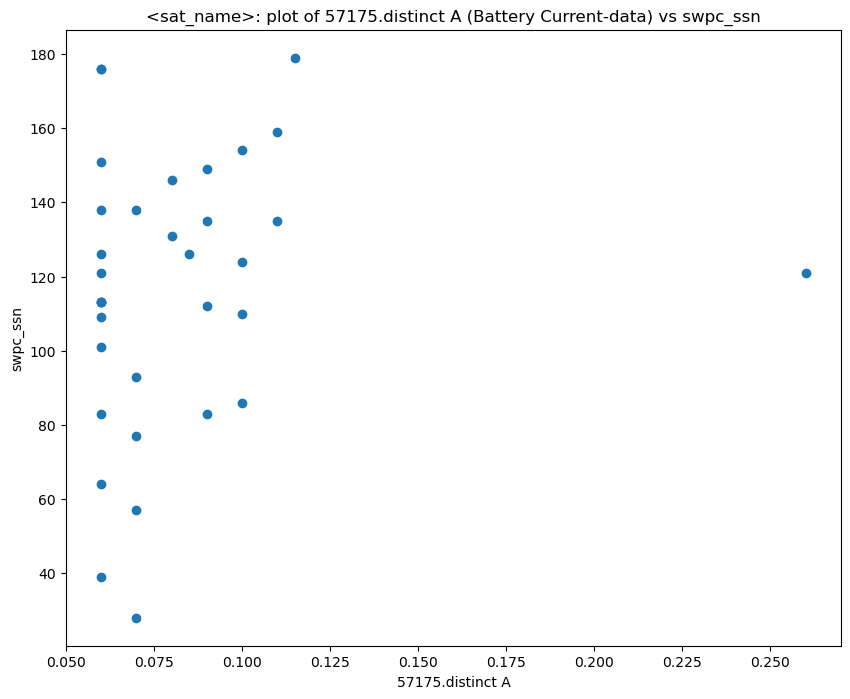

2024-02-11 17:44:57,377 - DEBUG - Processing file: ../data/cubebel-2/Battery Voltage-data-2024-02-11 02 21 49.csv


+---------+--------------------+------------+
|         |   57175.distinct V |   swpc_ssn |
|---------+--------------------+------------|
| count   |          35        |  35        |
| mean    |           4.82371  | 116.771    |
| std     |           0.1873   |  36.4805   |
| min     |           3.885    |  28        |
| 25%     |           4.825    |  97        |
| 50%     |           4.88     | 121        |
| 75%     |           4.885    | 138        |
| max     |           4.905    | 179        |
| Chi2    |         289.722    | 289.722    |
| P-value |           0.654382 |   0.654382 |
+---------+--------------------+------------+
Correlation [57175.distinct V] vs [swpc_ssn]: pearson=[-0.08447683572570787], spearman=[-0.326314095680748], kendal_tau=[-0.24234588591919806]


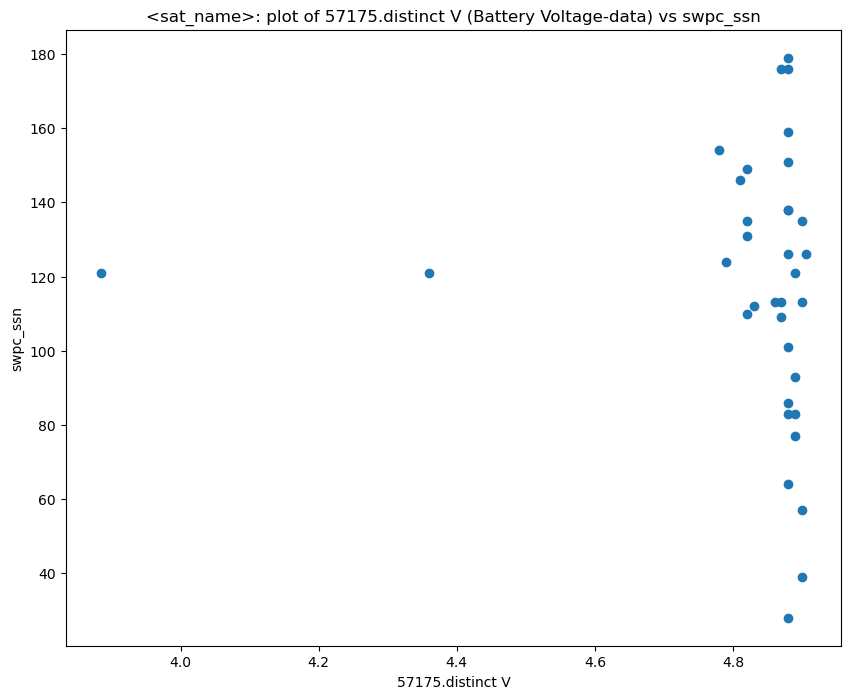

2024-02-11 17:44:57,520 - DEBUG - Processing file: ../data/cubebel-2/Digipeater -data-2024-02-11 02 22 48.csv
2024-02-11 17:44:57,540 - DEBUG - Processing file: ../data/cubebel-2/Ground Stations Leaderboard By Observed Frames-data-2024-02-11 02 21 28.csv


+---------+------------+------------+
|         |      9V1KG |   swpc_ssn |
|---------+------------+------------|
| count   |  1449      |  1449      |
| mean    |    14.0242 |    62.7481 |
| std     |    42.9915 |    52.0369 |
| min     |     0      |     0      |
| 25%     |     0      |    14      |
| 50%     |     0      |    52      |
| 75%     |     0      |   101      |
| max     |   230      |   227      |
| Chi2    | 26171.5    | 26171.5    |
| P-value |     0      |     0      |
+---------+------------+------------+
Correlation [9V1KG] vs [swpc_ssn]: pearson=[0.314838698950454], spearman=[0.4074446470220524], kendal_tau=[0.32326963017393173]


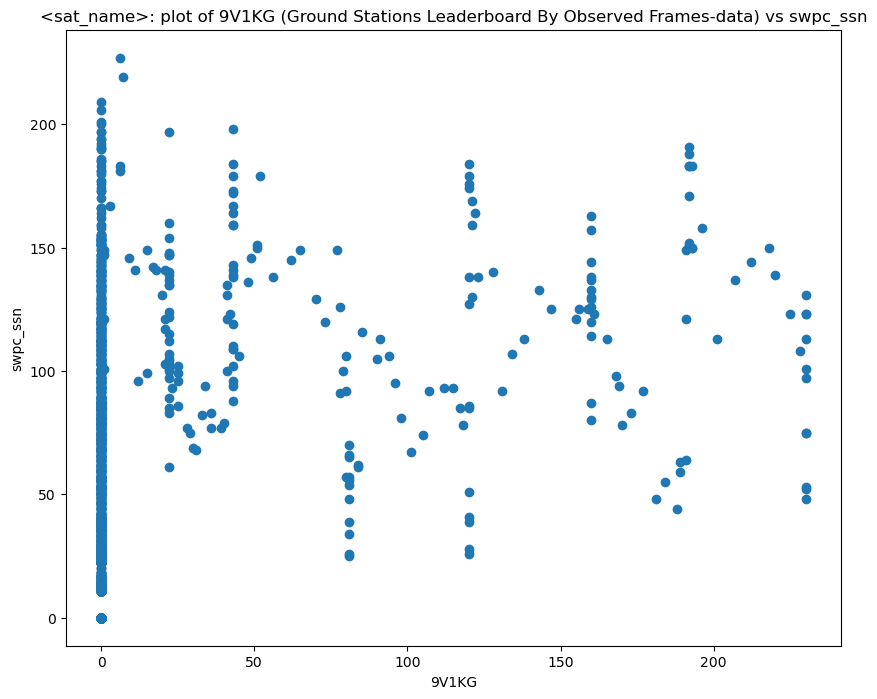

2024-02-11 17:44:57,688 - DEBUG - Processing file: ../data/cubebel-2/Last Frame Rcvd By-data-2024-02-11 02 21 23.csv
2024-02-11 17:44:57,707 - DEBUG - Processing file: ../data/cubebel-2/Last Frame Time-data-2024-02-11 02 22 52.csv
2024-02-11 17:44:57,744 - DEBUG - Processing file: ../data/cubebel-2/Last Message-data-2024-02-11 02 22 16.csv
2024-02-11 17:44:57,762 - DEBUG - Processing file: ../data/cubebel-2/MB Uptime-data-2024-02-11 02 22 39.csv


[Last Frame Rcvd By-data]: skipping column=[observer where 0 is VK5KJP-UHF-PF95gd]: not enough unique values.
[Last Frame Time-data]: skipping column=[57175.ctl]: not enough unique values.
+---------+---------------------+--------------+
|         |   57175.tlm_mb_time |     swpc_ssn |
|---------+---------------------+--------------|
| count   |          224        |   224        |
| mean    |        33303        |   115.875    |
| std     |        12234.4      |    39.7821   |
| min     |          570        |    25        |
| 25%     |        25776.2      |    88.75     |
| 50%     |        34071.2      |   119        |
| 75%     |        40542.5      |   142.25     |
| max     |        60800        |   227        |
| Chi2    |        26801.6      | 26801.6      |
| P-value |            0.241472 |     0.241472 |
+---------+---------------------+--------------+
Correlation [57175.tlm_mb_time] vs [swpc_ssn]: pearson=[-0.03920938837919507], spearman=[-0.0218143563391009], kendal_tau=[-0

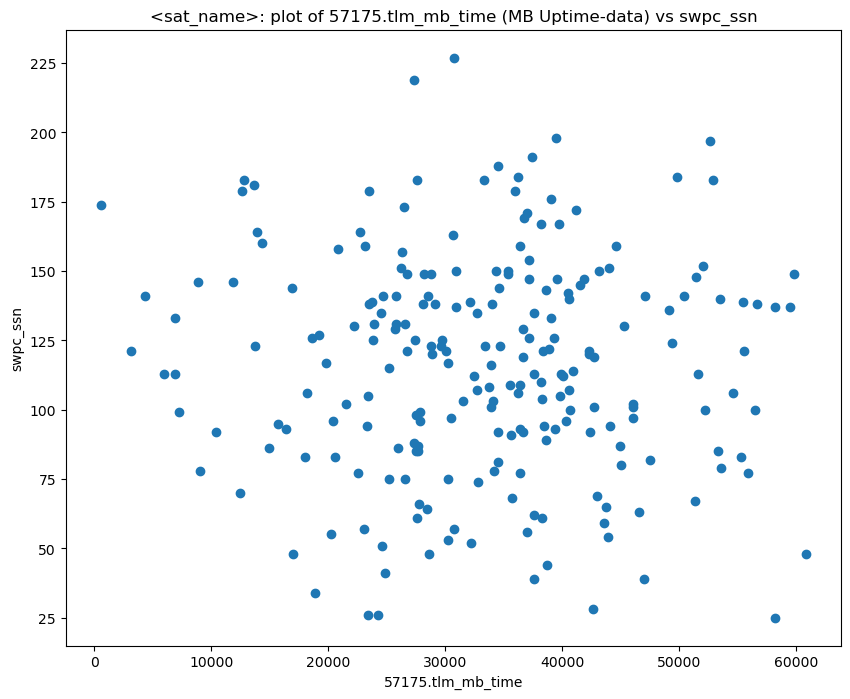

2024-02-11 17:44:57,923 - DEBUG - Processing file: ../data/cubebel-2/Resets-data-2024-02-11 02 22 26.csv


+---------+--------------------------+--------------+
|         |   beacon_reset_total_cnt |     swpc_ssn |
|---------+--------------------------+--------------|
| count   |               225        |   225        |
| mean    |               127.207    |   115.973    |
| std     |                43.5454   |    39.7206   |
| min     |                22.5      |    25        |
| 25%     |                93        |    89        |
| 50%     |               131        |   119        |
| 75%     |               159.5      |   142        |
| max     |               218        |   227        |
| Chi2    |             17325.6      | 17325.6      |
| P-value |                 0.850524 |     0.850524 |
+---------+--------------------------+--------------+
Correlation [beacon_reset_total_cnt] vs [swpc_ssn]: pearson=[0.06291851285053665], spearman=[0.048072551536734835], kendal_tau=[0.0319259705060527]


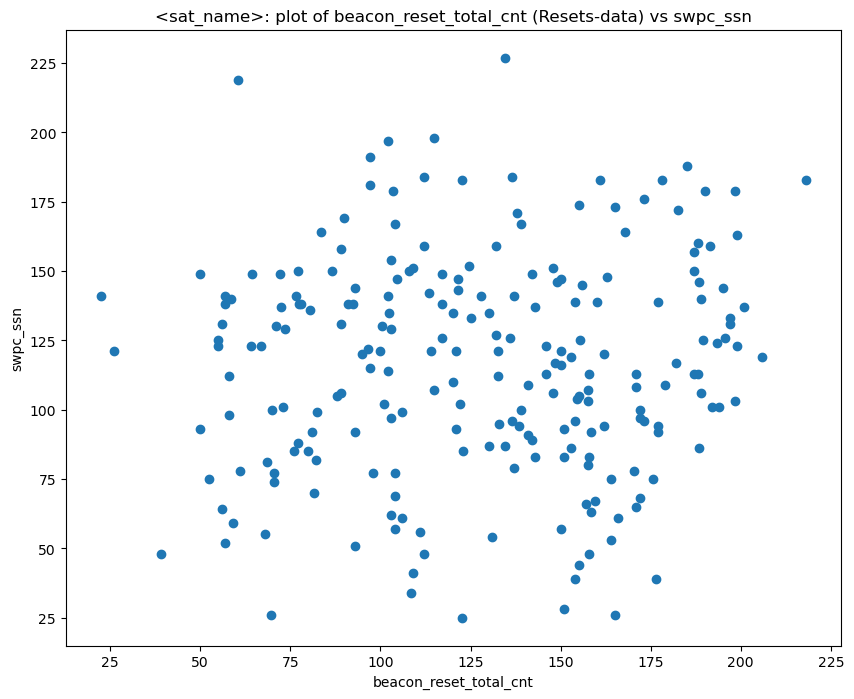

2024-02-11 17:44:58,123 - DEBUG - Processing file: ../data/cubebel-2/Sat Time-data-2024-02-11 02 22 43.csv


+---------+----------------------------------+--------------+
|         |   57175.tlm_trx_cmn_rtc_unixtime |     swpc_ssn |
|---------+----------------------------------+--------------|
| count   |                    225           |   225        |
| mean    |                      1.69403e+12 |   115.973    |
| std     |                      3.22324e+09 |    39.7206   |
| min     |                      1.68429e+12 |    25        |
| 25%     |                      1.69194e+12 |    89        |
| 50%     |                      1.69433e+12 |   119        |
| 75%     |                      1.69664e+12 |   142        |
| max     |                      1.69907e+12 |   227        |
| Chi2    |                  27000           | 27000        |
| P-value |                      0.301652    |     0.301652 |
+---------+----------------------------------+--------------+
Correlation [57175.tlm_trx_cmn_rtc_unixtime] vs [swpc_ssn]: pearson=[-0.13889752612342934], spearman=[-0.09706790264121769], kendal_

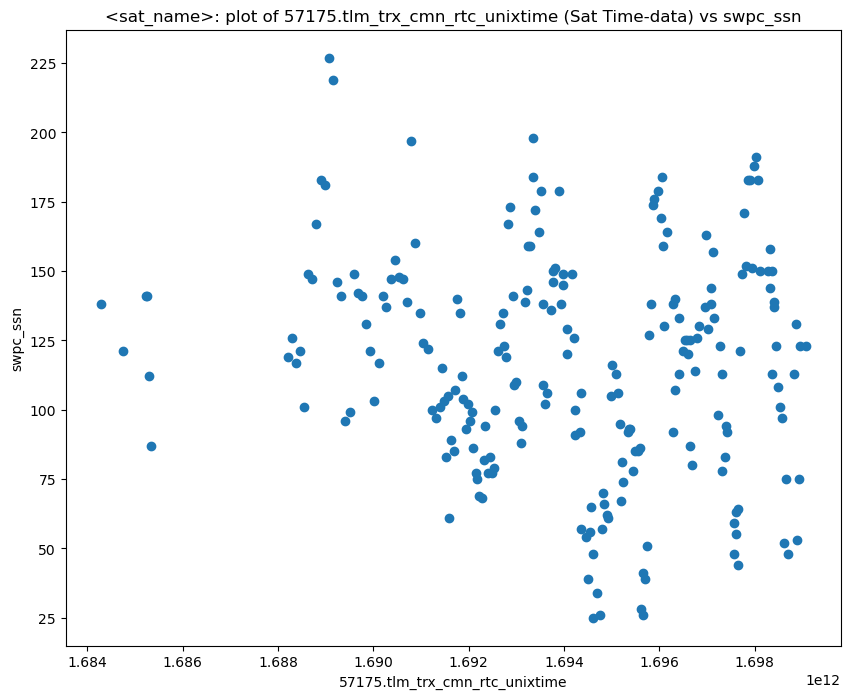

2024-02-11 17:44:58,340 - DEBUG - Processing file: ../data/cubebel-2/Solar Panel Current-data-2024-02-11 02 22 37.csv


+---------+--------------------------------------+--------------+
|         |   tlm_mb_solarpanel_1_current(mA) mA |     swpc_ssn |
|---------+--------------------------------------+--------------|
| count   |                           224        |   224        |
| mean    |                            88.733    |   115.875    |
| std     |                           108.417    |    39.7821   |
| min     |                             2.4      |    25        |
| 25%     |                            20        |    88.75     |
| 50%     |                            30        |   119        |
| 75%     |                           125.875    |   142.25     |
| max     |                           460        |   227        |
| Chi2    |                         15657.9      | 15657.9      |
| P-value |                             0.635742 |     0.635742 |
+---------+--------------------------------------+--------------+
Correlation [tlm_mb_solarpanel_1_current(mA) mA] vs [swpc_ssn]: pearson=[0.2

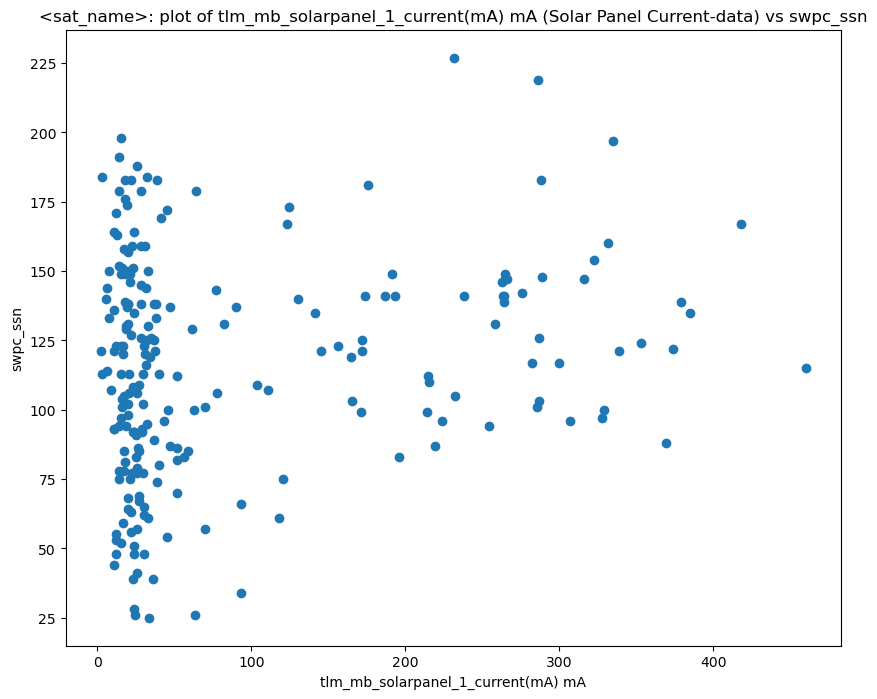

2024-02-11 17:44:58,527 - DEBUG - Processing file: ../data/cubebel-2/Solar Panel Temperatures-data-2024-02-11 02 22 03.csv


+---------+----------------------------------+--------------+
|         |   tlm_mb_solartemp_0_temp_0 (°C) |     swpc_ssn |
|---------+----------------------------------+--------------|
| count   |                       224        |   224        |
| mean    |                        13.2554   |   115.875    |
| std     |                        27.681    |    39.7821   |
| min     |                         3.9      |    25        |
| 25%     |                         8.075    |    88.75     |
| 50%     |                         9.9      |   119        |
| 75%     |                        12        |   142.25     |
| max     |                       251        |   227        |
| Chi2    |                     11152.9      | 11152.9      |
| P-value |                         0.223198 |     0.223198 |
+---------+----------------------------------+--------------+
Correlation [tlm_mb_solartemp_0_temp_0 (°C)] vs [swpc_ssn]: pearson=[0.03439559144282096], spearman=[-0.06737836516699401], kendal_t

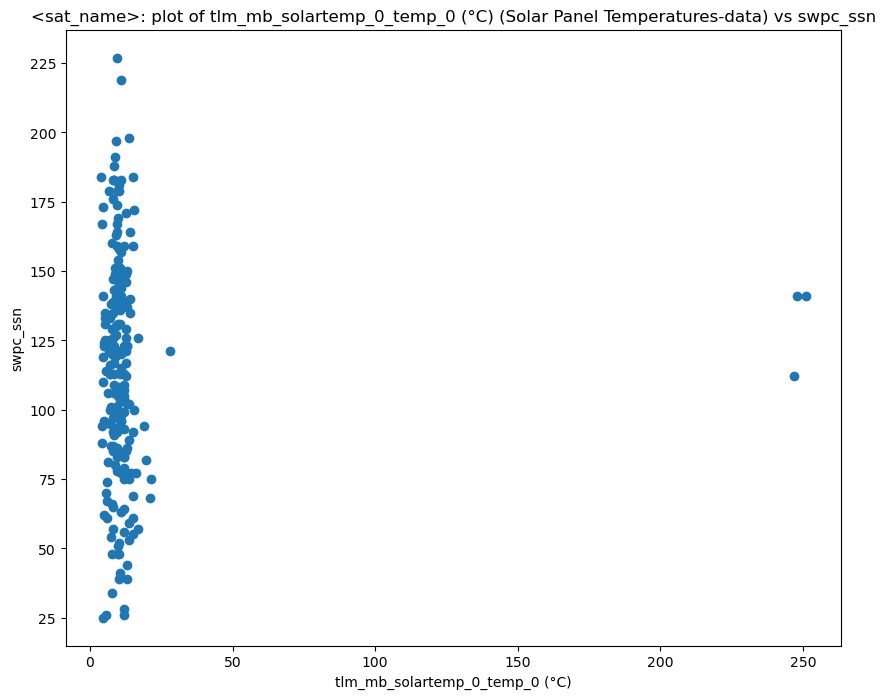

In [44]:
analyze_satellite('cubebel-2')

2024-02-11 17:44:58,718 - DEBUG - Processing file: ../data/delfi-pq/Currents-data-2024-02-11 02 21 52.csv


+---------+-------------+-------------+
|         |     Current |    swpc_ssn |
|---------+-------------+-------------|
| count   |  706        |  706        |
| mean    |   40.6091   |   99.2663   |
| std     |    8.41967  |   41.7192   |
| min     |   30        |    0        |
| 25%     |   33        |   68.25     |
| 50%     |   38        |   97        |
| 75%     |   52        |  129        |
| max     |   64        |  227        |
| Chi2    | 3007.58     | 3007.58     |
| P-value |    0.747084 |    0.747084 |
+---------+-------------+-------------+
Correlation [Current] vs [swpc_ssn]: pearson=[-0.04249925894302116], spearman=[-0.0580247347444164], kendal_tau=[-0.039862636061729]


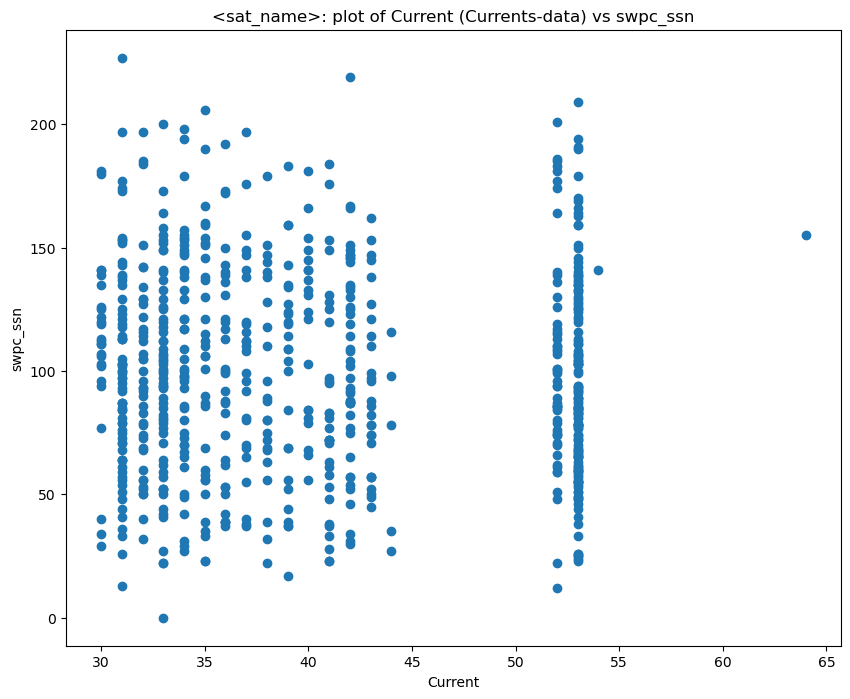

2024-02-11 17:44:58,931 - DEBUG - Processing file: ../data/delfi-pq/Last Frame Rcvd By-data-2024-02-11 02 21 45.csv
2024-02-11 17:44:58,955 - DEBUG - Processing file: ../data/delfi-pq/Solar Panel Currents-data-2024-02-11 02 22 09.csv


[Last Frame Rcvd By-data]: skipping column=[observer where 0 is VK4JBE-UHF-QG62mm]: not enough unique values.
+---------+-------------+-------------+
|         |     Cell Xm |    swpc_ssn |
|---------+-------------+-------------|
| count   |  689        |  689        |
| mean    |    5.83454  |  100.161    |
| std     |    8.85437  |   41.5395   |
| min     |    0        |    0        |
| 25%     |    0        |   69        |
| 50%     |    4        |   98        |
| 75%     |    6        |  130        |
| max     |   96        |  227        |
| Chi2    | 6133.36     | 6133.36     |
| P-value |    0.995063 |    0.995063 |
+---------+-------------+-------------+
Correlation [Cell Xm] vs [swpc_ssn]: pearson=[0.09008220346801377], spearman=[0.052047479334271826], kendal_tau=[0.03794476984513911]


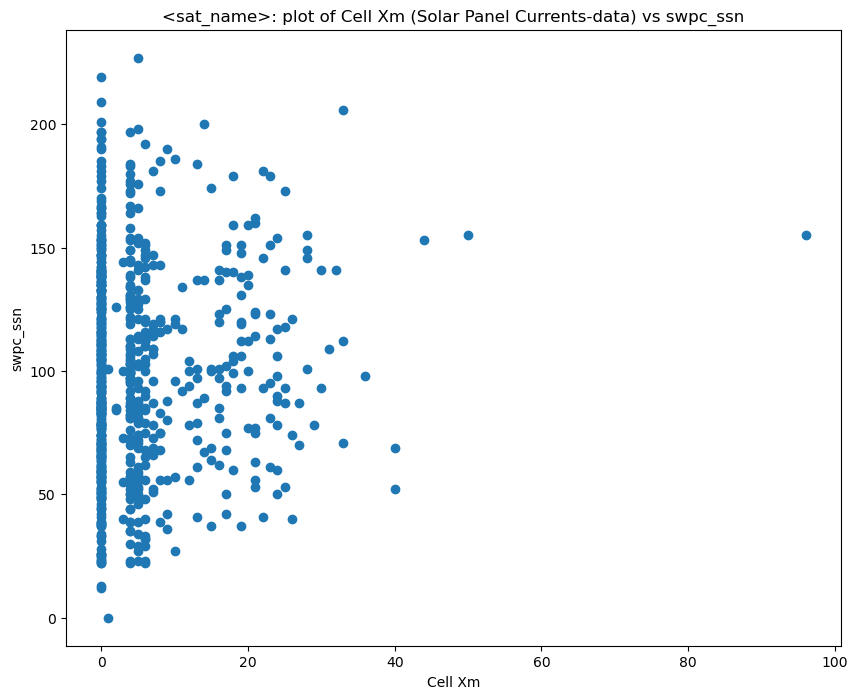

2024-02-11 17:44:59,135 - DEBUG - Processing file: ../data/delfi-pq/Solar Panel Voltages-data-2024-02-11 02 22 03.csv


+---------+-----------------+--------------+
|         |   Cell Xp V (m) |     swpc_ssn |
|---------+-----------------+--------------|
| count   |      689        |   689        |
| mean    |      125.039    |   100.161    |
| std     |      189.481    |    41.5395   |
| min     |        0        |     0        |
| 25%     |        2.663    |    69        |
| 50%     |        2.837    |    98        |
| 75%     |      288        |   130        |
| max     |      703        |   227        |
| Chi2    |    62339.7      | 62339.7      |
| P-value |        0.999946 |     0.999946 |
+---------+-----------------+--------------+
Correlation [Cell Xp V (m)] vs [swpc_ssn]: pearson=[-0.03633990530352432], spearman=[0.016694089927088453], kendal_tau=[0.01117614978022468]


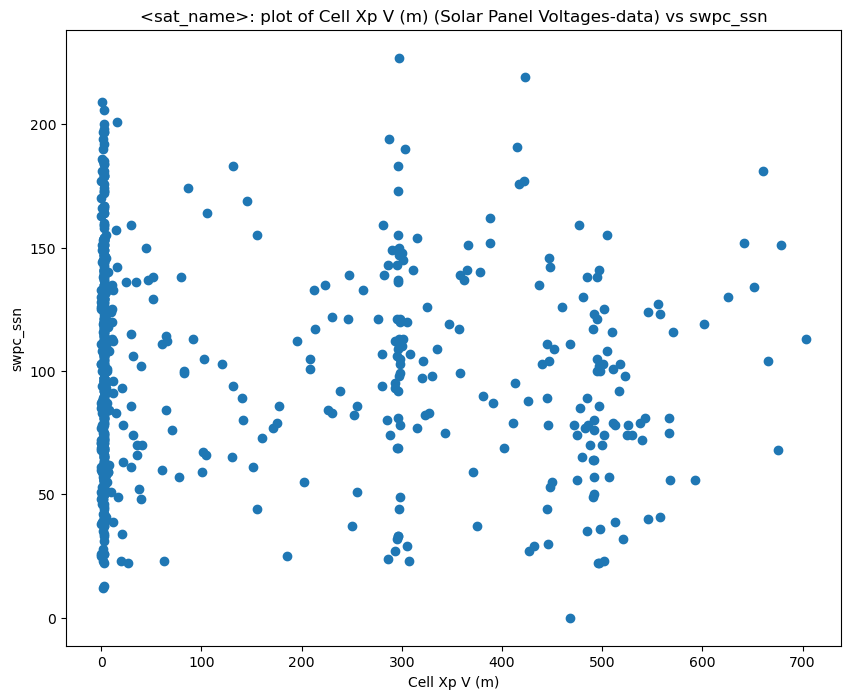

2024-02-11 17:44:59,375 - DEBUG - Processing file: ../data/delfi-pq/System Temperatures (C)-data-2024-02-11 02 21 56.csv


+---------+-------------+-------------+
|         |        Temp |    swpc_ssn |
|---------+-------------+-------------|
| count   |  706        |  706        |
| mean    |   -1.70751  |   99.2663   |
| std     |    5.85546  |   41.7192   |
| min     |  -17        |    0        |
| 25%     |   -6        |   68.25     |
| 50%     |   -3        |   97        |
| 75%     |    1.9      |  129        |
| max     |   25        |  227        |
| Chi2    | 7292.5      | 7292.5      |
| P-value |    0.101551 |    0.101551 |
+---------+-------------+-------------+
Correlation [Temp] vs [swpc_ssn]: pearson=[-0.0486885209969075], spearman=[-0.06346565557009469], kendal_tau=[-0.04403388828312254]


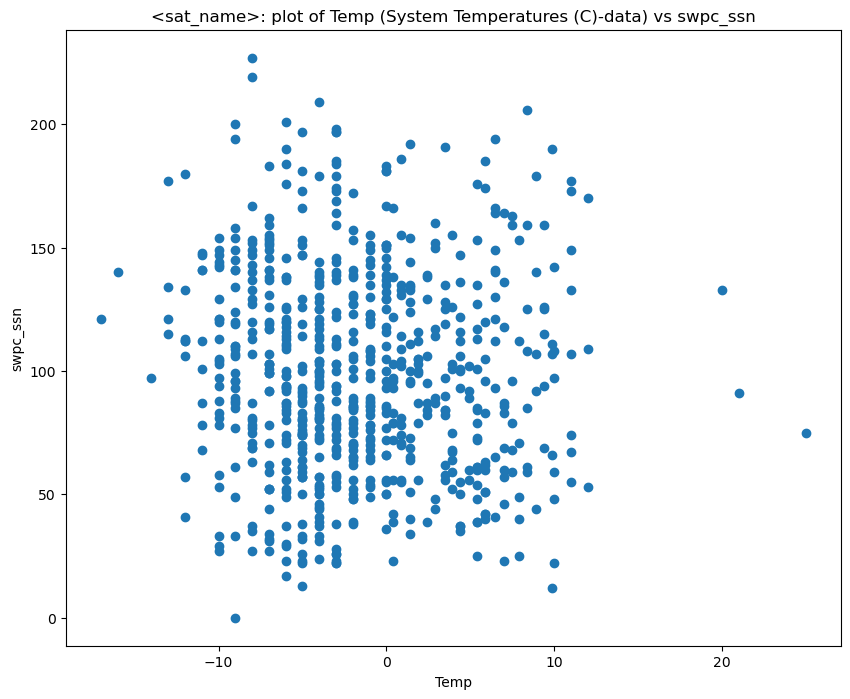

In [45]:
analyze_satellite('delfi-pq')

2024-02-11 17:44:59,553 - DEBUG - Processing file: ../data/dhabisat/Altitude-data-2024-02-11 02 22 19.csv
2024-02-11 17:44:59,577 - DEBUG - Processing file: ../data/dhabisat/ECEF Position-data-2024-02-11 02 22 26.csv
2024-02-11 17:44:59,603 - DEBUG - Processing file: ../data/dhabisat/Estimated Angular Rates-data-2024-02-11 02 21 39.csv
2024-02-11 17:44:59,623 - DEBUG - Processing file: ../data/dhabisat/Estimated Quaternions-data-2024-02-11 02 21 45.csv


[Altitude-data]: skipping column=[Altitute]: not enough unique values.
[ECEF Position-data]: skipping column=[ECEF Position X]: not enough unique values.
[Estimated Angular Rates-data]: skipping column=[Estimated X Angular Rate]: not enough unique values.


2024-02-11 17:44:59,645 - DEBUG - Processing file: ../data/dhabisat/Estimated Roll_Pitch_Yaw-data-2024-02-11 02 21 49.csv
2024-02-11 17:44:59,666 - DEBUG - Processing file: ../data/dhabisat/Latitude _ Longitude-data-2024-02-11 02 22 08.csv


[Estimated Quaternions-data]: skipping column=[Estimated Q1]: not enough unique values.
[Estimated Roll_Pitch_Yaw-data]: skipping column=[Estimated Roll Angle]: not enough unique values.
+---------+--------------+-------------+
|         |     Latitude |    swpc_ssn |
|---------+--------------+-------------|
| count   |  813         |  813        |
| mean    |   -0.0888069 |   85.7737   |
| std     |    5.35241   |   46.1452   |
| min     |  -52         |    0        |
| 25%     |    0         |   50        |
| 50%     |    0         |   83        |
| 75%     |    0         |  118        |
| max     |   52         |  227        |
| Chi2    | 2327.24      | 2327.24     |
| P-value |    0.914671  |    0.914671 |
+---------+--------------+-------------+
Correlation [Latitude] vs [swpc_ssn]: pearson=[0.011348841236622083], spearman=[0.008718167262398864], kendal_tau=[0.0070558541329502214]


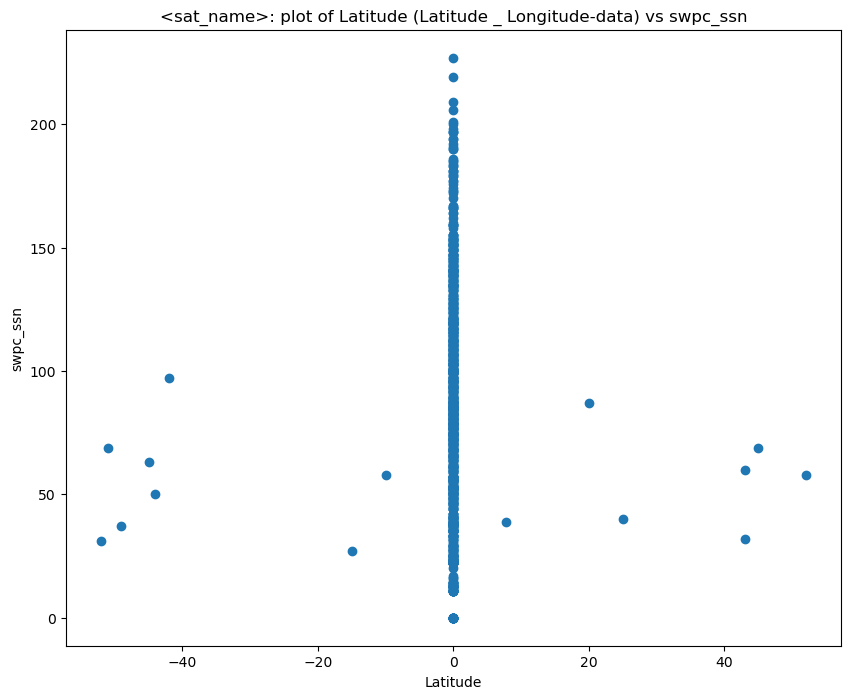

2024-02-11 17:44:59,823 - DEBUG - Processing file: ../data/dhabisat/Position-data-2024-02-11 02 22 03.csv


+---------+---------------+-------------+
|         |    X Position |    swpc_ssn |
|---------+---------------+-------------|
| count   |    813        |  813        |
| mean    |   -106.13     |   85.7737   |
| std     |   2025.61     |   46.1452   |
| min     | -20977        |    0        |
| 25%     |     -1        |   50        |
| 50%     |     -1        |   83        |
| 75%     |     -1        |  118        |
| max     |  19143        |  227        |
| Chi2    |   2599.58     | 2599.58     |
| P-value |      0.989339 |    0.989339 |
+---------+---------------+-------------+
Correlation [X Position] vs [swpc_ssn]: pearson=[0.060327606291762446], spearman=[0.05192124471827751], kendal_tau=[0.04238704393286187]


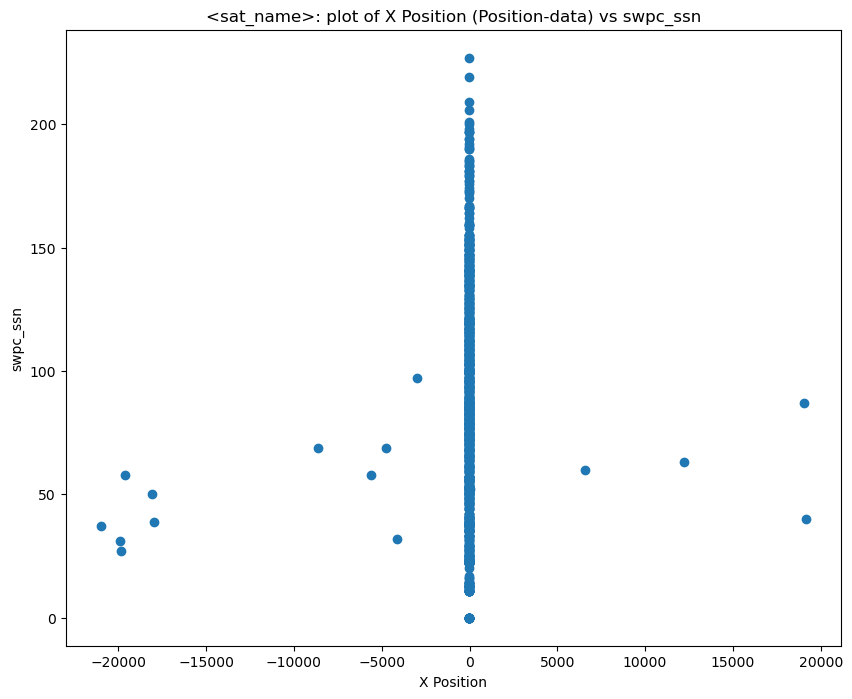

2024-02-11 17:45:00,041 - DEBUG - Processing file: ../data/dhabisat/Power-data-2024-02-11 02 21 51.csv
2024-02-11 17:45:00,067 - DEBUG - Processing file: ../data/dhabisat/Velocity-data-2024-02-11 02 22 12.csv


[Power-data]: skipping column=[49016.mode OFF (ON)]: not enough unique values.
+---------+---------------+-------------+
|         |    X Velocity |    swpc_ssn |
|---------+---------------+-------------|
| count   |    813        |  813        |
| mean    |    -31.3124   |   85.7737   |
| std     |   3445.97     |   46.1452   |
| min     | -32678        |    0        |
| 25%     |     -1        |   50        |
| 50%     |     -1        |   83        |
| 75%     |     -1        |  118        |
| max     |  31170        |  227        |
| Chi2    |   2450.53     | 2450.53     |
| P-value |      0.979054 |    0.979054 |
+---------+---------------+-------------+
Correlation [X Velocity] vs [swpc_ssn]: pearson=[0.0031158731313645966], spearman=[-0.022588323767765865], kendal_tau=[-0.018300709156814327]


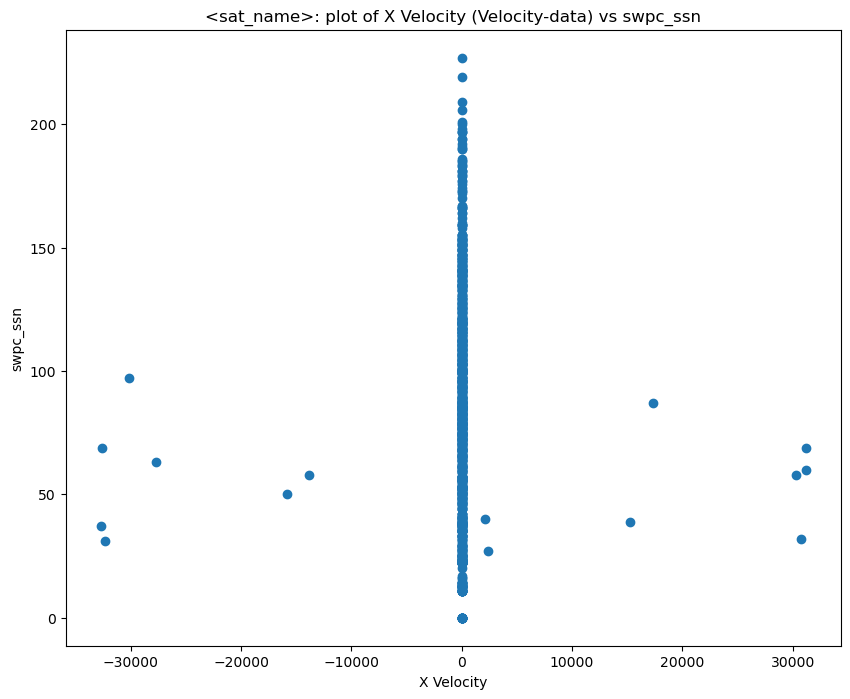

2024-02-11 17:45:00,216 - DEBUG - Processing file: ../data/dhabisat/Wheel Speeds-data-2024-02-11 02 21 57.csv


[Wheel Speeds-data]: skipping column=[X Wheel Speed]: not enough unique values.


In [46]:
analyze_satellite('dhabisat')

2024-02-11 17:45:00,243 - DEBUG - Processing file: ../data/geoscan-edelveis/-data-2024-02-11 02 21 37.csv


+---------+-------------------------+--------------+
|         |   Batteries Voltage.1 V |     swpc_ssn |
|---------+-------------------------+--------------|
| count   |              448        |   448        |
| mean    |                5.4981   |   115.52     |
| std     |                3.49636  |    40.1737   |
| min     |                0.03     |    12        |
| 25%     |                0.033    |    87        |
| 50%     |                7.3855   |   114        |
| 75%     |                8.059    |   142        |
| max     |                8.3595   |   227        |
| Chi2    |            33508.3      | 33508.3      |
| P-value |                0.995527 |     0.995527 |
+---------+-------------------------+--------------+
Correlation [Batteries Voltage.1 V] vs [swpc_ssn]: pearson=[0.036143361932609225], spearman=[0.030006195647520932], kendal_tau=[0.020395238659781757]


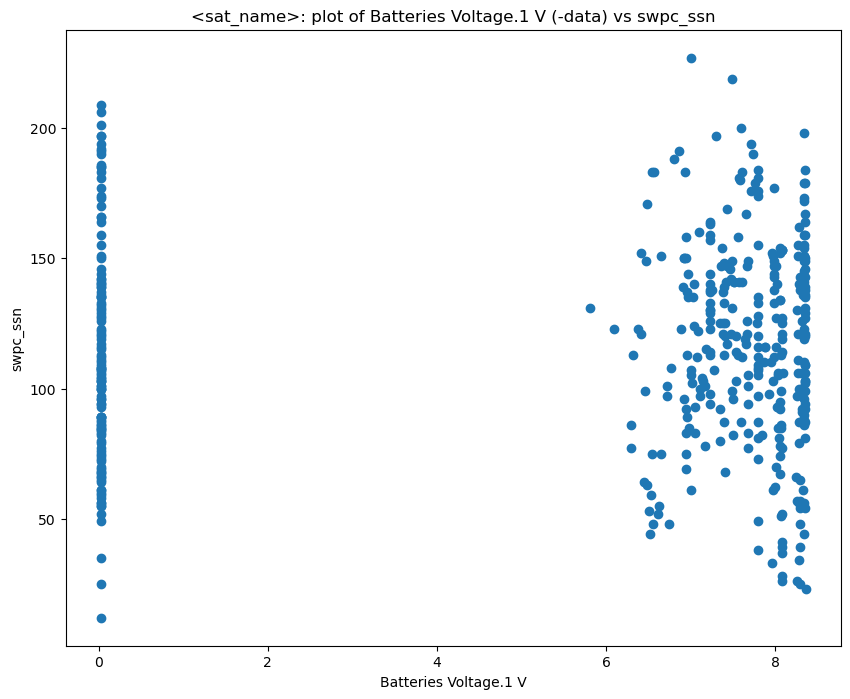

2024-02-11 17:45:00,417 - DEBUG - Processing file: ../data/geoscan-edelveis/Callsign-data-2024-02-11 02 21 40.csv
2024-02-11 17:45:00,469 - DEBUG - Processing file: ../data/geoscan-edelveis/Msg Type-data-2024-02-11 02 21 43.csv
2024-02-11 17:45:00,487 - DEBUG - Processing file: ../data/geoscan-edelveis/Voltage of all Batteries-data-2024-02-11 02 21 34.csv


[Voltage of all Batteries-data]: skipping column=[Battery Voltage V]: not enough unique values.


In [47]:
analyze_satellite('geoscan-edelveis')

2024-02-11 17:45:00,515 - DEBUG - Processing file: ../data/grbalpha/COM MCU temperature in °C-data-2024-02-11 02 23 54.csv


+---------+------------------+------------+
|         |   47959.temp_cpu |   swpc_ssn |
|---------+------------------+------------|
| count   |        879       |  879       |
| mean    |         16.6726  |   79.2673  |
| std     |          4.08236 |   46.0523  |
| min     |          2.9     |    0       |
| 25%     |         15       |   40       |
| 50%     |         17       |   77       |
| 75%     |         18       |  112       |
| max     |         42       |  209       |
| Chi2    |       9080.87    | 9080.87    |
| P-value |          0.15311 |    0.15311 |
+---------+------------------+------------+
Correlation [47959.temp_cpu] vs [swpc_ssn]: pearson=[0.19583528814101045], spearman=[0.11874665779294377], kendal_tau=[0.08426372624567413]


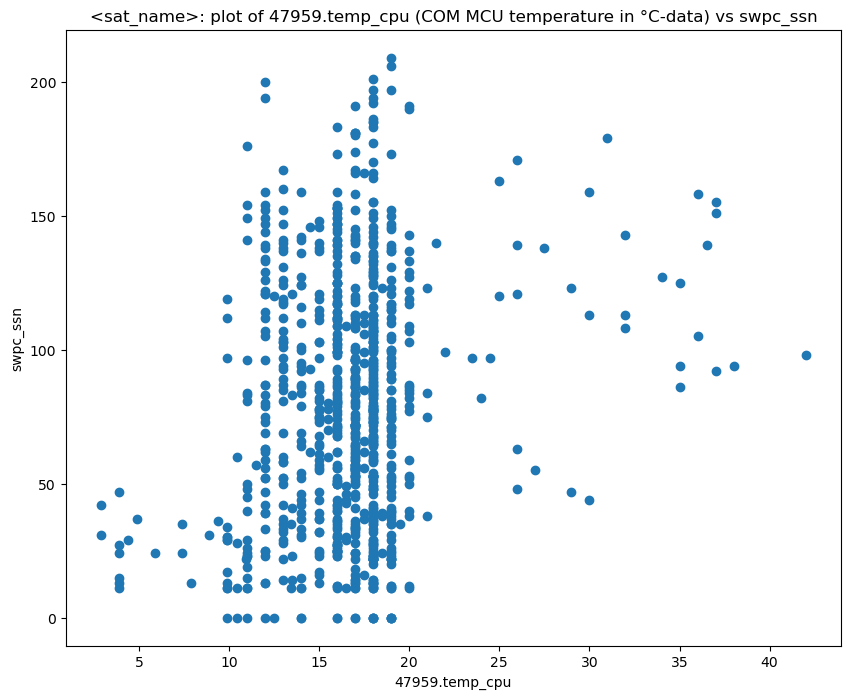

2024-02-11 17:45:00,703 - DEBUG - Processing file: ../data/grbalpha/COM RF received-data-2024-02-11 02 23 14.csv


+---------+-----------------------------+------------------+
|         |   47959.rf_packets_received |         swpc_ssn |
|---------+-----------------------------+------------------|
| count   |               879           |    879           |
| mean    |             23988.6         |     79.2673      |
| std     |             14579.6         |     46.0523      |
| min     |              3885           |      0           |
| 25%     |              6566.5         |     40           |
| 50%     |             26861           |     77           |
| 75%     |             37127.5         |    112           |
| max     |             46873           |    209           |
| Chi2    |            136849           | 136849           |
| P-value |                 6.95073e-07 |      6.95073e-07 |
+---------+-----------------------------+------------------+
Correlation [47959.rf_packets_received] vs [swpc_ssn]: pearson=[0.6552103398456955], spearman=[0.6812939707841996], kendal_tau=[0.4828091311396872

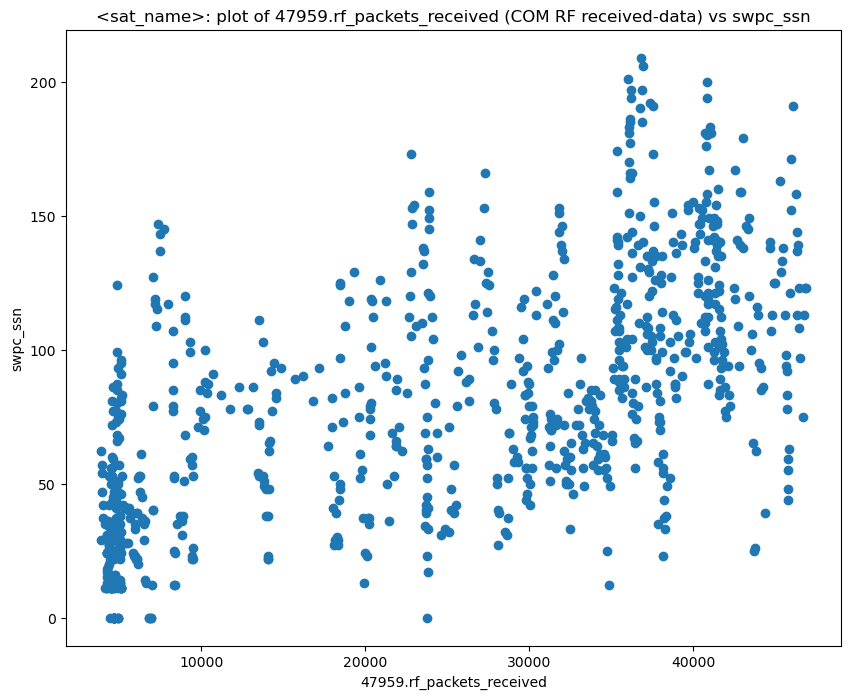

2024-02-11 17:45:00,884 - DEBUG - Processing file: ../data/grbalpha/COM RF transmitted-data-2024-02-11 02 23 35.csv


+---------+--------------------------------+---------------+
|         |   47959.rf_packets_transmitted |      swpc_ssn |
|---------+--------------------------------+---------------|
| count   |                  879           |    879        |
| mean    |                    1.95549e+06 |     79.2673   |
| std     |                    1.16048e+06 |     46.0523   |
| min     |               148470           |      0        |
| 25%     |                    1.03562e+06 |     40        |
| 50%     |                    1.63671e+06 |     77        |
| 75%     |                    2.7571e+06  |    112        |
| max     |                    4.8328e+06  |    209        |
| Chi2    |               151188           | 151188        |
| P-value |                    0.376736    |      0.376736 |
+---------+--------------------------------+---------------+
Correlation [47959.rf_packets_transmitted] vs [swpc_ssn]: pearson=[0.6278741335227254], spearman=[0.6812807774305079], kendal_tau=[0.4826457920364

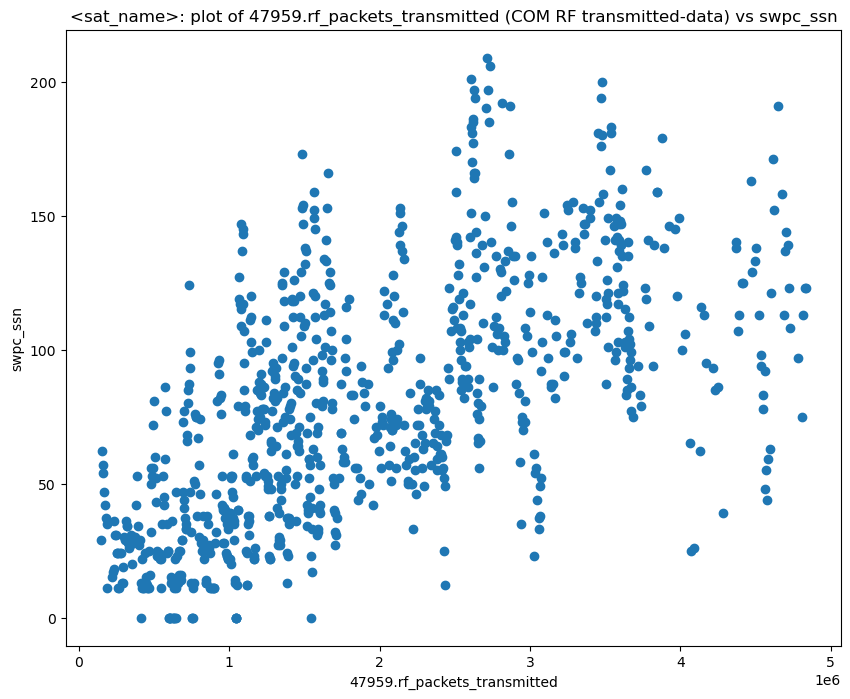

2024-02-11 17:45:01,079 - DEBUG - Processing file: ../data/grbalpha/Frame count-data-2024-02-11 02 24 54.csv
2024-02-11 17:45:01,098 - DEBUG - Processing file: ../data/grbalpha/OBC 9DOF temperature in °C-data-2024-02-11 02 25 27.csv


[Frame count-data]: skipping column=[47959.count]: not enough unique values.
+---------+----------------------+------------+
|         |   47959.obc_mpu_temp |   swpc_ssn |
|---------+----------------------+------------|
| count   |           1012       |  1012      |
| mean    |             10.8191  |    84.3458 |
| std     |              9.54471 |    47.5542 |
| min     |              0       |     0      |
| 25%     |              0       |    46      |
| 50%     |             15       |    82      |
| 75%     |             20       |   119.25   |
| max     |             28       |   227      |
| Chi2    |           4855.96    |  4855.96   |
| P-value |              1       |     1      |
+---------+----------------------+------------+
Correlation [47959.obc_mpu_temp] vs [swpc_ssn]: pearson=[0.013497454471777425], spearman=[0.0407576844159037], kendal_tau=[0.028140507841988457]


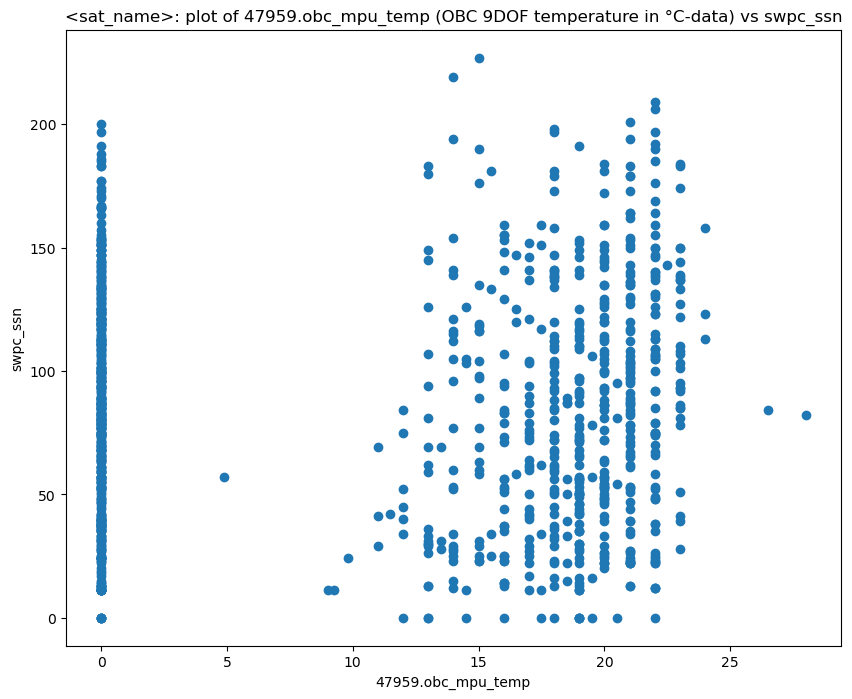

2024-02-11 17:45:01,333 - DEBUG - Processing file: ../data/grbalpha/OBC MCU temperature in °C-data-2024-02-11 02 25 11.csv


+---------+------------------+------------+
|         |   47959.obc_temp |   swpc_ssn |
|---------+------------------+------------|
| count   |       1012       |  1012      |
| mean    |         16.5183  |    84.3458 |
| std     |          2.87335 |    47.5542 |
| min     |          7.7     |     0      |
| 25%     |         15       |    46      |
| 50%     |         17       |    82      |
| 75%     |         19       |   119.25   |
| max     |         25       |   227      |
| Chi2    |       5667.97    |  5667.97   |
| P-value |          1       |     1      |
+---------+------------------+------------+
Correlation [47959.obc_temp] vs [swpc_ssn]: pearson=[0.13629544895903378], spearman=[0.13094092761767348], kendal_tau=[0.09183994173997309]


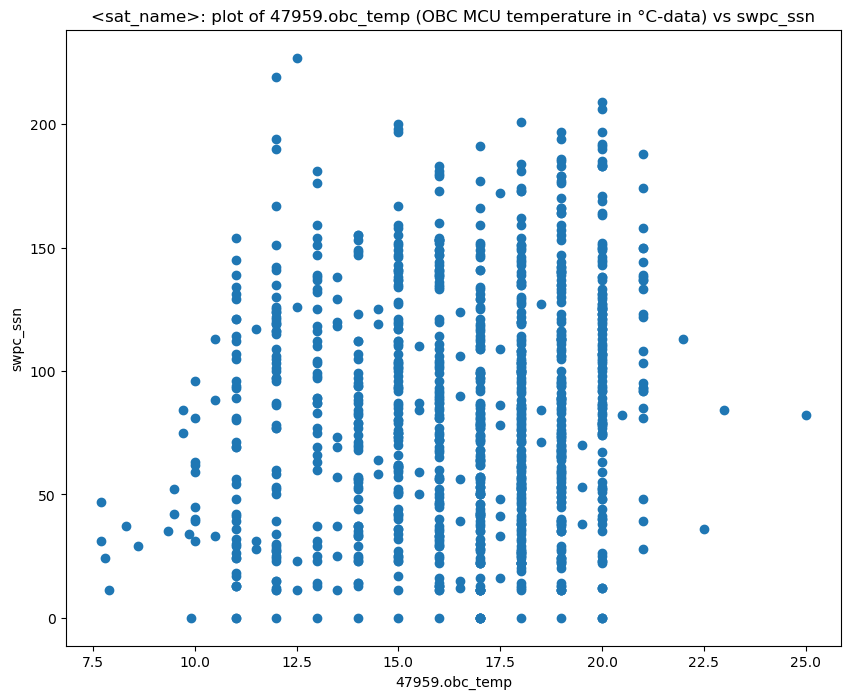

2024-02-11 17:45:01,565 - DEBUG - Processing file: ../data/grbalpha/OBC Uptime total-data-2024-02-11 02 26 28.csv


+---------+--------------------------+---------------+
|         |   47959.obc_uptime_total |      swpc_ssn |
|---------+--------------------------+---------------|
| count   |           1012           |   1012        |
| mean    |              4.61661e+07 |     84.3458   |
| std     |              2.52258e+07 |     47.5542   |
| min     |              2.40802e+06 |      0        |
| 25%     |              2.43341e+07 |     46        |
| 50%     |              4.61619e+07 |     82        |
| 75%     |              6.79935e+07 |    119.25     |
| max     |              8.98209e+07 |    227        |
| Chi2    |         183172           | 183172        |
| P-value |              0.382014    |      0.382014 |
+---------+--------------------------+---------------+
Correlation [47959.obc_uptime_total] vs [swpc_ssn]: pearson=[0.6417320382218976], spearman=[0.6564475957291203], kendal_tau=[0.4656836466869805]


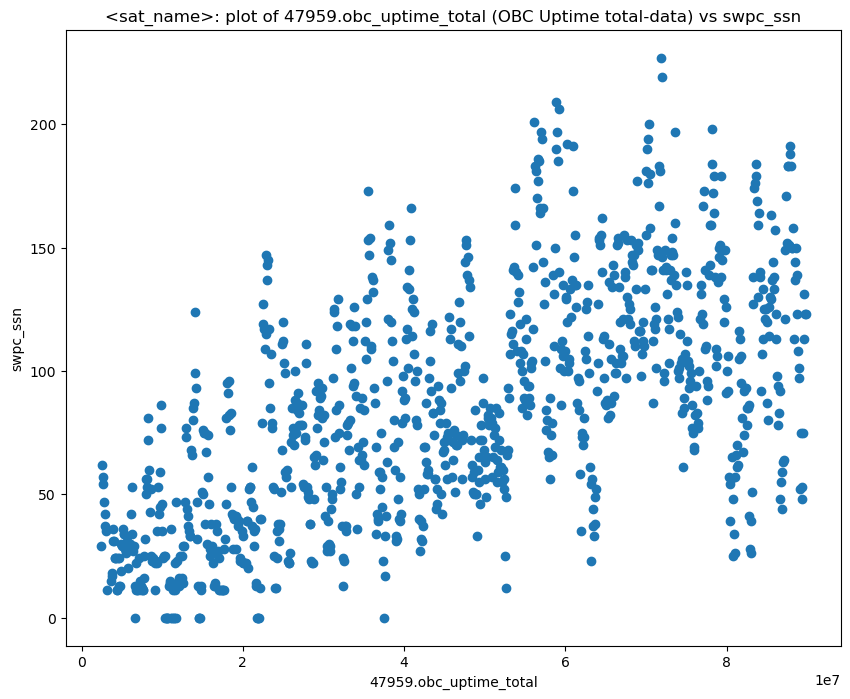

In [48]:
analyze_satellite('grbalpha')

2024-02-11 17:45:01,800 - DEBUG - Processing file: ../data/ledsat/Last Frame Rcvd By-data-2024-02-11 02 19 24.csv
2024-02-11 17:45:01,821 - DEBUG - Processing file: ../data/ledsat/Last Frame Rcvd By-data-2024-02-11 02 21 47.csv
2024-02-11 17:45:01,840 - DEBUG - Processing file: ../data/ledsat/Solar Panel Temperatures-data-2024-02-11 02 19 39.csv


+---------+------------------+-------------+
|         |   +X solar panel |    swpc_ssn |
|---------+------------------+-------------|
| count   |       403        |  403        |
| mean    |        -4.01228  |   75.2035   |
| std     |        13.9568   |   41.9554   |
| min     |       -28        |    0        |
| 25%     |       -18        |   39        |
| 50%     |        -2        |   75        |
| 75%     |         8.4      |  103        |
| max     |        26        |  184        |
| Chi2    |      9993.95     | 9993.95     |
| P-value |         0.998747 |    0.998747 |
+---------+------------------+-------------+
Correlation [+X solar panel] vs [swpc_ssn]: pearson=[-0.03952950465220578], spearman=[-0.014055204429377088], kendal_tau=[-0.008764757209664546]


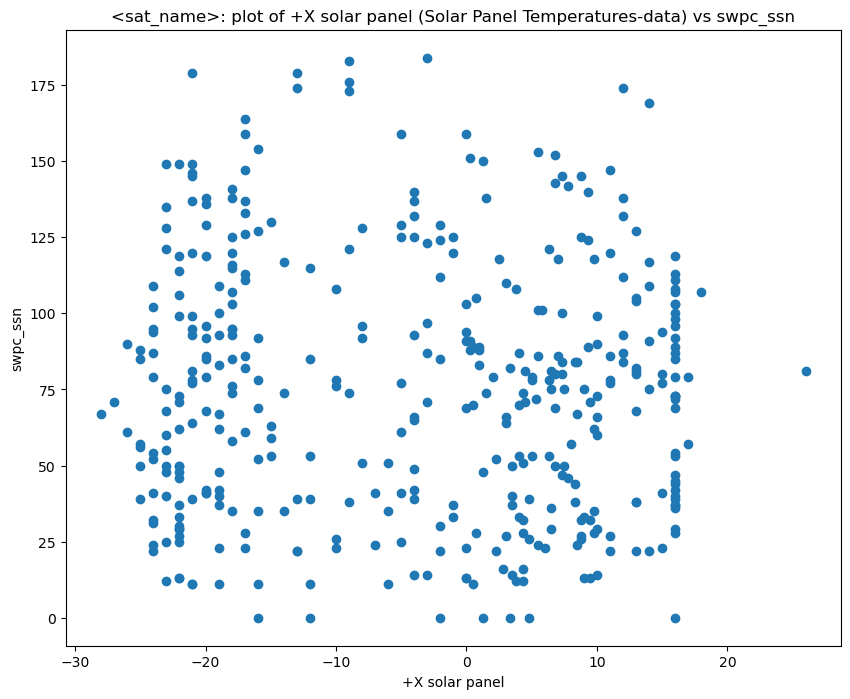

2024-02-11 17:45:01,997 - DEBUG - Processing file: ../data/ledsat/Solar Panel Temperatures-data-2024-02-11 02 22 03.csv


+---------+------------------+-------------+
|         |   +X solar panel |    swpc_ssn |
|---------+------------------+-------------|
| count   |       403        |  403        |
| mean    |        -4.01228  |   75.2035   |
| std     |        13.9568   |   41.9554   |
| min     |       -28        |    0        |
| 25%     |       -18        |   39        |
| 50%     |        -2        |   75        |
| 75%     |         8.4      |  103        |
| max     |        26        |  184        |
| Chi2    |      9993.95     | 9993.95     |
| P-value |         0.998747 |    0.998747 |
+---------+------------------+-------------+
Correlation [+X solar panel] vs [swpc_ssn]: pearson=[-0.03952950465220578], spearman=[-0.014055204429377088], kendal_tau=[-0.008764757209664546]


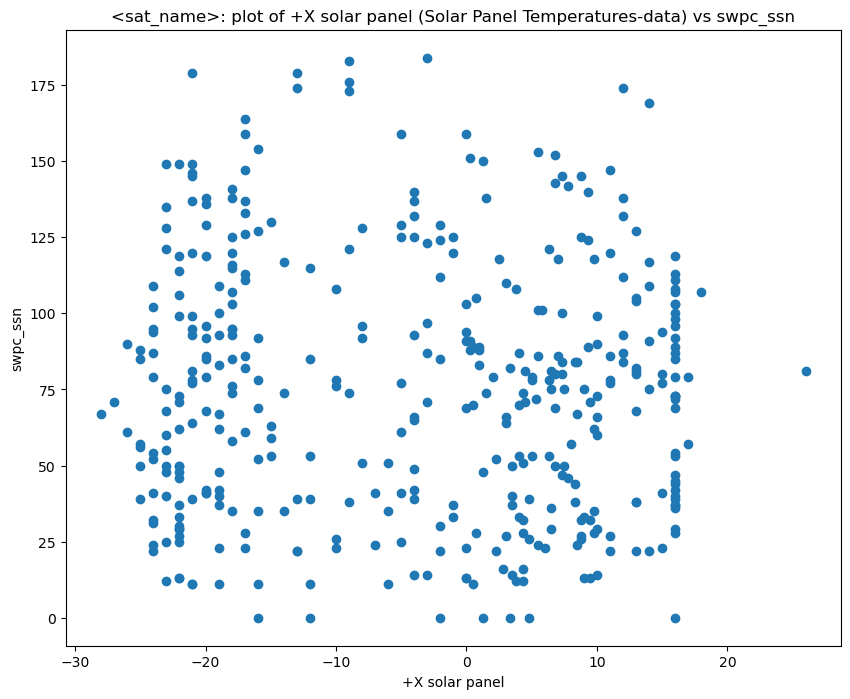

2024-02-11 17:45:02,157 - DEBUG - Processing file: ../data/ledsat/System Temperatures (C)-data-2024-02-11 02 19 34.csv


+---------+---------------+---------------+
|         |   MPPT X (°C) |      swpc_ssn |
|---------+---------------+---------------|
| count   |  403          |  403          |
| mean    |    2.15385    |   75.2035     |
| std     |    2.38176    |   41.9554     |
| min     |    0          |    0          |
| 25%     |    0          |   39          |
| 50%     |    2          |   75          |
| 75%     |    3          |  103          |
| max     |   15          |  184          |
| Chi2    | 1978.03       | 1978.03       |
| P-value |    0.00279515 |    0.00279515 |
+---------+---------------+---------------+
Correlation [MPPT X (°C)] vs [swpc_ssn]: pearson=[0.19803837403739197], spearman=[0.24113078533366528], kendal_tau=[0.1765768272482411]


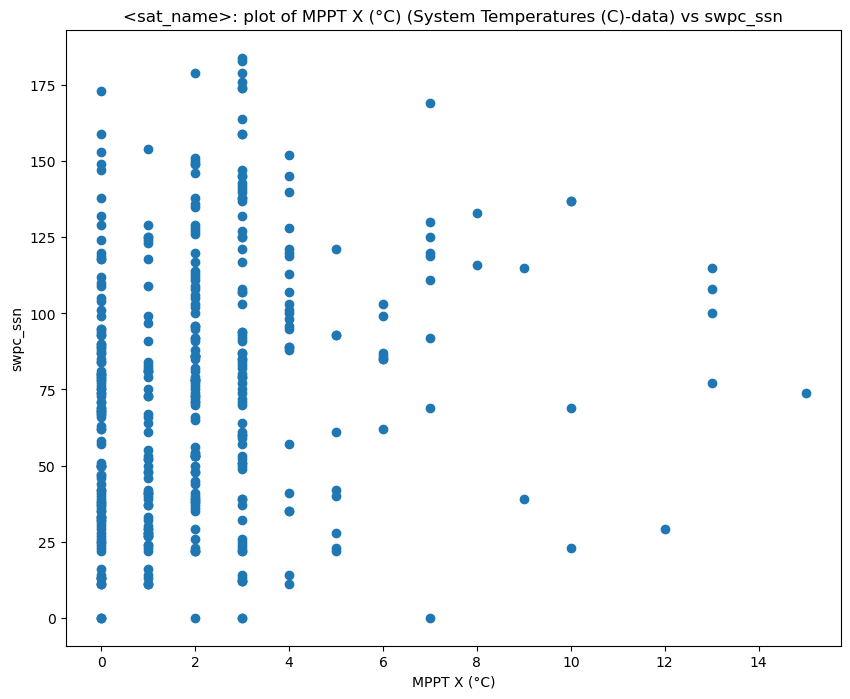

2024-02-11 17:45:02,318 - DEBUG - Processing file: ../data/ledsat/System Temperatures (C)-data-2024-02-11 02 21 57.csv


+---------+---------------+---------------+
|         |   MPPT X (°C) |      swpc_ssn |
|---------+---------------+---------------|
| count   |  403          |  403          |
| mean    |    2.15385    |   75.2035     |
| std     |    2.38176    |   41.9554     |
| min     |    0          |    0          |
| 25%     |    0          |   39          |
| 50%     |    2          |   75          |
| 75%     |    3          |  103          |
| max     |   15          |  184          |
| Chi2    | 1978.03       | 1978.03       |
| P-value |    0.00279515 |    0.00279515 |
+---------+---------------+---------------+
Correlation [MPPT X (°C)] vs [swpc_ssn]: pearson=[0.19803837403739197], spearman=[0.24113078533366528], kendal_tau=[0.1765768272482411]


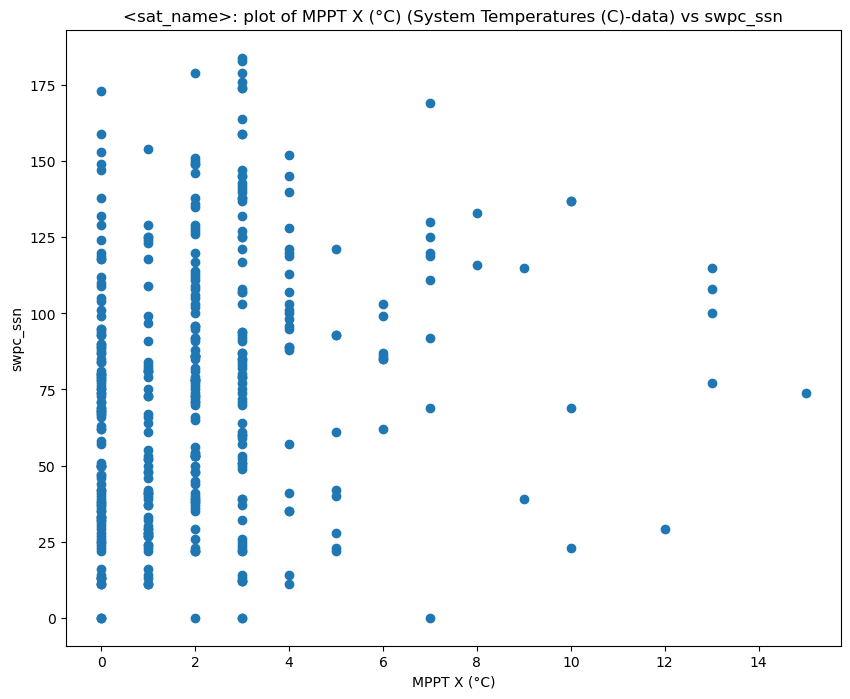

2024-02-11 17:45:02,478 - DEBUG - Processing file: ../data/ledsat/Temperatures-data-2024-02-11 02 19 22.csv


+---------+---------------+---------------+
|         |   X axis MPPT |      swpc_ssn |
|---------+---------------+---------------|
| count   |  403          |  403          |
| mean    |    2.15385    |   75.2035     |
| std     |    2.38176    |   41.9554     |
| min     |    0          |    0          |
| 25%     |    0          |   39          |
| 50%     |    2          |   75          |
| 75%     |    3          |  103          |
| max     |   15          |  184          |
| Chi2    | 1978.03       | 1978.03       |
| P-value |    0.00279515 |    0.00279515 |
+---------+---------------+---------------+
Correlation [X axis MPPT] vs [swpc_ssn]: pearson=[0.19803837403739197], spearman=[0.24113078533366528], kendal_tau=[0.1765768272482411]


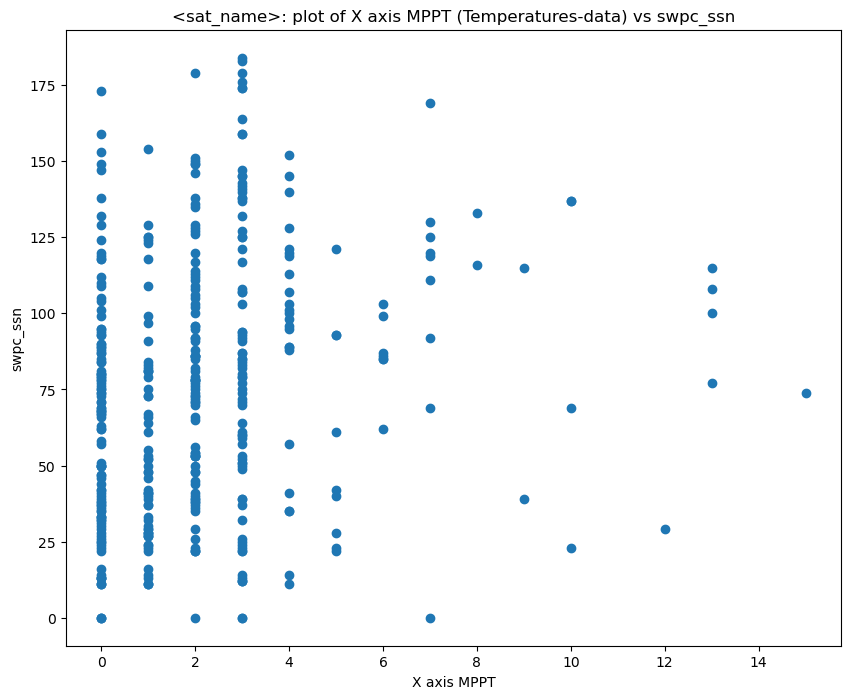

2024-02-11 17:45:02,661 - DEBUG - Processing file: ../data/ledsat/Voltages-data-2024-02-11 02 18 53.csv
2024-02-11 17:45:02,684 - DEBUG - Processing file: ../data/ledsat/Battery Current-data-2024-02-11 02 19 26.csv


[Voltages-data]: skipping column=[Battery Voltage V]: not enough unique values.
+---------+------------------------------------------+--------------+
|         |   Total current coming from solar panels |     swpc_ssn |
|---------+------------------------------------------+--------------|
| count   |                              403         |  403         |
| mean    |                               22.2258    |   75.2035    |
| std     |                               64.7521    |   41.9554    |
| min     |                                0         |    0         |
| 25%     |                                0         |   39         |
| 50%     |                                0         |   75         |
| 75%     |                                5         |  103         |
| max     |                              426         |  184         |
| Chi2    |                             3033.56      | 3033.56      |
| P-value |                                0.0682691 |    0.0682691 |
+---------

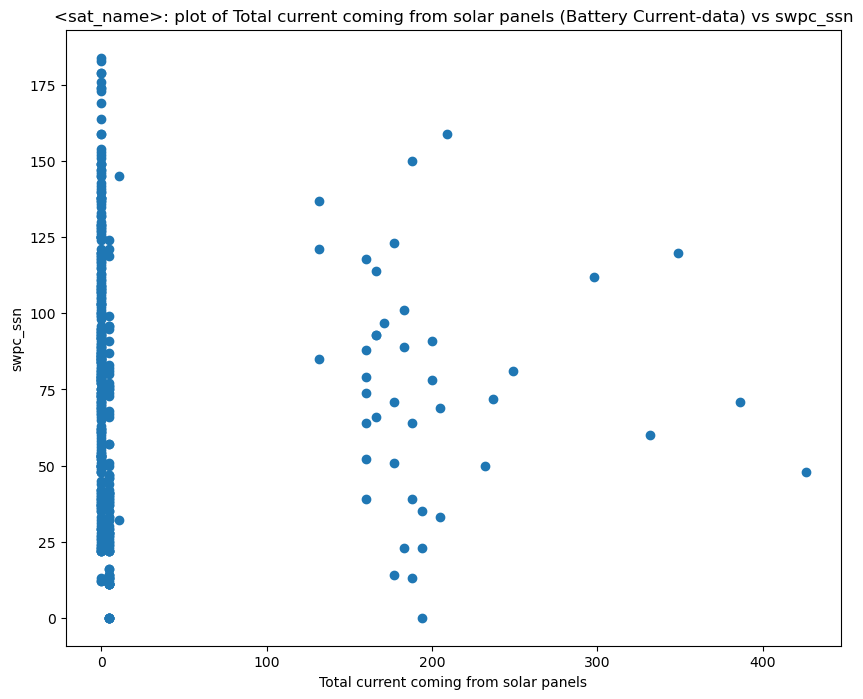

2024-02-11 17:45:02,893 - DEBUG - Processing file: ../data/ledsat/Battery Current-data-2024-02-11 02 21 49.csv


+---------+------------------------------------------+--------------+
|         |   Total current coming from solar panels |     swpc_ssn |
|---------+------------------------------------------+--------------|
| count   |                              403         |  403         |
| mean    |                               22.2258    |   75.2035    |
| std     |                               64.7521    |   41.9554    |
| min     |                                0         |    0         |
| 25%     |                                0         |   39         |
| 50%     |                                0         |   75         |
| 75%     |                                5         |  103         |
| max     |                              426         |  184         |
| Chi2    |                             3033.56      | 3033.56      |
| P-value |                                0.0682691 |    0.0682691 |
+---------+------------------------------------------+--------------+
Correlation [Total c

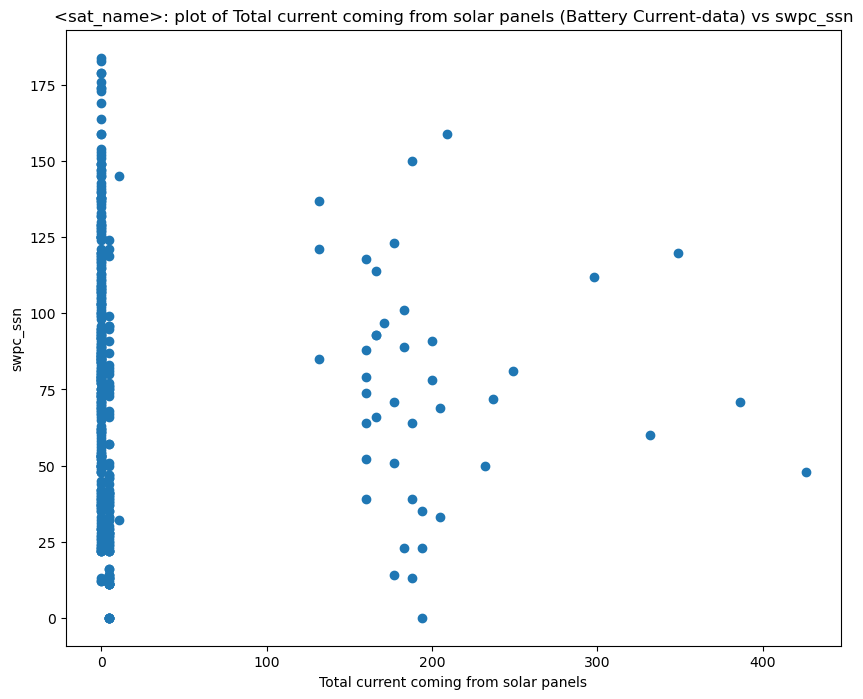

2024-02-11 17:45:03,045 - DEBUG - Processing file: ../data/ledsat/Battery Voltage-data-2024-02-11 02 19 06.csv


+---------+----------------+-------------+
|         |   49069.mode V |    swpc_ssn |
|---------+----------------+-------------|
| count   |     74         |  74         |
| mean    |      8.30905   |  80.0405    |
| std     |      0.0265438 |  44.4758    |
| min     |      8.16      |   0         |
| 25%     |      8.3       |  44.25      |
| 50%     |      8.31      |  84         |
| 75%     |      8.33      | 113         |
| max     |      8.34      | 179         |
| Chi2    |    616.769     | 616.769     |
| P-value |      0.0726354 |   0.0726354 |
+---------+----------------+-------------+
Correlation [49069.mode V] vs [swpc_ssn]: pearson=[0.1624826166777552], spearman=[0.16795207858376093], kendal_tau=[0.1292288541557749]


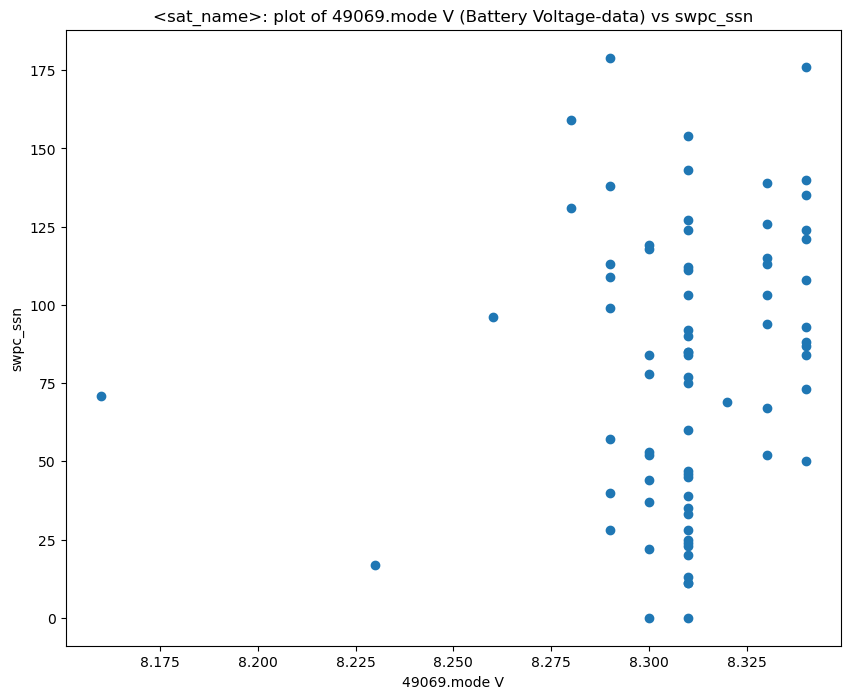

2024-02-11 17:45:03,194 - DEBUG - Processing file: ../data/ledsat/Battery Voltage-data-2024-02-11 02 21 33.csv


+---------+----------------+-------------+
|         |   49069.mode V |    swpc_ssn |
|---------+----------------+-------------|
| count   |     74         |  74         |
| mean    |      8.30905   |  80.0405    |
| std     |      0.0265438 |  44.4758    |
| min     |      8.16      |   0         |
| 25%     |      8.3       |  44.25      |
| 50%     |      8.31      |  84         |
| 75%     |      8.33      | 113         |
| max     |      8.34      | 179         |
| Chi2    |    616.769     | 616.769     |
| P-value |      0.0726354 |   0.0726354 |
+---------+----------------+-------------+
Correlation [49069.mode V] vs [swpc_ssn]: pearson=[0.1624826166777552], spearman=[0.16795207858376093], kendal_tau=[0.1292288541557749]


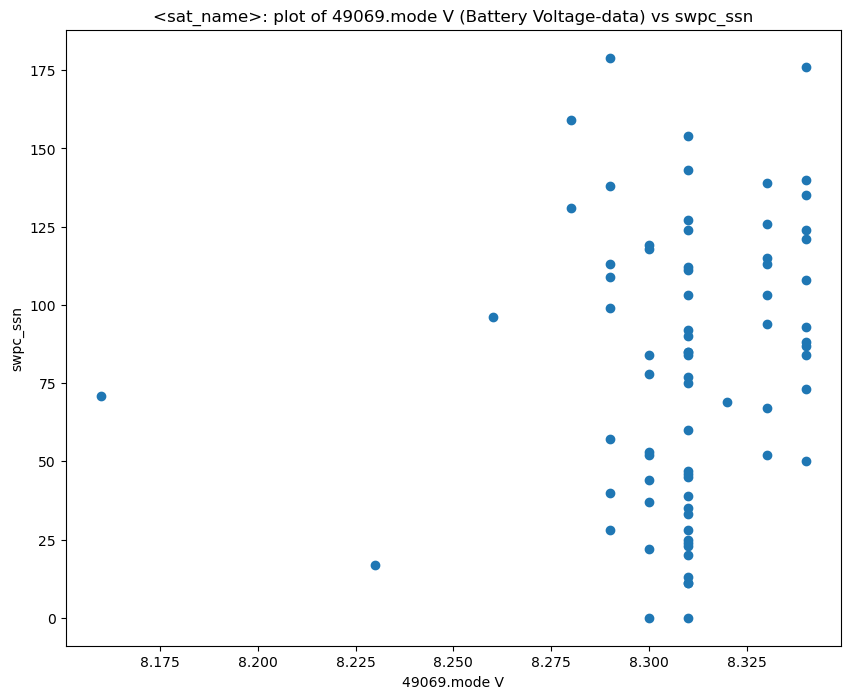

2024-02-11 17:45:03,347 - DEBUG - Processing file: ../data/ledsat/Ground Stations Leaderboard By Observed Frames-data-2024-02-11 02 18 48.csv


[Ground Stations Leaderboard By Observed Frames-data]: skipping column=[-----OE6EUR15-----]: not enough unique values.


In [49]:
analyze_satellite('ledsat')

2024-02-11 17:45:03,371 - DEBUG - Processing file: ../data/ramsat/Elevation-data-2024-02-11 02 21 27.csv


+---------+----------------------------------+------------------+
|         |   Elevation (onboard prediction) |         swpc_ssn |
|---------+----------------------------------+------------------|
| count   |                   484            |   484            |
| mean    |                   326.969        |    62.1322       |
| std     |                   125.551        |    38.5939       |
| min     |                     0            |     0            |
| 25%     |                   330            |    31            |
| 50%     |                   377            |    56.5          |
| 75%     |                   400            |    87            |
| max     |                   417            |   173            |
| Chi2    |                 23251.6          | 23251.6          |
| P-value |                     2.03977e-152 |     2.03977e-152 |
+---------+----------------------------------+------------------+
Correlation [Elevation (onboard prediction)] vs [swpc_ssn]: pearson=[0.02981

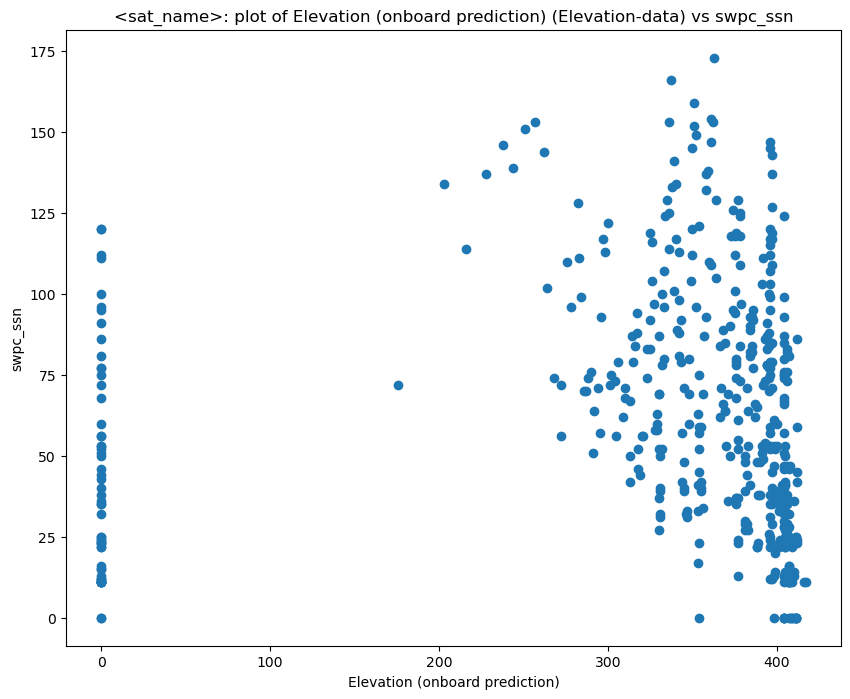

In [50]:
analyze_satellite('ramsat')

2024-02-11 17:45:03,534 - DEBUG - Processing file: ../data/ops-sat/RSSI Levels-data-2024-02-11 02 22 31.csv


+---------+-------------------------+--------------+
|         |   Background RSSI Level |     swpc_ssn |
|---------+-------------------------+--------------|
| count   |            1289         | 1289         |
| mean    |            -109.404     |   67.5679    |
| std     |               4.56206   |   51.1105    |
| min     |            -119         |    0         |
| 25%     |            -113         |   23         |
| 50%     |            -109         |   59         |
| 75%     |            -106         |  106         |
| max     |             -92         |  227         |
| Chi2    |            4643.87      | 4643.87      |
| P-value |               0.0658168 |    0.0658168 |
+---------+-------------------------+--------------+
Correlation [Background RSSI Level] vs [swpc_ssn]: pearson=[0.09084207566527523], spearman=[0.12143058041432787], kendal_tau=[0.08344434696351952]


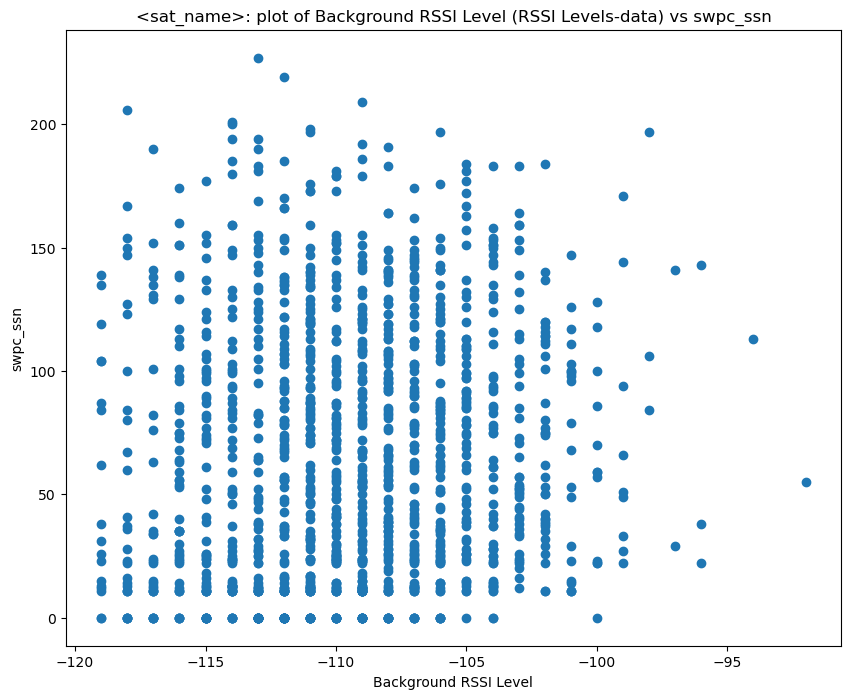

2024-02-11 17:45:03,697 - DEBUG - Processing file: ../data/ops-sat/Total RX Packets-data-2024-02-11 02 23 05.csv


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |       188    |   188      |
| mean    |     21452    |    68.9043 |
| std     |      3259.85 |    50.199  |
| min     |      5129    |     0      |
| 25%     |     20756.8  |    24      |
| 50%     |     22126    |    60.5    |
| 75%     |     23118    |   112      |
| max     |     24600    |   179      |
| Chi2    |     12334.6  | 12334.6    |
| P-value |         1    |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5748628313476977], spearman=[0.7857285673694304], kendal_tau=[0.5786804345788774]


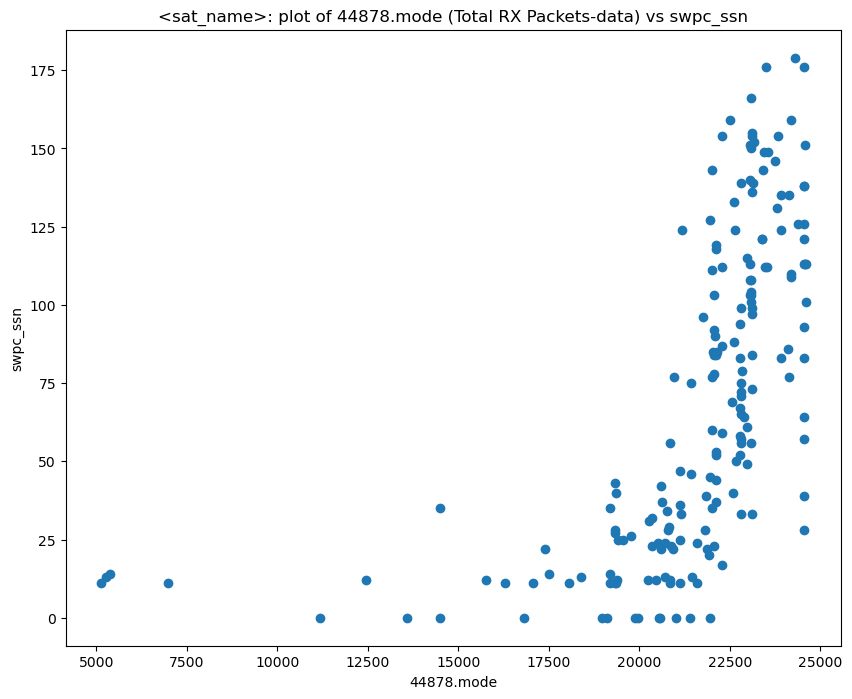

2024-02-11 17:45:03,869 - DEBUG - Processing file: ../data/ops-sat/Total TX Bytes-data-2024-02-11 02 23 09.csv


+---------+-----------------+--------------+
|         |      44878.mode |     swpc_ssn |
|---------+-----------------+--------------|
| count   |   188           |   188        |
| mean    |     2.89948e+09 |    68.9043   |
| std     |     5.94793e+08 |    50.199    |
| min     |     1.42965e+07 |     0        |
| 25%     |     2.91416e+09 |    24        |
| 50%     |     3.06149e+09 |    60.5      |
| 75%     |     3.20752e+09 |   112        |
| max     |     3.34178e+09 |   179        |
| Chi2    | 18424           | 18424        |
| P-value |     0.303465    |     0.303465 |
+---------+-----------------+--------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5353106560668386], spearman=[0.7858898612127606], kendal_tau=[0.5767193747435023]


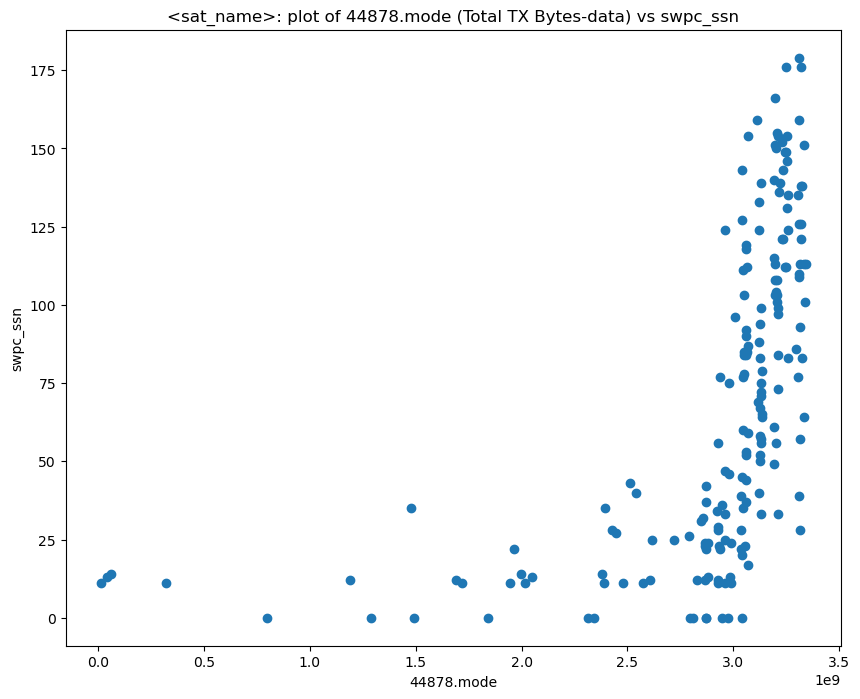

2024-02-11 17:45:04,030 - DEBUG - Processing file: ../data/ops-sat/Total TX duty time since reboot-data-2024-02-11 02 22 24.csv


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |    188       |   188      |
| mean    |      2.46277 |    68.9043 |
| std     |      5.21861 |    50.199  |
| min     |      0       |     0      |
| 25%     |      0       |    24      |
| 50%     |      0       |    60.5    |
| 75%     |      2       |   112      |
| max     |     35       |   179      |
| Chi2    |   1182.93    |  1182.93   |
| P-value |      1       |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.3204786726051506], spearman=[-0.4292673343841385], kendal_tau=[-0.33004813384919396]


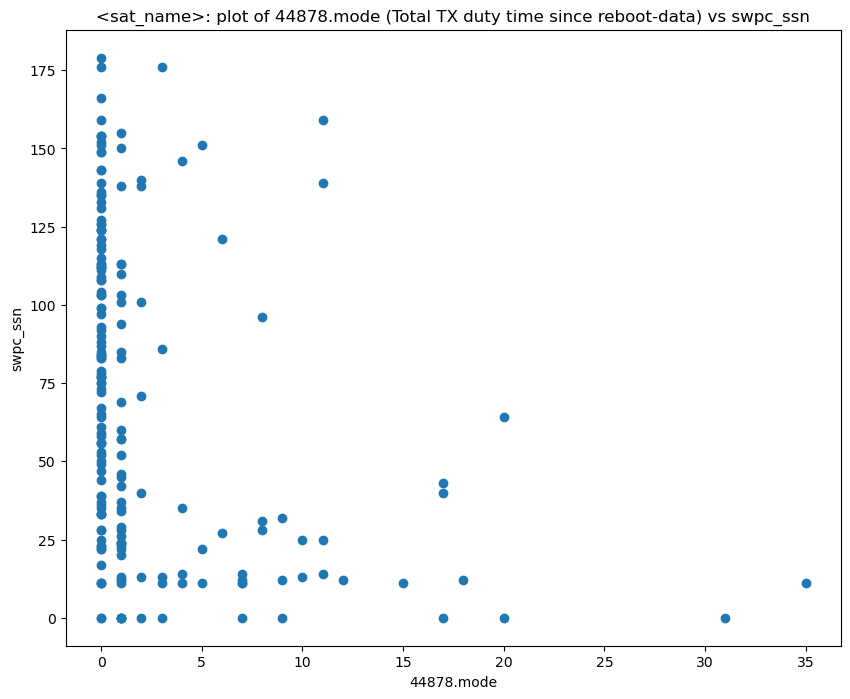

2024-02-11 17:45:04,185 - DEBUG - Processing file: ../data/ops-sat/Total TX Packets-data-2024-02-11 02 23 12.csv


+---------+------------------+--------------+
|         |       44878.mode |     swpc_ssn |
|---------+------------------+--------------|
| count   |    188           |   188        |
| mean    |      1.6614e+07  |    68.9043   |
| std     |      3.55207e+06 |    50.199    |
| min     | 176553           |     0        |
| 25%     |      1.66055e+07 |    24        |
| 50%     |      1.75827e+07 |    60.5      |
| 75%     |      1.85426e+07 |   112        |
| max     |      1.9407e+07  |   179        |
| Chi2    |  18424           | 18424        |
| P-value |      0.303465    |     0.303465 |
+---------+------------------+--------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5561946696013134], spearman=[0.7858898612127606], kendal_tau=[0.5767193747435023]


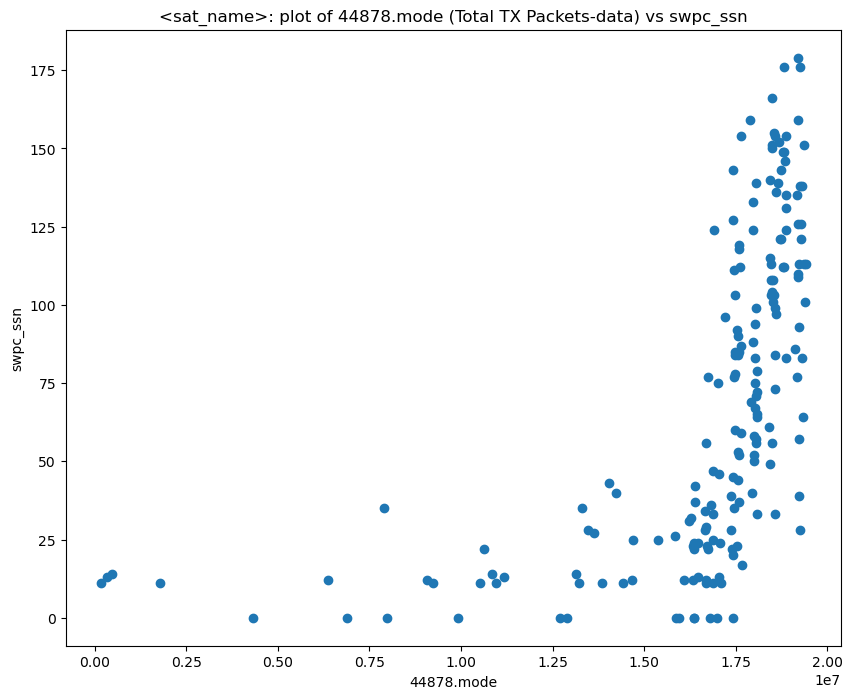

2024-02-11 17:45:04,345 - DEBUG - Processing file: ../data/ops-sat/TX bytes since reboot-data-2024-02-11 02 22 51.csv


+---------+------------------+--------------+
|         |       44878.mode |     swpc_ssn |
|---------+------------------+--------------|
| count   |    188           |   188        |
| mean    |      1.2581e+07  |    68.9043   |
| std     |      4.53865e+07 |    50.199    |
| min     |   3008           |     0        |
| 25%     |  79537.8         |    24        |
| 50%     | 546839           |    60.5      |
| 75%     |      3.14044e+06 |   112        |
| max     |      3.70719e+08 |   179        |
| Chi2    |  17844.3         | 17844.3      |
| P-value |      0.138466    |     0.138466 |
+---------+------------------+--------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.2918840914794443], spearman=[-0.27982887225292064], kendal_tau=[-0.18135307800557543]


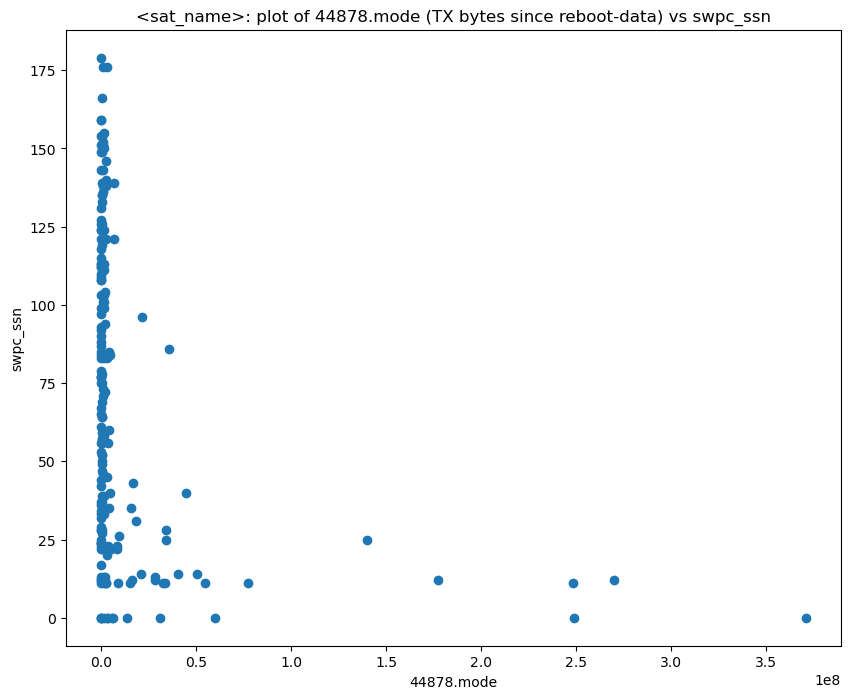

2024-02-11 17:45:04,503 - DEBUG - Processing file: ../data/ops-sat/TX packets since reboot-data-2024-02-11 02 22 55.csv


+---------+------------------+-----------------+
|         |       44878.mode |        swpc_ssn |
|---------+------------------+-----------------|
| count   |   1289           |   1289          |
| mean    |  74049.3         |     67.5679     |
| std     | 222726           |     51.1105     |
| min     |      1           |      0          |
| 25%     |   1069           |     23          |
| 50%     |   5386           |     59          |
| 75%     |  22765           |    106          |
| max     |      1.71596e+06 |    227          |
| Chi2    | 212417           | 212417          |
| P-value |      0.00592803  |      0.00592803 |
+---------+------------------+-----------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.32635194664806416], spearman=[-0.2839994754465362], kendal_tau=[-0.18962512401888412]


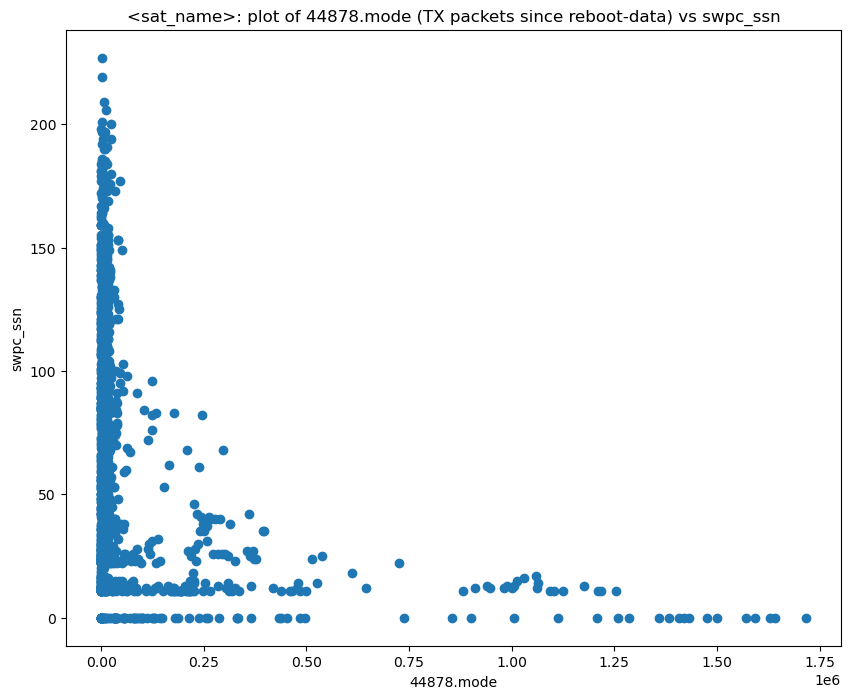

2024-02-11 17:45:04,682 - DEBUG - Processing file: ../data/ops-sat/Active Transceiver Configuration-data-2024-02-11 02 22 36.csv
2024-02-11 17:45:04,701 - DEBUG - Processing file: ../data/ops-sat/Last Frame Rcvd By-data-2024-02-11 02 22 33.csv
2024-02-11 17:45:04,720 - DEBUG - Processing file: ../data/ops-sat/Last frame-data-2024-02-11 02 22 26.csv
2024-02-11 17:45:04,738 - DEBUG - Processing file: ../data/ops-sat/Last RX Frequency Offset-data-2024-02-11 02 22 40.csv


[Active Transceiver Configuration-data]: skipping column=[44878.mode]: not enough unique values.
[Last Frame Rcvd By-data]: skipping column=[last where 0 is DP0OPS]: not enough unique values.
[Last frame-data]: skipping column=[44878.last]: not enough unique values.
+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |    1289      |  1289      |
| mean    |      59.9108 |    67.5679 |
| std     |    1063.59   |    51.1105 |
| min     |  -10471      |     0      |
| 25%     |       0      |    23      |
| 50%     |     212      |    59      |
| 75%     |     446      |   106      |
| max     |    4810      |   227      |
| Chi2    |   48612.2    | 48612.2    |
| P-value |       1      |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.1787243752541007], spearman=[-0.3397847873246419], kendal_tau=[-0.2429687701330934]


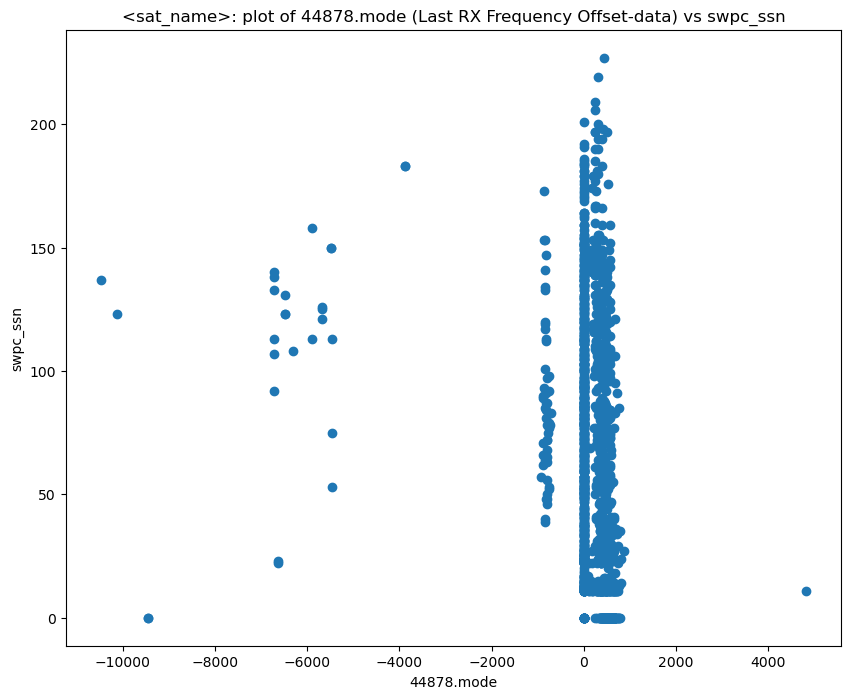

2024-02-11 17:45:04,901 - DEBUG - Processing file: ../data/ops-sat/Last valid RX packet timestamp-data-2024-02-11 02 22 43.csv


+---------+---------------------+------------+
|         |   Last RX timestamp |   swpc_ssn |
|---------+---------------------+------------|
| count   |       188           |   188      |
| mean    |         1.50759e+09 |    68.9043 |
| std     |         9.2103e+08  |    50.199  |
| min     |         9.47637e+08 |     0      |
| 25%     |         9.55291e+08 |    24      |
| 50%     |         1.03348e+09 |    60.5    |
| 75%     |         1.0365e+09  |   112      |
| max     |         3.12114e+09 |   179      |
| Chi2    |     12334.6         | 12334.6    |
| P-value |         1           |     1      |
+---------+---------------------+------------+
Correlation [Last RX timestamp] vs [swpc_ssn]: pearson=[-0.18111889169521622], spearman=[-0.020300742229652155], kendal_tau=[-0.01649104207369058]


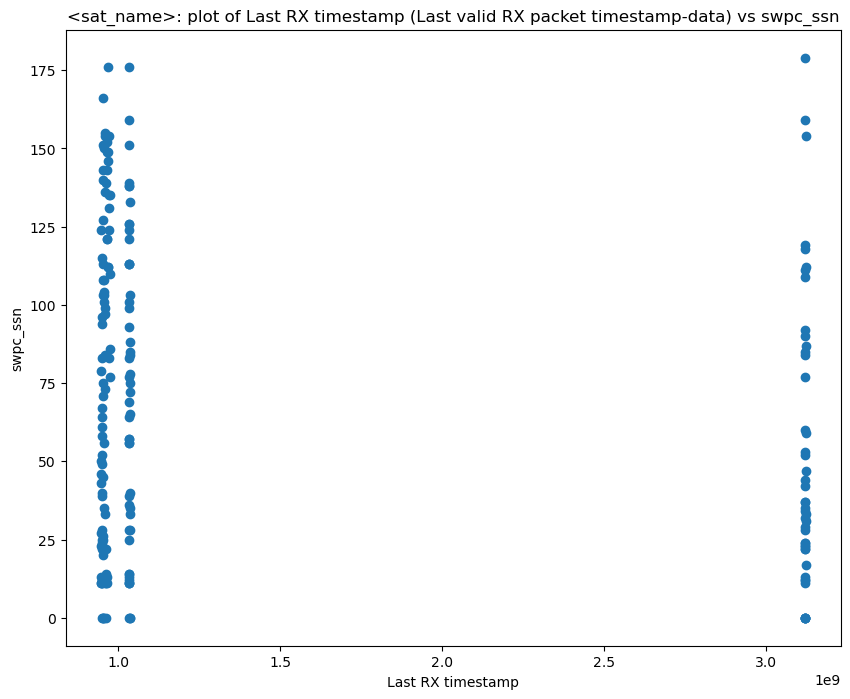

2024-02-11 17:45:05,060 - DEBUG - Processing file: ../data/ops-sat/Number of transceiver reboots-data-2024-02-11 02 22 20.csv


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |     1289     |  1289      |
| mean    |     1039.94  |    67.5679 |
| std     |      262.858 |    51.1105 |
| min     |      534     |     0      |
| 25%     |      925     |    23      |
| 50%     |     1161     |    59      |
| 75%     |     1222     |   106      |
| max     |     1305     |   227      |
| Chi2    |    52698.7   | 52698.7    |
| P-value |        1     |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.6808436708746547], spearman=[0.803383853194286], kendal_tau=[0.6007578538393359]


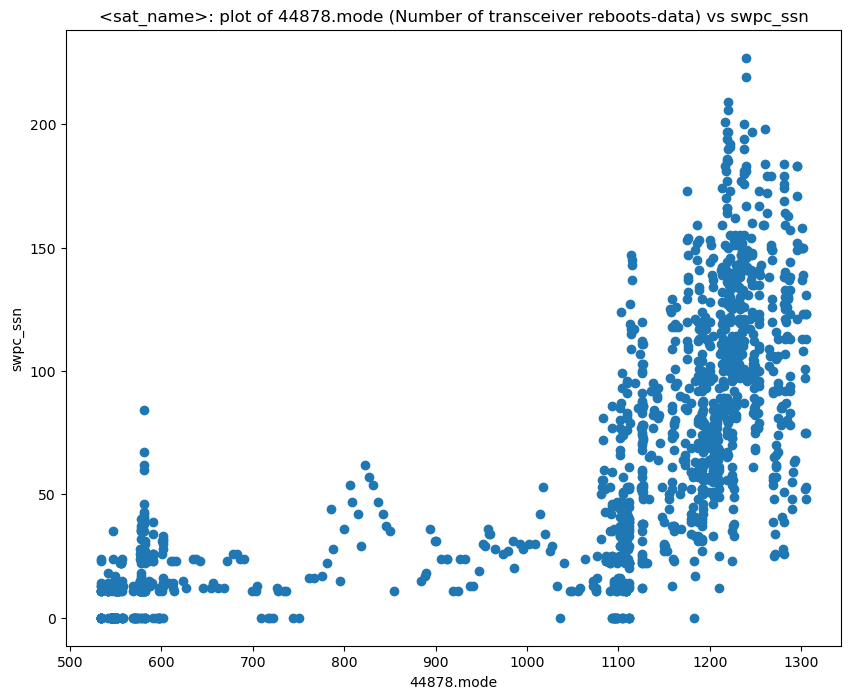

2024-02-11 17:45:05,237 - DEBUG - Processing file: ../data/ops-sat/Reboot cause code-data-2024-02-11 02 23 01.csv
2024-02-11 17:45:05,263 - DEBUG - Processing file: ../data/ops-sat/RX bytes since reboot-data-2024-02-11 02 22 46.csv


[Reboot cause code-data]: skipping column=[44878.mode]: not enough unique values.
+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |       188    |   188      |
| mean    |      3552.3  |    68.9043 |
| std     |     13749    |    50.199  |
| min     |         0    |     0      |
| 25%     |         0    |    24      |
| 50%     |        82    |    60.5    |
| 75%     |      1040.25 |   112      |
| max     |    125791    |   179      |
| Chi2    |      8028.37 |  8028.37   |
| P-value |         1    |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.261793611402168], spearman=[-0.28165869536918936], kendal_tau=[-0.19665418137960228]


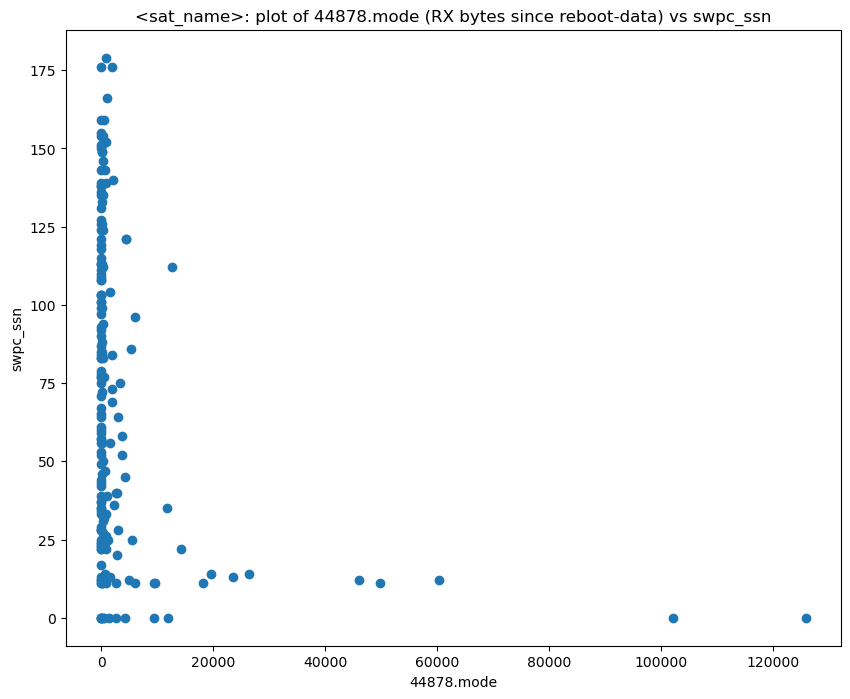

2024-02-11 17:45:05,435 - DEBUG - Processing file: ../data/ops-sat/RX packets since reboot-data-2024-02-11 02 22 49.csv


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |    1289      |  1289      |
| mean    |      75.1311 |    67.5679 |
| std     |     246.648  |    51.1105 |
| min     |       0      |     0      |
| 25%     |       0      |    23      |
| 50%     |       5      |    59      |
| 75%     |      29      |   106      |
| max     |    2231      |   227      |
| Chi2    |   23807.7    | 23807.7    |
| P-value |       1      |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.2816047057681802], spearman=[-0.2944798008540808], kendal_tau=[-0.21233242876313882]


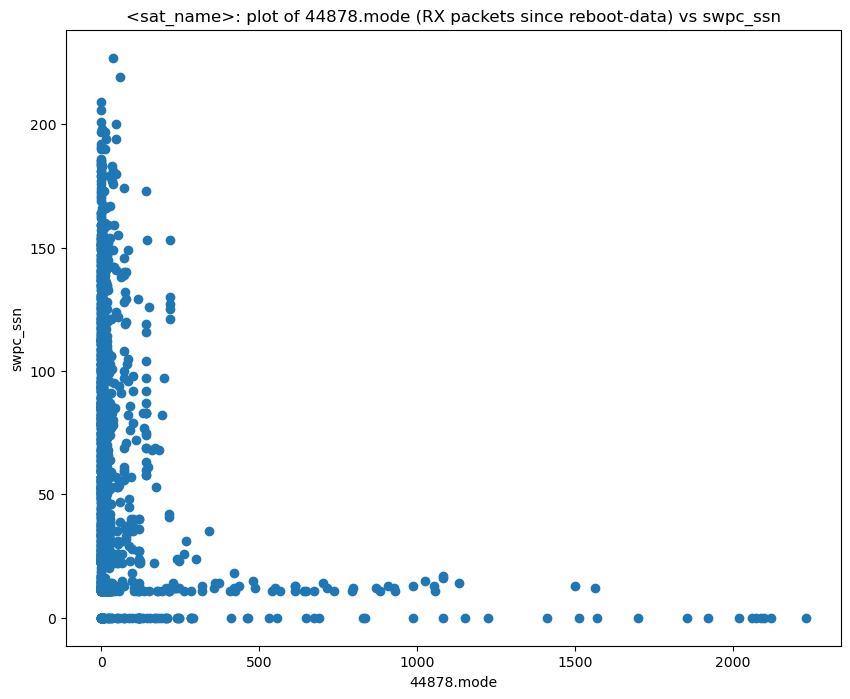

2024-02-11 17:45:05,630 - DEBUG - Processing file: ../data/ops-sat/Selected frames count-data-2024-02-11 02 22 13.csv


+---------+-------------------+-------------------+
|         |            Frames |          swpc_ssn |
|---------+-------------------+-------------------|
| count   |   1449            |   1449            |
| mean    | 130535            |     62.7481       |
| std     |  62472            |     52.0369       |
| min     |      0            |      0            |
| 25%     | 108054            |     14            |
| 50%     | 134599            |     52            |
| 75%     | 172671            |    101            |
| max     | 225936            |    227            |
| Chi2    | 250306            | 250306            |
| P-value |      5.05279e-128 |      5.05279e-128 |
+---------+-------------------+-------------------+
Correlation [Frames] vs [swpc_ssn]: pearson=[0.7330561930756717], spearman=[0.8333018545991522], kendal_tau=[0.6322657615049996]


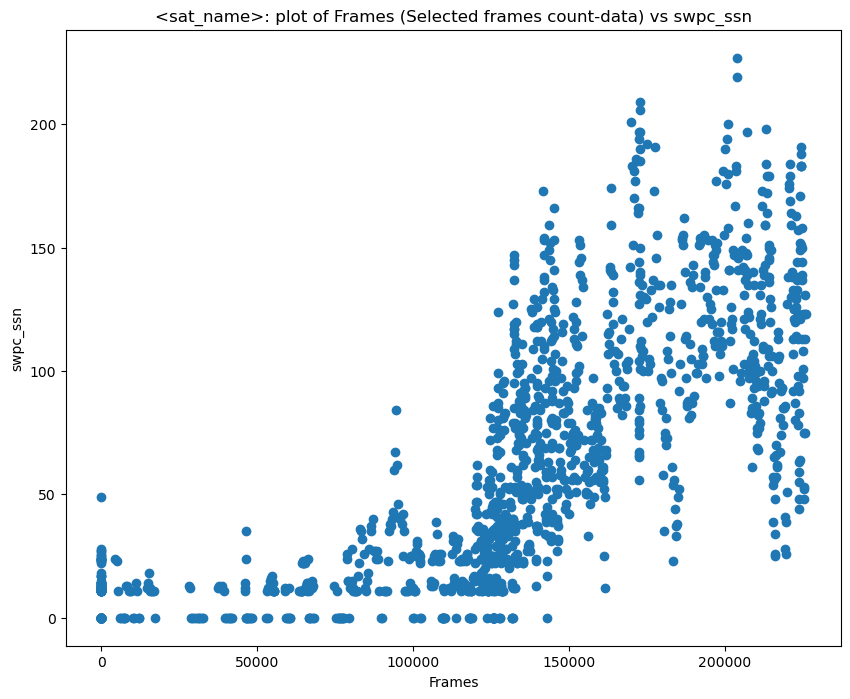

2024-02-11 17:45:05,823 - DEBUG - Processing file: ../data/ops-sat/Total RX Bytes-data-2024-02-11 02 22 57.csv


+---------+------------------+------------+
|         |       44878.mode |   swpc_ssn |
|---------+------------------+------------|
| count   |    188           |   188      |
| mean    |      1.0835e+06  |    68.9043 |
| std     | 127400           |    50.199  |
| min     | 392180           |     0      |
| 25%     |      1.05803e+06 |    24      |
| 50%     |      1.10793e+06 |    60.5    |
| 75%     |      1.14679e+06 |   112      |
| max     |      1.19440e+06 |   179      |
| Chi2    |  12334.6         | 12334.6    |
| P-value |      1           |     1      |
+---------+------------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5380133871877748], spearman=[0.7857285673694304], kendal_tau=[0.5786804345788774]


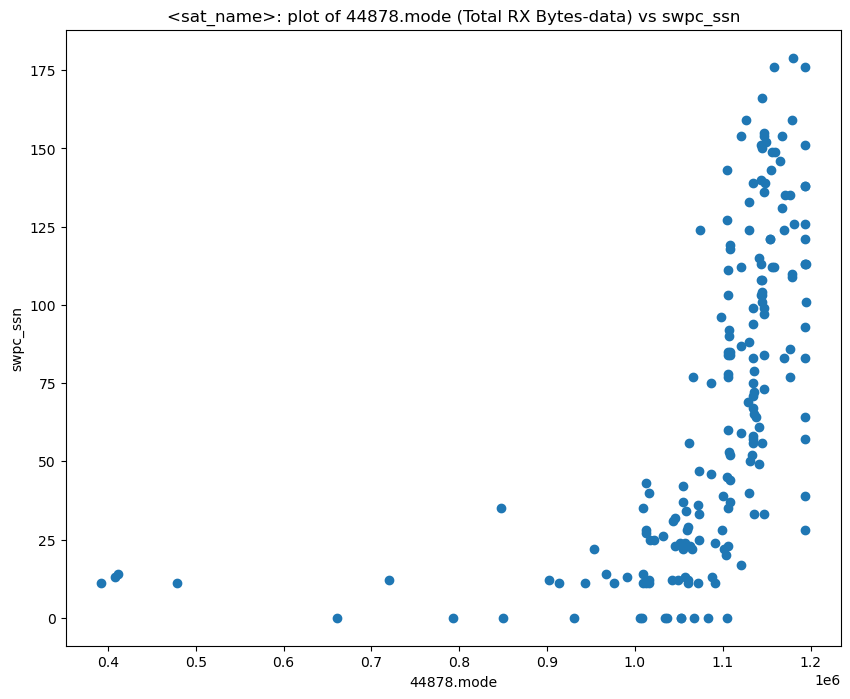

In [51]:
analyze_satellite('ops-sat')

2024-02-11 17:45:05,989 - DEBUG - Processing file: ../data/veronika/UHF Digipeater usage-data-2024-02-11 02 22 38.csv


+---------+--------------+------------+
|         |   58261.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |     13       |   13       |
| mean    |     28.6154  |  111.154   |
| std     |     16.0963  |   38.6455  |
| min     |      0       |   28       |
| 25%     |     17       |   93       |
| 50%     |     39       |  113       |
| 75%     |     42       |  138       |
| max     |     43       |  176       |
| Chi2    |     87.75    |   87.75    |
| P-value |      0.25905 |    0.25905 |
+---------+--------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.21471666569320857], spearman=[0.015235515517624728], kendal_tau=[-0.026669037353133248]


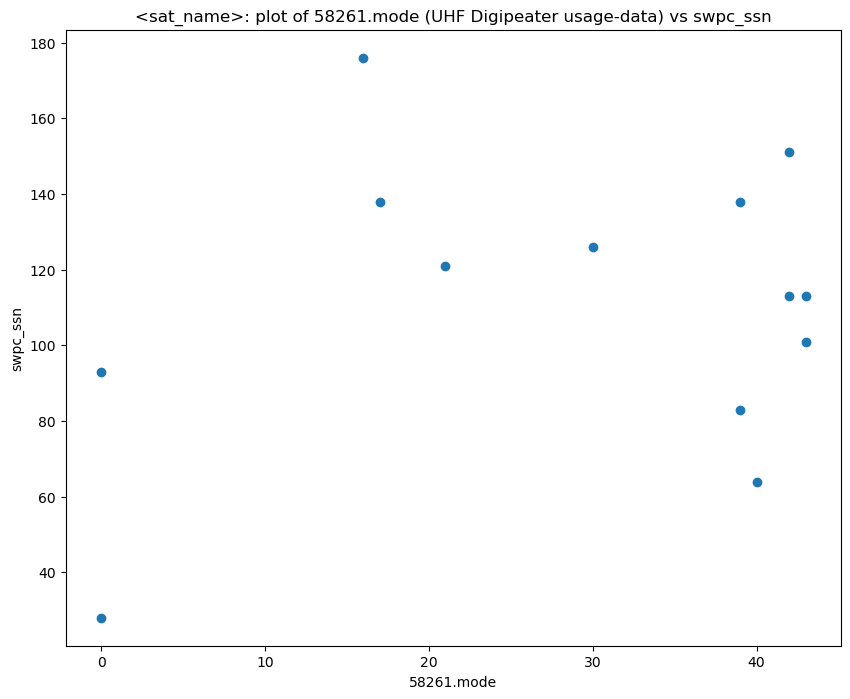

2024-02-11 17:45:06,205 - DEBUG - Processing file: ../data/veronika/UHF Temperatures-data-2024-02-11 02 23 07.csv


+---------+--------------+--------------+
|         |     MCU (°C) |     swpc_ssn |
|---------+--------------+--------------|
| count   |   85         |   85         |
| mean    |    2.04588   |  117.176     |
| std     |    4.15496   |   42.2862    |
| min     |   -3         |   26         |
| 25%     |   -1         |   86         |
| 50%     |    0.54      |  123         |
| 75%     |    4.9       |  149         |
| max     |   15         |  191         |
| Chi2    | 2498.29      | 2498.29      |
| P-value |    0.0047717 |    0.0047717 |
+---------+--------------+--------------+
Correlation [MCU (°C)] vs [swpc_ssn]: pearson=[-0.057043332723949264], spearman=[-0.07386560505897043], kendal_tau=[-0.05313741753683994]


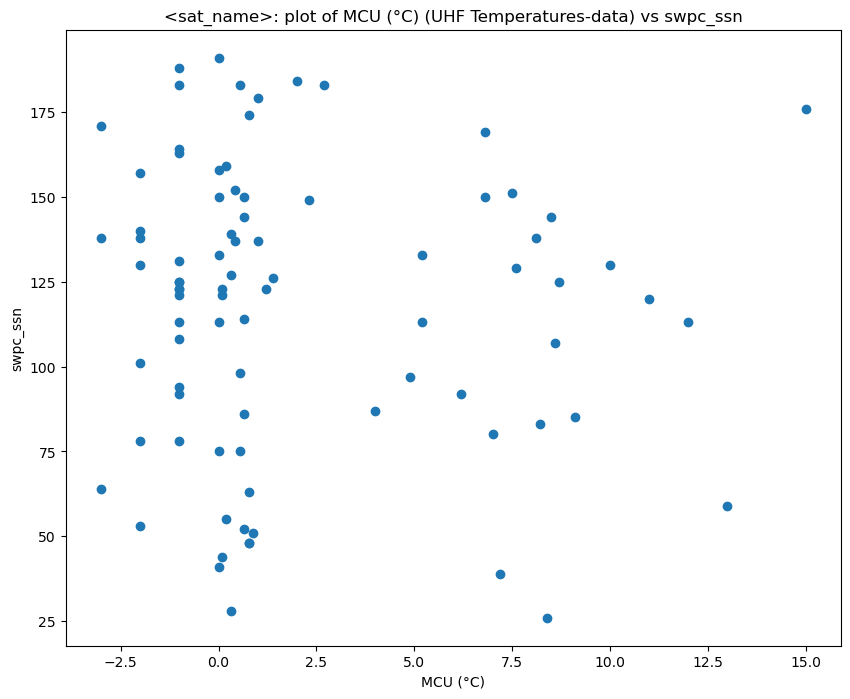

2024-02-11 17:45:06,383 - DEBUG - Processing file: ../data/veronika/UHF Transmitted packets-data-2024-02-11 02 23 22.csv


+---------+---------------+------------+
|         |    58261.mode |   swpc_ssn |
|---------+---------------+------------|
| count   |     13        |  13        |
| mean    | 451529        | 111.154    |
| std     | 313169        |  38.6455   |
| min     |  11665        |  28        |
| 25%     | 176553        |  93        |
| 50%     | 474357        | 113        |
| 75%     | 744778        | 138        |
| max     | 868583        | 176        |
| Chi2    |    130        | 130        |
| P-value |      0.251062 |   0.251062 |
+---------+---------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.04947440917428154], spearman=[-0.024793482509275887], kendal_tau=[-0.0519524333466131]


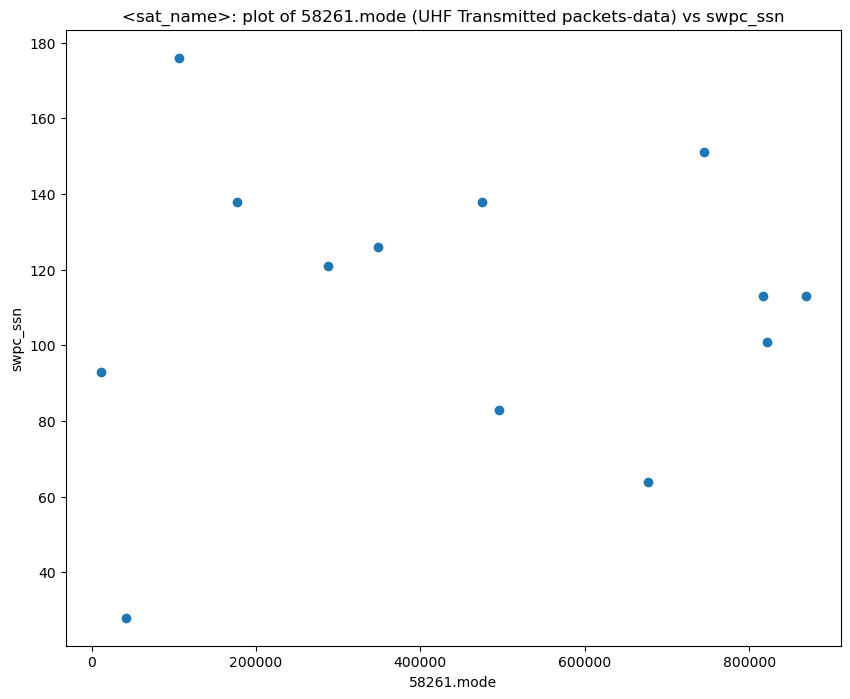

2024-02-11 17:45:06,548 - DEBUG - Processing file: ../data/veronika/UHF Uptime (s)-data-2024-02-11 02 22 42.csv


+---------+------------------+------------+
|         |       58261.mode |   swpc_ssn |
|---------+------------------+------------|
| count   |     13           |  13        |
| mean    |      3.64372e+06 | 111.154    |
| std     |      2.31573e+06 |  38.6455   |
| min     | 178201           |  28        |
| 25%     |      1.73195e+06 |  93        |
| 50%     |      3.94287e+06 | 113        |
| 75%     |      5.27738e+06 | 138        |
| max     |      7.09168e+06 | 176        |
| Chi2    |    130           | 130        |
| P-value |      0.251062    |   0.251062 |
+---------+------------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.06104289922773398], spearman=[-0.024793482509275887], kendal_tau=[-0.0519524333466131]


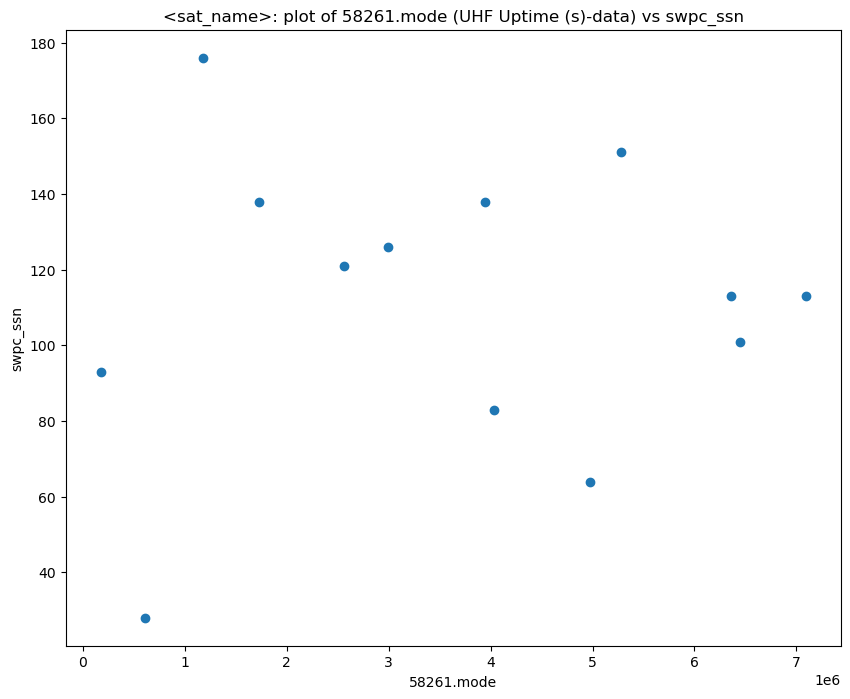

2024-02-11 17:45:06,720 - DEBUG - Processing file: ../data/veronika/UHF Uptime Tot. (s)-data-2024-02-11 02 22 48.csv


+---------+------------------+------------+
|         |       58261.mode |   swpc_ssn |
|---------+------------------+------------|
| count   |     13           |  13        |
| mean    |      3.64374e+06 | 111.154    |
| std     |      2.31573e+06 |  38.6455   |
| min     | 178224           |  28        |
| 25%     |      1.73197e+06 |  93        |
| 50%     |      3.94289e+06 | 113        |
| 75%     |      5.27740e+06 | 138        |
| max     |      7.0917e+06  | 176        |
| Chi2    |    130           | 130        |
| P-value |      0.251062    |   0.251062 |
+---------+------------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.06104289922773398], spearman=[-0.024793482509275887], kendal_tau=[-0.0519524333466131]


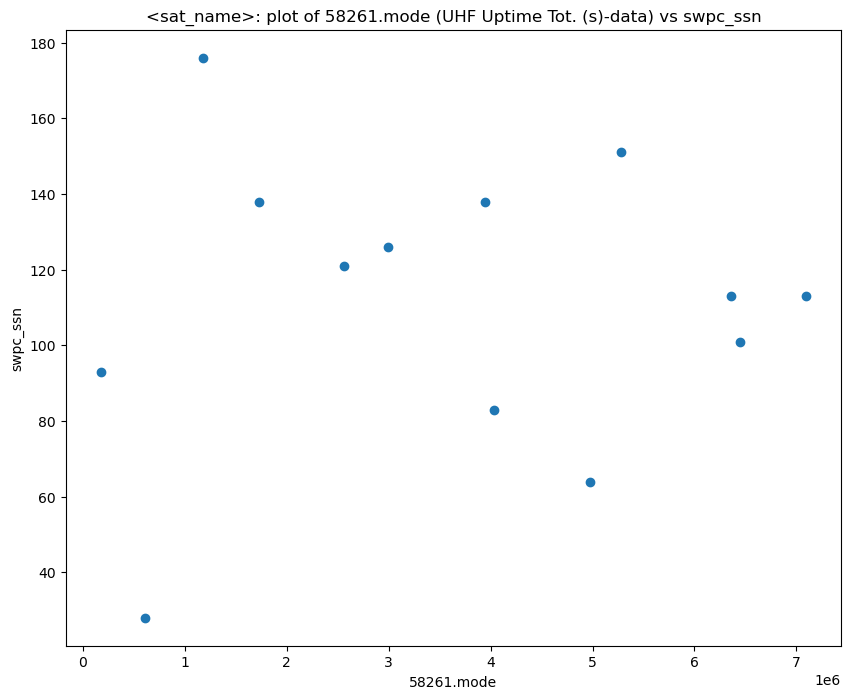

2024-02-11 17:45:06,897 - DEBUG - Processing file: ../data/veronika/UHF Uptime Tot.-data-2024-02-11 02 22 58.csv


+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.16038  | 111.154    |
| std     |                3.63519  |  38.6455   |
| min     |                1.012    |  28        |
| 25%     |                2.864    |  93        |
| 50%     |                6.519    | 113        |
| 75%     |                8.726    | 138        |
| max     |               11.726    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.04530430387259429], spearman=[-0.05785145918831041], kendal_tau=[-0.0519524333466131]


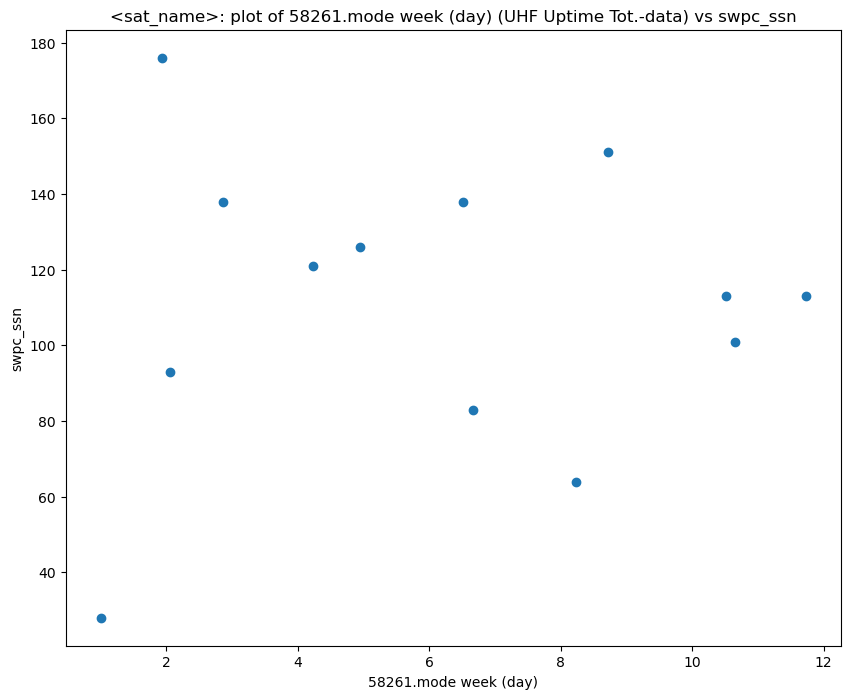

2024-02-11 17:45:07,071 - DEBUG - Processing file: ../data/veronika/UHF Uptime-data-2024-02-11 02 22 52.csv


+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.16038  | 111.154    |
| std     |                3.63519  |  38.6455   |
| min     |                1.012    |  28        |
| 25%     |                2.864    |  93        |
| 50%     |                6.519    | 113        |
| 75%     |                8.726    | 138        |
| max     |               11.726    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.04530430387259429], spearman=[-0.05785145918831041], kendal_tau=[-0.0519524333466131]


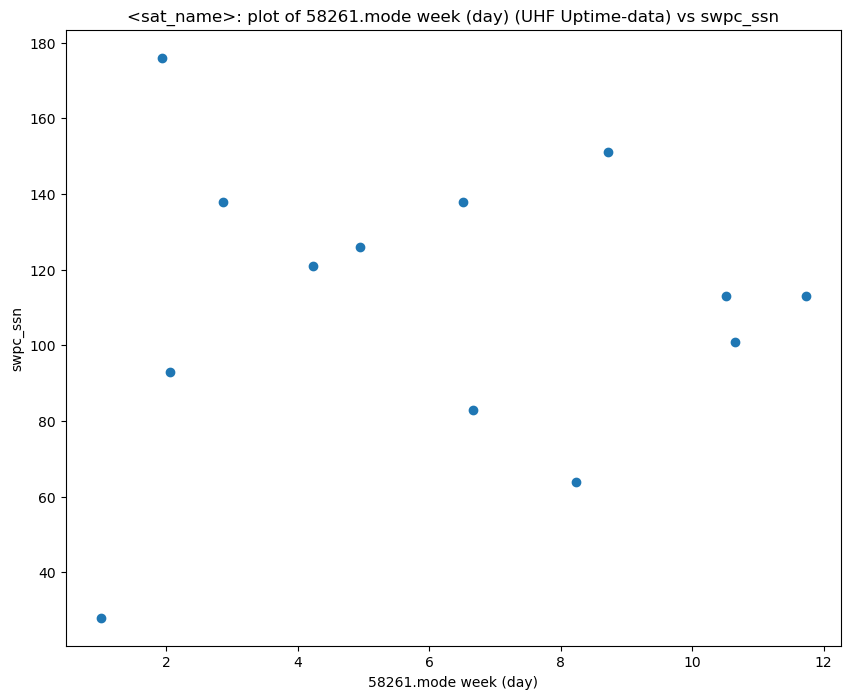

2024-02-11 17:45:07,245 - DEBUG - Processing file: ../data/veronika/Internal Magnetometer-data-2024-02-11 02 23 43.csv


+---------+--------------+-------------+
|         |            X |    swpc_ssn |
|---------+--------------+-------------|
| count   |    85        |   85        |
| mean    |  8772.72     |  117.176    |
| std     |  2854.7      |   42.2862   |
| min     | -1436        |   26        |
| 25%     |  8582        |   86        |
| 50%     |  9436        |  123        |
| 75%     | 10091        |  149        |
| max     | 17179        |  191        |
| Chi2    |  5100        | 5100        |
| P-value |     0.354418 |    0.354418 |
+---------+--------------+-------------+
Correlation [X] vs [swpc_ssn]: pearson=[0.10656617888267522], spearman=[0.07785607654783727], kendal_tau=[0.055165208946249426]


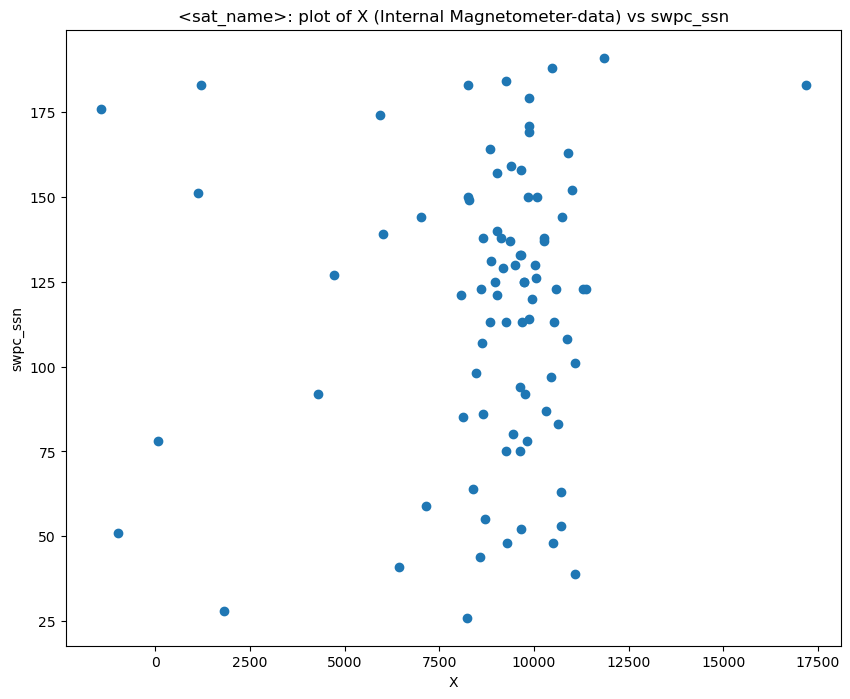

2024-02-11 17:45:07,425 - DEBUG - Processing file: ../data/veronika/Last Frame Received-data-2024-02-11 02 23 24.csv
/tmp/ipykernel_12372/1395458949.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
2024-02-11 17:45:07,452 - DEBUG - Processing file: ../data/veronika/OBC Uptime Tot.-data-2024-02-11 02 22 35.csv


[Last Frame Received-data]: skipping column=[58261.pid]: not enough unique values.
+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.28238  | 111.154    |
| std     |                3.70936  |  38.6455   |
| min     |                1.012    |  28        |
| 25%     |                2.722    |  93        |
| 50%     |                5.724    | 113        |
| 75%     |                8.659    | 138        |
| max     |               12.515    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.041200604541361034], spearman=[-0.00826449416975863], kendal_tau=[-0.02597621667330655]


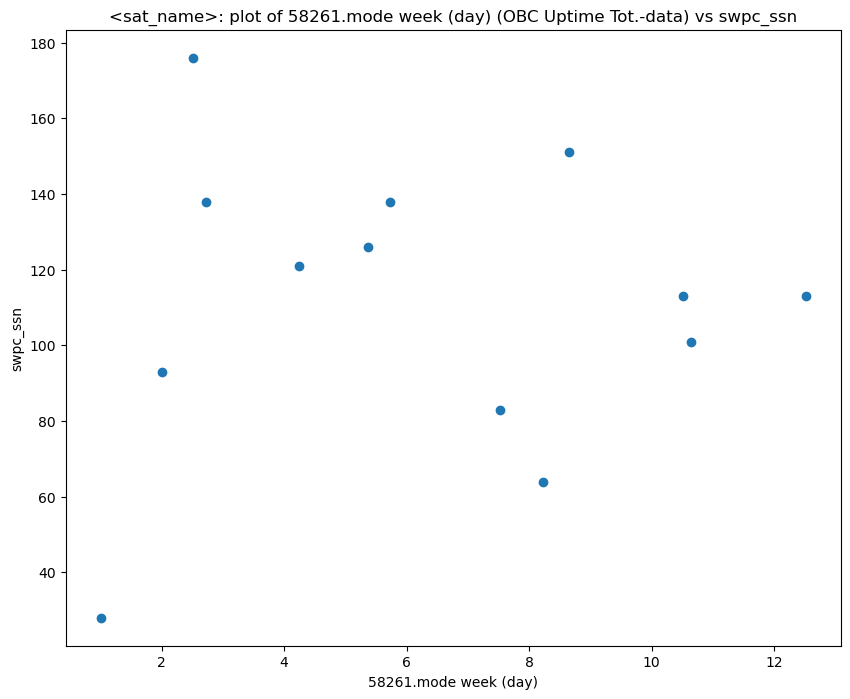

2024-02-11 17:45:07,612 - DEBUG - Processing file: ../data/veronika/OBC Uptime-data-2024-02-11 02 22 31.csv
2024-02-11 17:45:07,639 - DEBUG - Processing file: ../data/veronika/PSU GWD Timeout-data-2024-02-11 02 23 39.csv
2024-02-11 17:45:07,659 - DEBUG - Processing file: ../data/veronika/PSU Uptime Tot.-data-2024-02-11 02 22 26.csv


[PSU GWD Timeout-data]: skipping column=[58261.mode day]: not enough unique values.
+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.43869  | 111.154    |
| std     |                3.72289  |  38.6455   |
| min     |                1.011    |  28        |
| 25%     |                3.05     |  93        |
| 50%     |                6.37     | 113        |
| 75%     |                9.508    | 138        |
| max     |               12.493    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.06972682906356296], spearman=[-0.09366426725726446], kendal_tau=[-0.07792865001991965]


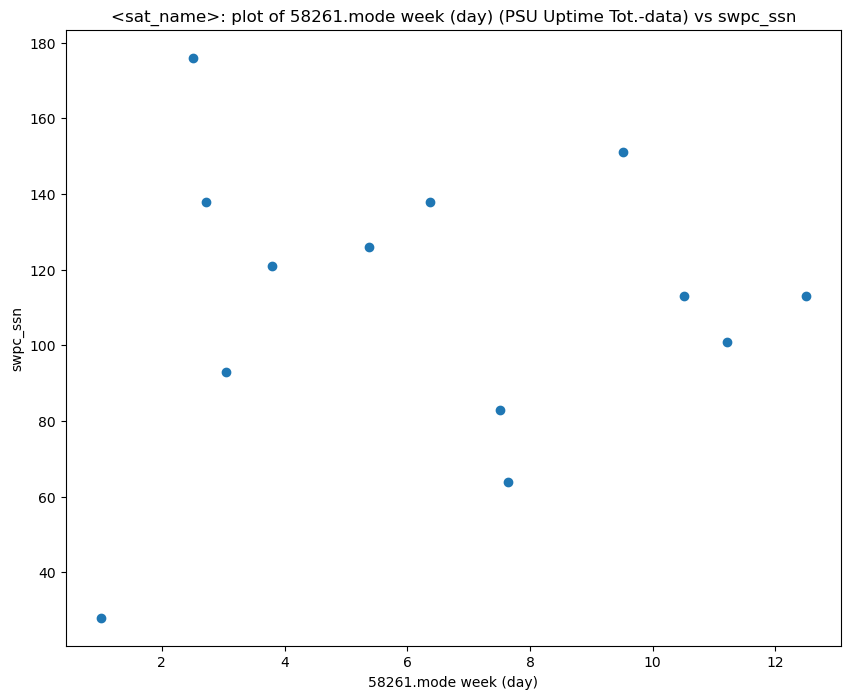

2024-02-11 17:45:07,821 - DEBUG - Processing file: ../data/veronika/PSU Uptime-data-2024-02-11 02 22 23.csv


+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.43862  | 111.154    |
| std     |                3.72291  |  38.6455   |
| min     |                1.011    |  28        |
| 25%     |                3.05     |  93        |
| 50%     |                6.37     | 113        |
| 75%     |                9.508    | 138        |
| max     |               12.493    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.0697177822007228], spearman=[-0.09366426725726446], kendal_tau=[-0.07792865001991965]


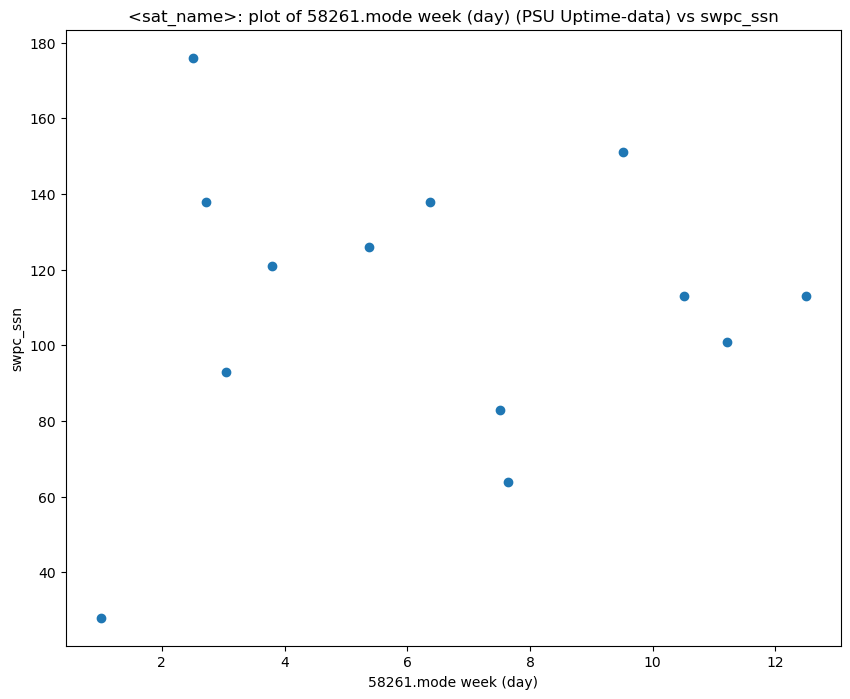

2024-02-11 17:45:07,967 - DEBUG - Processing file: ../data/veronika/Radio RSSI-data-2024-02-11 02 22 20.csv
2024-02-11 17:45:07,986 - DEBUG - Processing file: ../data/veronika/Transmitted message-data-2024-02-11 02 23 29.csv
2024-02-11 17:45:08,005 - DEBUG - Processing file: ../data/veronika/UHF last digipeater user-data-2024-02-11 02 23 32.csv
2024-02-11 17:45:08,024 - DEBUG - Processing file: ../data/veronika/UHF Last temperatures-data-2024-02-11 02 23 03.csv


[Radio RSSI-data]: skipping column=[UHF Act]: not enough unique values.
+---------+------------+------------+
|         |   MCU (°C) |   swpc_ssn |
|---------+------------+------------|
| count   |  13        |  13        |
| mean    |   7.33077  | 111.154    |
| std     |   3.94575  |  38.6455   |
| min     |  -1        |  28        |
| 25%     |   5.1      |  93        |
| 50%     |   7.5      | 113        |
| 75%     |  10        | 138        |
| max     |  15        | 176        |
| Chi2    | 117        | 117        |
| P-value |   0.306071 |   0.306071 |
+---------+------------+------------+
Correlation [MCU (°C)] vs [swpc_ssn]: pearson=[-0.22519147552737345], spearman=[-0.40000038049994835], kendal_tau=[-0.3006600167292012]


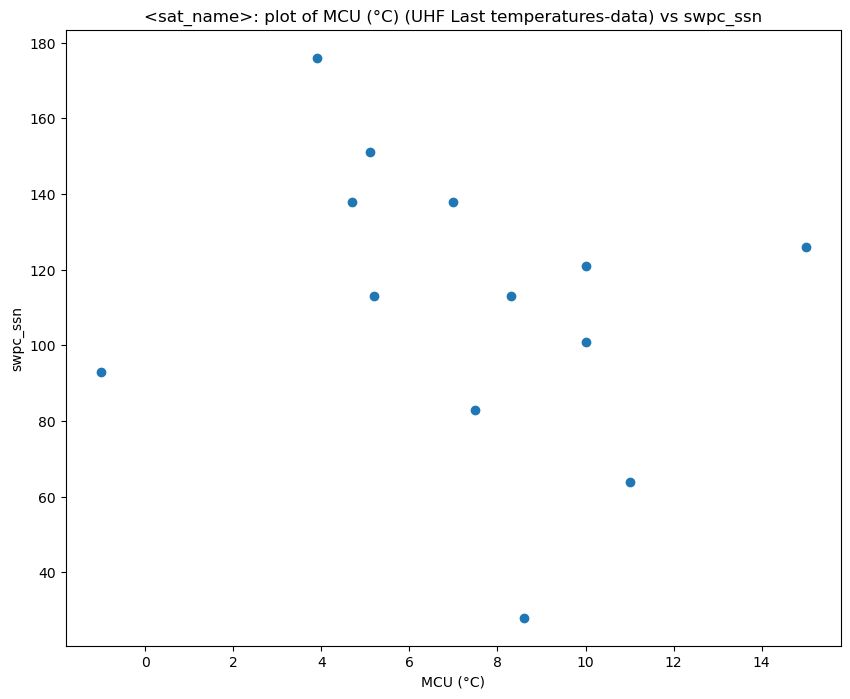

+---------+----------------+------------+
|         |   RF Chip (°C) |   swpc_ssn |
|---------+----------------+------------|
| count   |      13        |  13        |
| mean    |       7.24615  | 111.154    |
| std     |       4.82141  |  38.6455   |
| min     |      -2        |  28        |
| 25%     |       4.4      |  93        |
| 50%     |       6.6      | 113        |
| 75%     |       9.7      | 138        |
| max     |      18        | 176        |
| Chi2    |     123.5      | 123.5      |
| P-value |       0.178808 |   0.178808 |
+---------+----------------+------------+
Correlation [RF Chip (°C)] vs [swpc_ssn]: pearson=[-0.2097544734859616], spearman=[-0.3365520442827152], kendal_tau=[-0.24837131816760094]


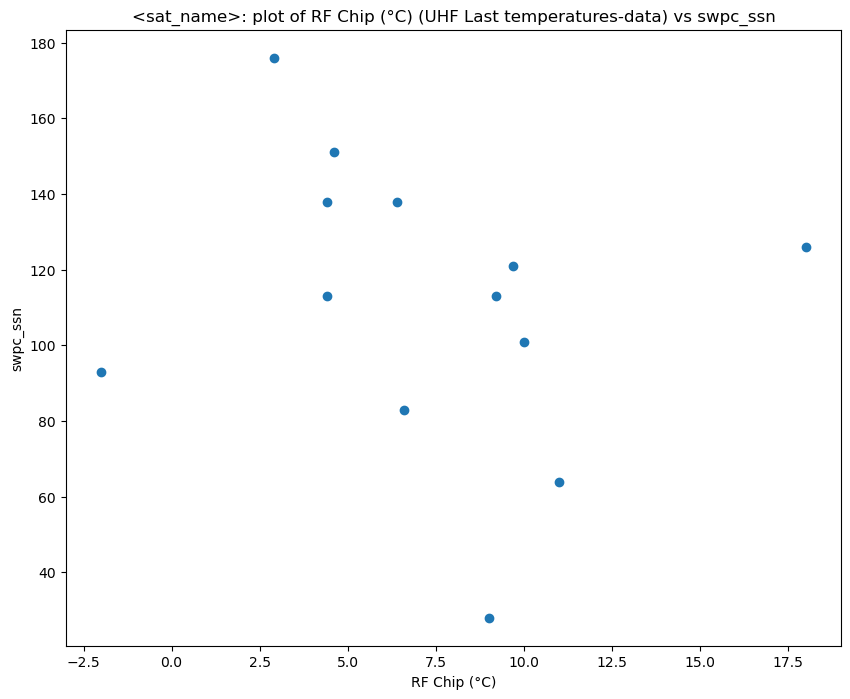

+---------+------------+------------+
|         |    PA (°C) |   swpc_ssn |
|---------+------------+------------|
| count   |  13        |  13        |
| mean    |   8.12308  | 111.154    |
| std     |   6.86151  |  38.6455   |
| min     |  -2        |  28        |
| 25%     |   4.3      |  93        |
| 50%     |   6        | 113        |
| 75%     |  10        | 138        |
| max     |  25        | 176        |
| Chi2    | 130        | 130        |
| P-value |   0.251062 |   0.251062 |
+---------+------------+------------+
Correlation [PA (°C)] vs [swpc_ssn]: pearson=[-0.10711711237073555], spearman=[-0.32231527262058657], kendal_tau=[-0.23378595005975894]


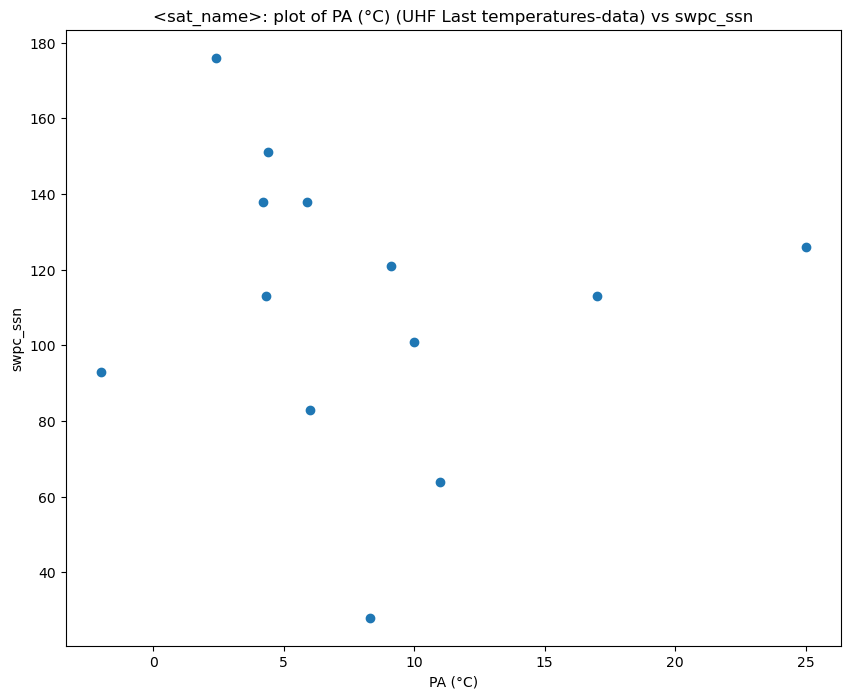

2024-02-11 17:45:08,408 - DEBUG - Processing file: ../data/veronika/UHF Received packets-data-2024-02-11 02 23 18.csv


+---------+--------------+------------+
|         |   58261.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |    13        |  13        |
| mean    |   235.385    | 111.154    |
| std     |   107.868    |  38.6455   |
| min     |     0        |  28        |
| 25%     |   270        |  93        |
| 50%     |   293        | 113        |
| 75%     |   296        | 138        |
| max     |   299        | 176        |
| Chi2    |   100.75     | 100.75     |
| P-value |     0.205923 |   0.205923 |
+---------+--------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.3324105676753036], spearman=[0.006915635937205746], kendal_tau=[-0.039735970711951306]


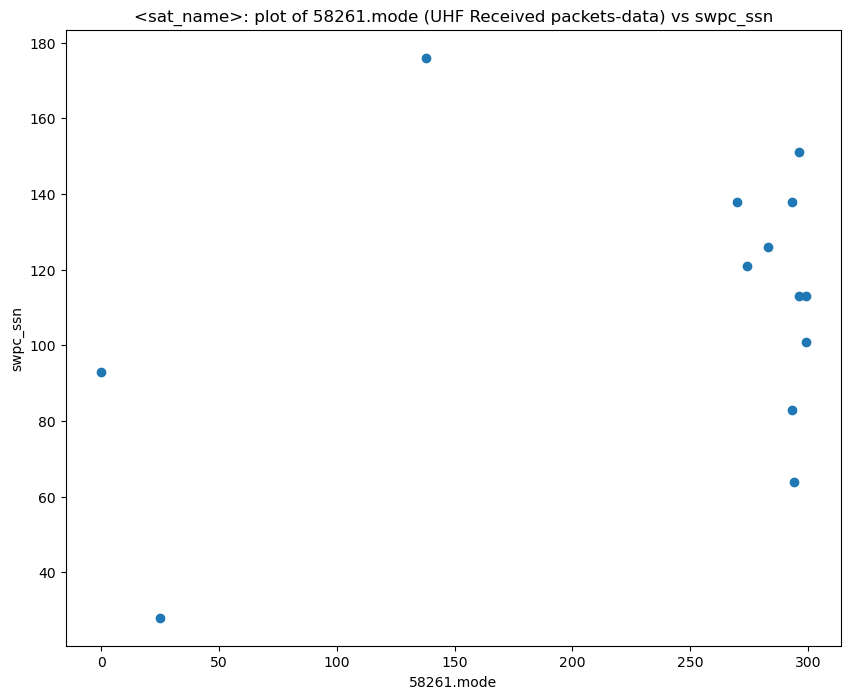

2024-02-11 17:45:08,546 - DEBUG - Processing file: ../data/veronika/UHF Resets-data-2024-02-11 02 23 11.csv
2024-02-11 17:45:08,568 - DEBUG - Processing file: ../data/veronika/UHF RF Resets-data-2024-02-11 02 23 37.csv


[UHF Resets-data]: skipping column=[58261.mode]: not enough unique values.
[UHF RF Resets-data]: skipping column=[58261.mode]: not enough unique values.


In [52]:
analyze_satellite('veronika')

2024-02-11 17:45:08,592 - DEBUG - Processing file: ../data/vzlusat-2/Battery Temperature-data-2024-02-11 02 21 24.csv


+---------+-------------------+-------------+
|         |   51085.last (°C) |    swpc_ssn |
|---------+-------------------+-------------|
| count   |        107        |  107        |
| mean    |          6.41121  |  100.037    |
| std     |          4.01637  |   38.8752   |
| min     |         -3        |   17        |
| 25%     |          3.5      |   70        |
| 50%     |          6        |  101        |
| 75%     |         10        |  132        |
| max     |         17        |  179        |
| Chi2    |       1366.52     | 1366.52     |
| P-value |          0.152881 |    0.152881 |
+---------+-------------------+-------------+
Correlation [51085.last (°C)] vs [swpc_ssn]: pearson=[-0.02759095642049777], spearman=[-0.019451876656504323], kendal_tau=[-0.011751687937229124]


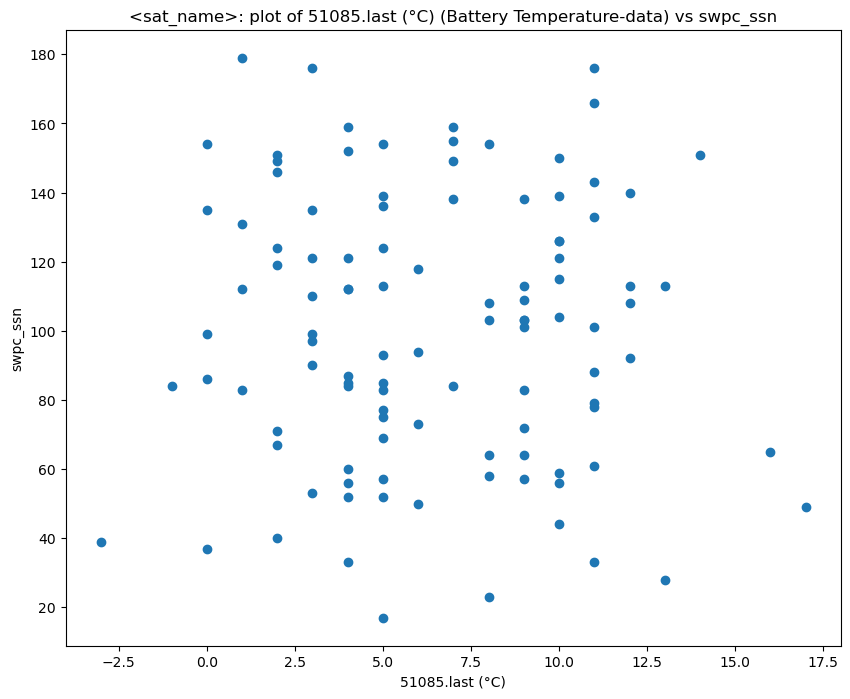

2024-02-11 17:45:08,757 - DEBUG - Processing file: ../data/vzlusat-2/Last Beacon Received By-data-2024-02-11 02 21 26.csv


[Last Beacon Received By-data]: skipping column=[last]: not enough unique values.


In [53]:
analyze_satellite('vzlusat-2')